# Spaghettree
## A coding style inspired by spaghetti code, facilitated by jupyter notebook.
## Running rule and conventions:
### 1. Each section will be considered a node, and a complete program runs from root to a leaf
### 2. For every seciton, its name will be displayed first, then its discription, parent, and children. No parent indicates Root as parent, and no children implies leaf node.  

In [12]:
# Modification on existing librarys:
# New Functions added: 
## HDC: evaluateBasis, updateClasses
## HDE: updateBasis
## HDB: updateBasis

# Changed code relative to others:
# encoding no longer use cos sin (no noise)
# dump log now dump both pickle and txt




# Root

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import time
import sys
import math
import numpy as np
import random
import joblib
from tqdm import tqdm_notebook
import copy

import Config
import Dataloader as DL
import HD_basis as HDB
import HD_encoder as HDE
import HD_classifier as HDC

import matplotlib.pyplot as plt


In [15]:
# train data 
def train(hdc, traindata, trainlabels, testdata, testlabels, param = Config.config, epochs = None):
    train_acc = []
    test_acc = []
    if epochs is not None:
        param["epochs"] = epochs
    #for i in tqdm_notebook(range(param["epochs"]), desc='epochs'):
    for i in range(param["epochs"]):
        train_acc.append(hdc.fit(traindata, trainlabels, param))
        test_acc.append(hdc.test(testdata, testlabels))
        if len(train_acc) % 20 == 0:
            print("Train: %f \t \t Test: %f"%(train_acc[-1], test_acc[-1]))
        if train_acc[-1] == 1:
            print("End Train: %f \t \t Test: %f"%(train_acc[-1], test_acc[-1]))
            break
    return np.asarray(train_acc), np.asarray(test_acc), i

In [16]:
def dump_log(param, train_acc, test_acc, filename):
    joblib.dump((param, train_acc, test_acc), open(filename+".pkl", "wb"), compress=True)
    file = open(filename+".txt", "w")
    file.write("Max train: %.2f \tMax test: %.2f \n"%(train_acc*100, test_acc*100))
    file.write(str(param))
    file.close()

In [17]:
dl = DL.Dataloader()
nFeatures, nClasses, traindata, trainlabels, testdata, testlabels = dl.getParam()

Loading dataset smart_home_split from smart_home
Loading train data... train data of shape (22290, 312) loaded
Loading test data...  test  data of shape (5574, 312) loaded
Data Loaded. Num of features = 312 Num of Classes = 3

In [18]:
#Data shuffling 
shuf_train = np.random.permutation(len(traindata))
traindata = traindata[shuf_train]
trainlabels = trainlabels[shuf_train]

shuf_test = np.random.permutation(len(testdata))
testdata = testdata[shuf_test]
testlabels = testlabels[shuf_test]

In [19]:
# data cropping
traindata = traindata[:10000]
trainlabels = trainlabels[:10000]
testdata = testdata[: 10000]
testlabels = testlabels[: 10000]

In [20]:
param = Config.config
param["nFeatures"] = nFeatures
param["nClasses"] = nClasses
print(param)

{'data_location': '../dataset/', 'directory': 'smart_home', 'dataset': 'smart_home_split', 'D': 200, 'vector': 'Gaussian', 'mu': 0, 'sigma': 1, 'binarize': 0, 'lr': 0.037, 'sparse': 0, 's': 0.1, 'binaryModel': 0, 'checkpoints': False, 'width': None, 'height': None, 'nLayers': 5, 'uniform_dim': 1, 'uniform_ker': 1, 'dArr': None, 'k': 3, 'kArr': None, 'one_shot': 0, 'data_percentages': [1.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5], 'train_percent': 1, 'dropout': 0, 'drop_percentages': [0, 0.1, 0.2, 0.5], 'dropout_rate': 0, 'update_type': <Update_T.FULL: 1>, 'masked': False, 'iter_per_trial': 3, 'iter_per_encoding': 5, 'epochs': 250, 'nFeatures': 312, 'nClasses': 3}


# Baseline Automation 


In [11]:
## Baseline Automation
log = []

for D in [100, 200, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000]:
#for D in [1500, 2500]:
    param["D"] = D
    hdb = HDB.HD_basis(HDB.Generator.Vanilla, param)
    basis = hdb.getBasis()
    param = hdb.getParam()
    hde = HDE.HD_encoder(basis)
    trainencoded = hde.encodeData(traindata)
    testencoded = hde.encodeData(testdata)
    hdc_pre = HDC.HD_classifier(param["D"], param["nClasses"], 0)
    train_accs_pre, test_accs_pre, num_iter = train(hdc_pre, trainencoded, trainlabels, testencoded, testlabels, param)
    print("Train: %f \t \t Test: %f Num_iter: %f"%(max(train_accs_pre), max(test_accs_pre), num_iter))
    log.append((D, max(train_accs_pre), max(test_accs_pre), num_iter))

Train: 0.751800 	 	 Test: 0.887188
Train: 0.753100 	 	 Test: 0.952458
Train: 0.756800 	 	 Test: 0.350524
Train: 0.757500 	 	 Test: 0.863014
Train: 0.753500 	 	 Test: 0.950846
Train: 0.761600 	 	 Test: 0.577760
Train: 0.764400 	 	 Test: 0.701048
Train: 0.759300 	 	 Test: 0.872683
Train: 0.754200 	 	 Test: 0.930701
Train: 0.761600 	 	 Test: 0.782434
Train: 0.755400 	 	 Test: 0.400483
Train: 0.760800 	 	 Test: 0.790492
Train: 0.769900 	 	 Test: 0.959710 Num_iter: 249.000000
Train: 0.758100 	 	 Test: 0.907333
Train: 0.763100 	 	 Test: 0.806608
Train: 0.761300 	 	 Test: 0.884770
Train: 0.764300 	 	 Test: 0.916197
Train: 0.770200 	 	 Test: 0.834005
Train: 0.760200 	 	 Test: 0.859790
Train: 0.761500 	 	 Test: 0.765512
Train: 0.768400 	 	 Test: 0.846092
Train: 0.762400 	 	 Test: 0.878324
Train: 0.767100 	 	 Test: 0.887994
Train: 0.767200 	 	 Test: 0.874295
Train: 0.759500 	 	 Test: 0.425463
Train: 0.773800 	 	 Test: 0.949234 Num_iter: 249.000000
Train: 0.751200 	 	 Test: 0.911362
Train: 0.7612

In [12]:
print(log)
for (D, t1, t2, it) in log:
    print(t2)
print("##################")
for (D, t1, t2, it) in log:
    print(it)

[(100, 0.7699, 0.959709911361805, 249), (200, 0.7738, 0.9492344883158743, 249), (500, 0.7757, 0.9564867042707494, 249), (750, 0.7801, 0.9548751007252216, 249), (1000, 0.7818, 0.9572925060435133, 249), (1500, 0.7789, 0.958904109589041, 249), (2000, 0.7796, 0.959709911361805, 249), (2500, 0.7799, 0.9532634971796938, 249), (3000, 0.7798, 0.958904109589041, 249), (4000, 0.7819, 0.9572925060435133, 249)]
0.959709911361805
0.9492344883158743
0.9564867042707494
0.9548751007252216
0.9572925060435133
0.958904109589041
0.959709911361805
0.9532634971796938
0.958904109589041
0.9572925060435133
##################
249
249
249
249
249
249
249
249
249
249


# Dimension Dropping 

In [ ]:
# Generate a base model

hdb = HDB.HD_basis(HDB.Generator.Vanilla, param)
basis = hdb.getBasis()
param = hdb.getParam()
hde = HDE.HD_encoder(basis)
trainencoded = hde.encodeData(traindata)
testencoded = hde.encodeData(testdata)
hdc_pre = HDC.HD_classifier(param["D"], param["nClasses"], 0)
train_accs_pre, test_accs_pre, num_iter = train(hdc_pre, trainencoded, trainlabels, testencoded, testlabels, param)

oghdc = copy.deepcopy(hdc_pre)
var, orders = oghdc.evaluateBasis()

In [ ]:
D = oghdc.D    

bl = oghdc.test(testencoded, testlabels)


los = []
lo_hdc = copy.deepcopy(oghdc)
for dr in range(1, 51, 1):

    drop_rate = dr/100
    amountDrop = int(drop_rate * D)
    
    lo_idx = orders[:amountDrop]
    #lo_var = [var[idx] for idx in lo_idx]
    lo_hdc.updateClasses(lo_idx)
    lo_acc = lo_hdc.test(testencoded, testlabels)
    los.append(lo_acc)


his = []
hi_hdc = copy.deepcopy(oghdc)
for dr in range(1, 51, 1):
    
    drop_rate = dr/100
    amountDrop = int(drop_rate * D)
    
    hi_idx = orders[-amountDrop:]
    #hi_var = [var[idx] for idx in hi_idx]
    hi_hdc.updateClasses(hi_idx)
    hi_acc = hi_hdc.test(testencoded, testlabels)
    his.append(hi_acc)
    
    
rds = []
rd_hdc = copy.deepcopy(oghdc)
rd_perm = np.random.permutation(D)
for dr in range(1, 51, 1):
    
    drop_rate = dr/100
    amountDrop = int(drop_rate * D)
    
    rd_idx = rd_perm[:amountDrop]
    #rd_var = [var[idx] for idx in rd_idx]
    rd_hdc.updateClasses(rd_idx)
    rd_acc = rd_hdc.test(testencoded, testlabels)
    rds.append(rd_acc)

In [ ]:
print(los)
print(his)
print(rds)

print("#################################")
print(bl)
print("#################################")
for lo in los:
    print(lo)
print("#################################")
for hi in his:
    print(hi)
print("#################################")
for rd in rds:
    print(rd)



# RegenHD train

In [16]:

# Given listed parameters, generate a RegenHD model + best model during train
# Train method: train till an effective dimension 
def train_regen_ed(traindata, trainlabels, testdata, testlabels,
                   D, # initial baseline
                   eDs,  # list of effective dimensions to reach 
                   percentDrop, # drop/regen rate 
                   iter_per_update, # # iterations per regen  
                   param):

    param["D"] = D
    
    # Initialize basis & classifier
    hdb = HDB.HD_basis(HDB.Generator.Vanilla, param)
    basis = hdb.getBasis()
    param = hdb.getParam()
    hde = HDE.HD_encoder(basis)
    trainencoded = hde.encodeData(traindata)
    testencoded = hde.encodeData(testdata)
    # Initialize classifier
    train_accs = []
    test_accs = []
    hdc = HDC.HD_classifier(param["D"], param["nClasses"], 0)

    # Prepare setting for train
    amountDrop = int(percentDrop * hdc.D)
    regenTimes = [ math.ceil((eD-D)/amountDrop) for eD in eDs]
    print("Updating times:", regenTimes)

    early_stopping_steps = 1000 # earlystopping is "turned off"

    #es_count = 0
    max_test = 0
    best = None
    best_idx = 0
    
    # Checkpoints
    checkpoints = []

    for i in range(max(regenTimes)+1): # For each eDs to reach, will checkpoints

        # Do the train 
        for j in range(iter_per_update):
            train_acc = 100 * hdc.fit(trainencoded, trainlabels, param)
            test_acc = 100 * hdc.test(testencoded, testlabels)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print("Train: %.2f \t \t Test: %.2f"%(train_acc, test_acc))
            if train_acc == 100:
                break
         
        if train_acc == 100:
            print("Train converged! taking snippit in checkpoints")
            hdb_ck = copy.deepcopy(hdb)
            hdc_ck = copy.deepcopy(hdc)
            _, post_test_accs, _ = train(hdc_ck, trainencoded, trainlabels, testencoded, testlabels, param, epochs = 50)
            checkpoints.append((i+1, (D + (i)*amountDrop), 
                                hdb_ck, hdc_ck, 
                                max(test_accs[-iter_per_update:]), max(post_test_accs)))

        if test_accs[-1] >= max_test:
            es_count = 0
            best = copy.deepcopy(hdc)
            best_idx = len(test_accs)
        else:
            es_count += 1
        if es_count > early_stopping_steps:
            print("Early stopping initiated, best stores the best hdc currently")
            break
        
        if i in regenTimes:
            print("Checkpoint made!")
            hdb_ck = copy.deepcopy(hdb)
            hdc_ck = copy.deepcopy(hdc)
            _, post_test_accs, _ = train(hdc_ck, trainencoded, trainlabels, testencoded, testlabels, param, epochs = 50)
            checkpoints.append((D, (D + (i)*amountDrop), 
                                None, None, #hdb_ck, hdc_ck, 
                                max(test_accs[-iter_per_update:]), max(post_test_accs)))
        
        # Do the regeneration
        var, orders = hdc.evaluateBasis()
        toDrop = orders[:amountDrop]
        toMask = orders[-amountDrop:]
        toDropVar = [var[i] for i in toDrop]
        print("Variances stats: max %.2f, min %.2f, mean %.2f"%(max(var),min(var),np.mean(var)))
        #print("Dropping first %f percent of ineffective basis, with stats: max %f, min %f, mean %f"\
        #      %(percentDrop, max(toDropVar),min(toDropVar),np.mean(toDropVar)))
        hdb.updateBasis(toDrop)
        hde.updateBasis(hdb.basis)
        trainencoded = hde.encodeData(traindata)
        testencoded = hde.encodeData(testdata)
        hdc.updateClasses()
        
    return checkpoints


In [11]:
# The ultra-automation 
log = dict()

Ds = [100, 200, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000]
percentDrops = [0.05, 0.1, 0.2]
iter_per_updates = [1, 2, 3, 4, 5, 10]

#Ds = [200, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000]
#percentDrops = [0.05]
#iter_per_updates = [1, 2, 3, 4]


 
for i, D in enumerate(Ds[:-1]):
    eDs = Ds[i+1:i+7]
    for percentDrop in percentDrops:
        for iter_per_update in iter_per_updates:
            print("Current config:", D, percentDrop, iter_per_update)
            checkpoints = train_regen_ed(traindata, trainlabels, testdata, testlabels,
                   D, # initial baseline
                   eDs,  # list of effective dimensions to reach 
                   percentDrop, # drop/regen rate 
                   iter_per_update, # # iterations per regen  
                   param)
            if (percentDrop,iter_per_update) not in log:
                log[(percentDrop,iter_per_update)] = checkpoints
            else:
                log[(percentDrop,iter_per_update)].extend(checkpoints)

Current config: 100 0.05 1
Updating times: [20, 80, 130, 180, 280, 380]
Train: 60.76 	 	 Test: 58.24
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 73.53 	 	 Test: 73.06
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 74.21 	 	 Test: 76.72
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 74.37 	 	 Test: 74.98
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 75.15 	 	 Test: 84.16
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 74.09 	 	 Test: 78.13
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 75.46 	 	 Test: 75.11
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 74.61 	 	 Test: 75.63
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 75.10 	 	 Test: 80.44
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 76.42 	 	 Test: 79.22
Variances stats: max 0.02,

Train: 80.22 	 	 Test: 82.62
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.71 	 	 Test: 77.87
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.31 	 	 Test: 78.38
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.22 	 	 Test: 79.35
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.44 	 	 Test: 73.19
Variances stats: max 0.01, min 0.01, mean 0.01
Updating basis......
Train: 80.81 	 	 Test: 78.06
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.08 	 	 Test: 80.18
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.38 	 	 Test: 79.15
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.46 	 	 Test: 76.07
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.64 	 	 Test: 84.93
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 81.23 	 	 Test: 74.86
V

Train: 82.72 	 	 Test: 86.02
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 82.49 	 	 Test: 85.12
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.09 	 	 Test: 82.30
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 82.67 	 	 Test: 82.42
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 82.19 	 	 Test: 83.58
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.12 	 	 Test: 84.22
Variances stats: max 0.02, min 0.01, mean 0.01
Updating basis......
Train: 82.53 	 	 Test: 84.09
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 82.21 	 	 Test: 81.53
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.55 	 	 Test: 84.41
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.68 	 	 Test: 81.91
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 81.60 	 	 Test: 83.64
V

Train: 82.65 	 	 Test: 82.17
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.85 	 	 Test: 83.07
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.55 	 	 Test: 83.32
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.39 	 	 Test: 84.48
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.15 	 	 Test: 82.36
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.54 	 	 Test: 84.16
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.47 	 	 Test: 83.00
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.10 	 	 Test: 84.28
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.67 	 	 Test: 84.67
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.01 	 	 Test: 83.64
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.92 	 	 Test: 78.96
V

Train: 84.45 	 	 Test: 83.96
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.51 	 	 Test: 85.18
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.10 	 	 Test: 82.81
Variances stats: max 0.01, min 0.01, mean 0.01
Updating basis......
Train: 84.66 	 	 Test: 83.52
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.32 	 	 Test: 84.41
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.00 	 	 Test: 83.58
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.50 	 	 Test: 84.09
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.19 	 	 Test: 82.36
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.84 	 	 Test: 83.58
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.39 	 	 Test: 85.25
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.84 	 	 Test: 86.14
V

Train: 79.80 	 	 Test: 81.53
Train: 85.28 	 	 Test: 79.41
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.73 	 	 Test: 86.27
Train: 85.09 	 	 Test: 86.21
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.47 	 	 Test: 80.95
Train: 84.82 	 	 Test: 85.05
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.21 	 	 Test: 81.59
Train: 84.48 	 	 Test: 85.89
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.91 	 	 Test: 78.77
Train: 85.38 	 	 Test: 84.61
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.97 	 	 Test: 78.51
Train: 84.82 	 	 Test: 80.31
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.15 	 	 Test: 81.85
Train: 84.88 	 	 Test: 83.32
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.55 	 	 Test: 77.81
Train: 84.51 	 	 Test: 83.19
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basi

Train: 84.79 	 	 Test: 82.68
Train: 87.13 	 	 Test: 85.57
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.25 	 	 Test: 82.87
Train: 87.64 	 	 Test: 84.41
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.82 	 	 Test: 87.17
Train: 87.45 	 	 Test: 85.05
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.98 	 	 Test: 85.70
Train: 86.92 	 	 Test: 84.67
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.03 	 	 Test: 82.30
Train: 86.89 	 	 Test: 86.72
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.11 	 	 Test: 84.86
Train: 86.57 	 	 Test: 80.89
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.95 	 	 Test: 84.48
Train: 86.47 	 	 Test: 81.59
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.43 	 	 Test: 77.10
Train: 87.24 	 	 Test: 86.98
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basi

Train: 84.56 	 	 Test: 83.26
Train: 87.70 	 	 Test: 84.09
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.66 	 	 Test: 86.72
Train: 87.42 	 	 Test: 81.33
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.25 	 	 Test: 81.21
Train: 87.80 	 	 Test: 83.84
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.52 	 	 Test: 82.42
Train: 86.89 	 	 Test: 77.68
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.10 	 	 Test: 86.85
Train: 88.27 	 	 Test: 87.17
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.71 	 	 Test: 83.45
Train: 87.98 	 	 Test: 86.47
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.48 	 	 Test: 83.96
Train: 87.05 	 	 Test: 84.03
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.55 	 	 Test: 86.40
Train: 87.48 	 	 Test: 83.71
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basi

Train: 84.27 	 	 Test: 87.11
Train: 87.32 	 	 Test: 89.29
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.55 	 	 Test: 80.89
Train: 89.26 	 	 Test: 80.18
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.75 	 	 Test: 83.71
Train: 87.46 	 	 Test: 86.98
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.42 	 	 Test: 82.94
Train: 87.48 	 	 Test: 86.27
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.14 	 	 Test: 85.05
Train: 87.32 	 	 Test: 87.43
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.58 	 	 Test: 86.34
Train: 87.11 	 	 Test: 86.91
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.36 	 	 Test: 82.75
Train: 87.77 	 	 Test: 84.61
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.83 	 	 Test: 82.49
Train: 87.93 	 	 Test: 83.84
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basi

Train: 85.51 	 	 Test: 83.45
Train: 87.77 	 	 Test: 87.49
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.71 	 	 Test: 84.03
Train: 88.14 	 	 Test: 84.54
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.48 	 	 Test: 83.64
Train: 88.20 	 	 Test: 87.68
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.09 	 	 Test: 85.12
Train: 88.43 	 	 Test: 86.91
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.16 	 	 Test: 84.86
Train: 87.86 	 	 Test: 88.26
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.03 	 	 Test: 83.45
Train: 87.77 	 	 Test: 87.36
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.87 	 	 Test: 85.82
Train: 87.80 	 	 Test: 82.75
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.52 	 	 Test: 79.99
Train: 88.06 	 	 Test: 86.08
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basi

Train: 85.70 	 	 Test: 81.85
Train: 87.67 	 	 Test: 82.87
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.57 	 	 Test: 86.79
Train: 87.62 	 	 Test: 84.80
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.54 	 	 Test: 84.48
Train: 87.58 	 	 Test: 88.45
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.35 	 	 Test: 80.89
Train: 88.28 	 	 Test: 86.27
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.03 	 	 Test: 81.33
Train: 87.93 	 	 Test: 81.21
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.80 	 	 Test: 85.18
Train: 88.03 	 	 Test: 88.13
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.36 	 	 Test: 83.84
Train: 88.39 	 	 Test: 85.82
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.25 	 	 Test: 86.98
Train: 88.79 	 	 Test: 85.50
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basi

Train: 78.92 	 	 Test: 73.32
Train: 84.80 	 	 Test: 81.21
Train: 85.84 	 	 Test: 84.93
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 79.18 	 	 Test: 84.93
Train: 85.00 	 	 Test: 84.03
Train: 86.04 	 	 Test: 81.53
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.36 	 	 Test: 80.05
Train: 84.35 	 	 Test: 80.31
Train: 86.74 	 	 Test: 82.62
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.60 	 	 Test: 75.43
Train: 84.13 	 	 Test: 82.87
Train: 85.83 	 	 Test: 83.96
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.20 	 	 Test: 80.56
Train: 84.43 	 	 Test: 82.30
Train: 86.74 	 	 Test: 85.31
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.54 	 	 Test: 78.13
Train: 84.69 	 	 Test: 80.24
Train: 86.15 	 	 Test: 83.71
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.25 	 	 Test: 74.47
Train: 84.55 	 	 Test: 82.68
Train: 86.09

Train: 88.60 	 	 Test: 84.93
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.85 	 	 Test: 81.53
Train: 86.12 	 	 Test: 82.75
Train: 87.24 	 	 Test: 84.99
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.33 	 	 Test: 83.26
Train: 86.15 	 	 Test: 79.28
Train: 88.35 	 	 Test: 84.80
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.65 	 	 Test: 78.51
Train: 85.99 	 	 Test: 81.59
Train: 88.39 	 	 Test: 86.02
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.04 	 	 Test: 82.81
Train: 85.20 	 	 Test: 82.30
Train: 87.59 	 	 Test: 86.02
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.30 	 	 Test: 81.98
Train: 85.62 	 	 Test: 84.41
Train: 88.28 	 	 Test: 82.23
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.82 	 	 Test: 81.08
Train: 86.42 	 	 Test: 81.08
Train: 88.25 	 	 Test: 82.94
Variances stats: max 0.02, min 0.00, mean

Train: 84.69 	 	 Test: 79.41
Train: 86.84 	 	 Test: 81.85
Train: 88.81 	 	 Test: 86.21
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.79 	 	 Test: 84.99
Train: 87.42 	 	 Test: 79.99
Train: 88.78 	 	 Test: 82.75
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.78 	 	 Test: 76.97
Train: 87.83 	 	 Test: 83.77
Train: 88.71 	 	 Test: 87.11
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.75 	 	 Test: 79.35
Train: 87.67 	 	 Test: 87.17
Train: 88.54 	 	 Test: 85.25
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.70 	 	 Test: 84.61
Train: 87.51 	 	 Test: 78.00
Train: 89.28 	 	 Test: 84.80
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.91 	 	 Test: 81.59
Train: 87.08 	 	 Test: 86.02
Train: 89.00 	 	 Test: 86.27
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.08 	 	 Test: 80.12
Train: 87.70 	 	 Test: 82.10
Train: 88.60

Train: 89.42 	 	 Test: 85.50
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.04 	 	 Test: 83.90
Train: 86.79 	 	 Test: 85.12
Train: 89.02 	 	 Test: 85.18
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.48 	 	 Test: 80.50
Train: 88.03 	 	 Test: 85.18
Train: 88.73 	 	 Test: 88.13
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.69 	 	 Test: 83.84
Train: 87.69 	 	 Test: 86.21
Train: 89.76 	 	 Test: 88.52
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.18 	 	 Test: 84.48
Train: 87.82 	 	 Test: 84.22
Train: 89.32 	 	 Test: 89.22
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.71 	 	 Test: 83.52
Train: 87.66 	 	 Test: 85.05
Train: 89.39 	 	 Test: 82.94
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.18 	 	 Test: 83.26
Train: 88.73 	 	 Test: 85.31
Train: 89.20 	 	 Test: 86.98
Variances stats: max 0.02, min 0.00, mean

Train: 90.32 	 	 Test: 86.91
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.48 	 	 Test: 83.39
Train: 88.71 	 	 Test: 83.39
Train: 90.48 	 	 Test: 88.39
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.09 	 	 Test: 82.94
Train: 89.48 	 	 Test: 85.50
Train: 89.48 	 	 Test: 86.53
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.41 	 	 Test: 82.87
Train: 87.99 	 	 Test: 85.05
Train: 89.64 	 	 Test: 84.93
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.48 	 	 Test: 80.69
Train: 87.67 	 	 Test: 84.41
Train: 89.60 	 	 Test: 84.09
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.03 	 	 Test: 86.79
Train: 88.25 	 	 Test: 85.38
Train: 89.58 	 	 Test: 88.26
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.64 	 	 Test: 82.17
Train: 88.36 	 	 Test: 84.35
Train: 89.12 	 	 Test: 86.14
Variances stats: max 0.02, min 0.00, mean

Train: 85.60 	 	 Test: 80.05
Train: 88.19 	 	 Test: 82.36
Train: 90.49 	 	 Test: 86.66
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.54 	 	 Test: 84.61
Train: 89.10 	 	 Test: 86.21
Train: 90.16 	 	 Test: 84.16
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.28 	 	 Test: 85.70
Train: 89.05 	 	 Test: 84.28
Train: 90.46 	 	 Test: 85.82
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.91 	 	 Test: 85.38
Train: 88.36 	 	 Test: 87.24
Train: 90.22 	 	 Test: 87.17
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.81 	 	 Test: 79.79
Train: 88.55 	 	 Test: 87.68
Train: 89.88 	 	 Test: 86.02
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.67 	 	 Test: 84.35
Train: 88.86 	 	 Test: 85.82
Train: 90.40 	 	 Test: 87.36
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.96 	 	 Test: 86.98
Train: 88.62 	 	 Test: 83.39
Train: 89.32

Train: 86.28 	 	 Test: 77.49
Train: 89.07 	 	 Test: 87.11
Train: 90.11 	 	 Test: 86.27
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 86.02 	 	 Test: 84.03
Train: 88.31 	 	 Test: 85.50
Train: 90.48 	 	 Test: 87.56
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 86.28 	 	 Test: 85.44
Train: 89.03 	 	 Test: 86.98
Train: 90.72 	 	 Test: 88.33
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 86.57 	 	 Test: 84.48
Train: 89.40 	 	 Test: 86.91
Train: 90.08 	 	 Test: 86.27
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.40 	 	 Test: 84.16
Train: 89.05 	 	 Test: 86.34
Train: 90.78 	 	 Test: 84.16
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 86.21 	 	 Test: 82.62
Train: 88.75 	 	 Test: 87.30
Train: 91.02 	 	 Test: 85.95
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.49 	 	 Test: 84.03
Train: 88.68 	 	 Test: 84.80
Train: 90.25

Train: 77.67 	 	 Test: 80.12
Train: 84.15 	 	 Test: 76.59
Train: 84.83 	 	 Test: 82.42
Train: 86.15 	 	 Test: 83.77
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.03 	 	 Test: 72.48
Train: 83.44 	 	 Test: 81.27
Train: 85.99 	 	 Test: 82.81
Train: 87.13 	 	 Test: 85.57
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 78.76 	 	 Test: 78.96
Train: 84.32 	 	 Test: 81.78
Train: 85.19 	 	 Test: 84.48
Train: 87.61 	 	 Test: 80.95
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 79.87 	 	 Test: 78.58
Train: 84.56 	 	 Test: 83.07
Train: 86.73 	 	 Test: 83.58
Train: 87.54 	 	 Test: 84.99
Variances stats: max 0.02, min 0.01, mean 0.01
Updating basis......
Train: 80.28 	 	 Test: 83.84
Train: 84.77 	 	 Test: 86.27
Train: 86.81 	 	 Test: 84.80
Train: 87.86 	 	 Test: 86.72
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.92 	 	 Test: 84.54
Train: 84.24 	 	 Test: 84.22
Train: 86.25 	 	 Test:

Train: 87.24 	 	 Test: 84.73
Train: 88.47 	 	 Test: 86.27
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.55 	 	 Test: 80.69
Train: 87.53 	 	 Test: 85.25
Train: 88.09 	 	 Test: 86.79
Train: 89.29 	 	 Test: 86.21
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.41 	 	 Test: 80.50
Train: 85.91 	 	 Test: 87.56
Train: 88.33 	 	 Test: 87.11
Train: 89.10 	 	 Test: 85.25
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.98 	 	 Test: 84.54
Train: 86.42 	 	 Test: 83.07
Train: 88.39 	 	 Test: 86.85
Train: 89.00 	 	 Test: 84.22
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.33 	 	 Test: 82.55
Train: 86.41 	 	 Test: 84.99
Train: 88.60 	 	 Test: 83.52
Train: 89.53 	 	 Test: 89.54
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.99 	 	 Test: 85.76
Train: 86.68 	 	 Test: 84.61
Train: 88.07 	 	 Test: 86.79
Train: 89.02 	 	 Test: 85.31
Variances stats: max 0

Train: 83.99 	 	 Test: 78.06
Train: 87.35 	 	 Test: 87.17
Train: 88.86 	 	 Test: 83.77
Train: 89.95 	 	 Test: 86.08
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.55 	 	 Test: 86.08
Train: 87.46 	 	 Test: 86.02
Train: 88.41 	 	 Test: 86.21
Train: 89.69 	 	 Test: 88.20
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.08 	 	 Test: 82.04
Train: 86.98 	 	 Test: 84.67
Train: 89.34 	 	 Test: 81.85
Train: 89.68 	 	 Test: 88.39
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.58 	 	 Test: 83.13
Train: 87.50 	 	 Test: 85.57
Train: 89.24 	 	 Test: 86.91
Train: 89.88 	 	 Test: 85.50
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.84 	 	 Test: 82.17
Train: 86.84 	 	 Test: 84.67
Train: 89.03 	 	 Test: 88.33
Train: 90.46 	 	 Test: 88.20
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 82.93 	 	 Test: 84.03
Train: 86.87 	 	 Test: 87.56
Train: 88.84 	 	 Test:

Train: 89.18 	 	 Test: 87.94
Train: 90.56 	 	 Test: 88.07
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.43 	 	 Test: 85.89
Train: 87.02 	 	 Test: 87.36
Train: 88.89 	 	 Test: 83.26
Train: 90.54 	 	 Test: 86.53
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.69 	 	 Test: 84.99
Train: 87.99 	 	 Test: 79.03
Train: 89.52 	 	 Test: 88.45
Train: 90.78 	 	 Test: 88.39
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.59 	 	 Test: 85.05
Train: 87.24 	 	 Test: 83.58
Train: 89.26 	 	 Test: 82.36
Train: 90.46 	 	 Test: 88.90
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.45 	 	 Test: 84.80
Train: 88.47 	 	 Test: 85.25
Train: 89.61 	 	 Test: 89.22
Train: 90.25 	 	 Test: 86.34
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.60 	 	 Test: 80.95
Train: 87.45 	 	 Test: 84.28
Train: 89.52 	 	 Test: 85.57
Train: 90.14 	 	 Test: 86.91
Variances stats: max 0

Train: 85.38 	 	 Test: 87.17
Train: 87.94 	 	 Test: 87.88
Train: 89.76 	 	 Test: 85.12
Train: 90.96 	 	 Test: 89.54
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.01 	 	 Test: 84.61
Train: 87.26 	 	 Test: 85.05
Train: 89.40 	 	 Test: 85.12
Train: 91.30 	 	 Test: 87.94
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.20 	 	 Test: 86.72
Train: 87.80 	 	 Test: 89.22
Train: 88.75 	 	 Test: 86.08
Train: 90.75 	 	 Test: 87.04
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.02 	 	 Test: 84.99
Train: 87.42 	 	 Test: 85.63
Train: 89.26 	 	 Test: 80.69
Train: 90.54 	 	 Test: 87.11
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.66 	 	 Test: 84.16
Train: 88.63 	 	 Test: 86.08
Train: 89.85 	 	 Test: 85.38
Train: 90.73 	 	 Test: 87.17
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.88 	 	 Test: 85.31
Train: 88.71 	 	 Test: 85.63
Train: 89.66 	 	 Test:

Train: 85.92 	 	 Test: 85.05
Train: 88.30 	 	 Test: 82.94
Train: 89.84 	 	 Test: 87.88
Train: 90.53 	 	 Test: 88.07
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.04 	 	 Test: 82.81
Train: 88.03 	 	 Test: 85.44
Train: 89.85 	 	 Test: 85.95
Train: 90.41 	 	 Test: 88.26
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.78 	 	 Test: 85.25
Train: 88.91 	 	 Test: 84.41
Train: 90.21 	 	 Test: 89.74
Train: 90.33 	 	 Test: 89.74
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.28 	 	 Test: 87.62
Train: 87.64 	 	 Test: 86.53
Train: 90.29 	 	 Test: 87.75
Train: 90.73 	 	 Test: 86.14
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.44 	 	 Test: 86.21
Train: 88.49 	 	 Test: 83.77
Train: 89.60 	 	 Test: 87.24
Train: 90.77 	 	 Test: 88.90
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.92 	 	 Test: 82.75
Train: 88.49 	 	 Test: 86.98
Train: 89.23 	 	 Test:

Train: 90.22 	 	 Test: 86.98
Train: 90.29 	 	 Test: 88.20
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.38 	 	 Test: 84.67
Train: 88.55 	 	 Test: 87.56
Train: 90.40 	 	 Test: 85.95
Train: 91.04 	 	 Test: 88.26
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.01 	 	 Test: 83.39
Train: 88.49 	 	 Test: 87.88
Train: 89.85 	 	 Test: 85.18
Train: 90.62 	 	 Test: 85.57
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.76 	 	 Test: 87.81
Train: 89.24 	 	 Test: 86.66
Train: 90.65 	 	 Test: 88.07
Train: 91.34 	 	 Test: 89.80
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.81 	 	 Test: 85.31
Train: 89.56 	 	 Test: 87.17
Train: 89.71 	 	 Test: 88.45
Train: 90.73 	 	 Test: 88.39
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.36 	 	 Test: 86.59
Train: 88.22 	 	 Test: 86.34
Train: 90.24 	 	 Test: 88.45
Train: 90.78 	 	 Test: 86.79
Variances stats: max 0

Train: 86.10 	 	 Test: 83.26
Train: 87.93 	 	 Test: 88.39
Train: 90.19 	 	 Test: 84.93
Train: 91.13 	 	 Test: 86.79
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.92 	 	 Test: 80.24
Train: 88.01 	 	 Test: 87.56
Train: 89.40 	 	 Test: 86.91
Train: 90.59 	 	 Test: 84.35
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.22 	 	 Test: 85.31
Train: 88.87 	 	 Test: 84.86
Train: 89.56 	 	 Test: 86.27
Train: 91.34 	 	 Test: 88.97
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.92 	 	 Test: 81.46
Train: 88.07 	 	 Test: 88.65
Train: 90.08 	 	 Test: 86.02
Train: 91.01 	 	 Test: 86.34
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.56 	 	 Test: 80.63
Train: 88.73 	 	 Test: 84.99
Train: 90.32 	 	 Test: 88.26
Train: 91.31 	 	 Test: 88.84
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.72 	 	 Test: 83.71
Train: 89.05 	 	 Test: 88.71
Train: 89.90 	 	 Test:

Train: 86.07 	 	 Test: 86.40
Train: 88.65 	 	 Test: 88.97
Train: 90.48 	 	 Test: 81.65
Train: 91.52 	 	 Test: 86.02
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.76 	 	 Test: 85.44
Train: 88.87 	 	 Test: 84.99
Train: 90.17 	 	 Test: 87.62
Train: 91.44 	 	 Test: 87.75
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 86.37 	 	 Test: 85.95
Train: 88.89 	 	 Test: 87.36
Train: 90.51 	 	 Test: 85.25
Train: 90.80 	 	 Test: 89.42
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.84 	 	 Test: 85.95
Train: 89.24 	 	 Test: 86.85
Train: 90.11 	 	 Test: 87.43
Train: 91.70 	 	 Test: 86.53
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.44 	 	 Test: 86.47
Train: 88.60 	 	 Test: 85.89
Train: 91.17 	 	 Test: 84.86
Train: 91.49 	 	 Test: 89.80
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.54 	 	 Test: 85.70
Train: 88.47 	 	 Test: 87.88
Train: 90.69 	 	 Test:

Train: 80.84 	 	 Test: 83.26
Train: 85.84 	 	 Test: 83.52
Train: 87.42 	 	 Test: 84.41
Train: 89.07 	 	 Test: 83.39
Train: 89.15 	 	 Test: 87.81
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.16 	 	 Test: 76.97
Train: 85.16 	 	 Test: 81.01
Train: 87.50 	 	 Test: 84.16
Train: 88.73 	 	 Test: 86.53
Train: 89.60 	 	 Test: 83.00
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.86 	 	 Test: 81.78
Train: 86.07 	 	 Test: 84.80
Train: 87.34 	 	 Test: 85.95
Train: 88.35 	 	 Test: 85.95
Train: 89.26 	 	 Test: 82.81
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.81 	 	 Test: 79.47
Train: 86.47 	 	 Test: 84.22
Train: 87.88 	 	 Test: 86.02
Train: 88.43 	 	 Test: 83.07
Train: 90.54 	 	 Test: 83.58
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.52 	 	 Test: 79.28
Train: 85.51 	 	 Test: 80.63
Train: 86.84 	 	 Test: 83.39
Train: 88.63 	 	 Test: 86.66
Train: 90.19 	 	 Test: 84.09
Var

Train: 90.73 	 	 Test: 88.97
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.41 	 	 Test: 83.07
Train: 87.45 	 	 Test: 84.41
Train: 89.28 	 	 Test: 85.38
Train: 89.56 	 	 Test: 87.24
Train: 90.67 	 	 Test: 86.66
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.23 	 	 Test: 82.94
Train: 86.41 	 	 Test: 88.97
Train: 89.26 	 	 Test: 87.30
Train: 90.03 	 	 Test: 86.91
Train: 90.08 	 	 Test: 87.81
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.82 	 	 Test: 81.85
Train: 88.46 	 	 Test: 86.08
Train: 88.28 	 	 Test: 86.79
Train: 90.09 	 	 Test: 85.63
Train: 91.17 	 	 Test: 88.39
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.27 	 	 Test: 86.08
Train: 87.02 	 	 Test: 85.31
Train: 89.18 	 	 Test: 84.67
Train: 90.27 	 	 Test: 88.39
Train: 91.28 	 	 Test: 86.21
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.00 	 	 Test: 78.96
Train: 87.88 	 	 Test:

Train: 85.78 	 	 Test: 78.64
Train: 88.71 	 	 Test: 85.76
Train: 89.77 	 	 Test: 87.43
Train: 91.01 	 	 Test: 87.49
Train: 91.38 	 	 Test: 88.26
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.73 	 	 Test: 85.89
Train: 88.36 	 	 Test: 88.33
Train: 89.40 	 	 Test: 83.13
Train: 90.80 	 	 Test: 88.84
Train: 91.46 	 	 Test: 83.07
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.91 	 	 Test: 85.18
Train: 88.39 	 	 Test: 80.24
Train: 88.97 	 	 Test: 88.52
Train: 90.80 	 	 Test: 83.77
Train: 91.73 	 	 Test: 88.58
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.17 	 	 Test: 81.40
Train: 88.62 	 	 Test: 85.05
Train: 89.63 	 	 Test: 84.80
Train: 90.83 	 	 Test: 88.26
Train: 92.00 	 	 Test: 82.87
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.12 	 	 Test: 80.18
Train: 89.00 	 	 Test: 88.65
Train: 90.16 	 	 Test: 87.75
Train: 90.89 	 	 Test: 84.16
Train: 91.34 	 	 Test: 87.43
Var

Train: 90.08 	 	 Test: 87.68
Train: 91.30 	 	 Test: 88.71
Train: 91.98 	 	 Test: 87.43
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.27 	 	 Test: 77.68
Train: 88.57 	 	 Test: 86.34
Train: 90.53 	 	 Test: 86.98
Train: 91.12 	 	 Test: 88.58
Train: 92.05 	 	 Test: 85.50
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.09 	 	 Test: 84.61
Train: 88.51 	 	 Test: 86.79
Train: 90.17 	 	 Test: 84.99
Train: 90.94 	 	 Test: 88.77
Train: 91.44 	 	 Test: 85.25
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.86 	 	 Test: 81.65
Train: 88.31 	 	 Test: 87.49
Train: 90.22 	 	 Test: 86.14
Train: 90.81 	 	 Test: 88.26
Train: 91.38 	 	 Test: 85.76
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.52 	 	 Test: 82.62
Train: 88.71 	 	 Test: 87.17
Train: 89.74 	 	 Test: 88.58
Train: 91.05 	 	 Test: 89.42
Train: 91.92 	 	 Test: 89.03
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis

Train: 91.98 	 	 Test: 89.16
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.45 	 	 Test: 85.38
Train: 89.21 	 	 Test: 88.71
Train: 90.54 	 	 Test: 88.58
Train: 91.26 	 	 Test: 88.07
Train: 91.81 	 	 Test: 86.85
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.57 	 	 Test: 84.86
Train: 89.02 	 	 Test: 86.53
Train: 90.62 	 	 Test: 87.11
Train: 91.22 	 	 Test: 87.56
Train: 91.57 	 	 Test: 87.30
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.89 	 	 Test: 83.84
Train: 89.90 	 	 Test: 83.07
Train: 90.30 	 	 Test: 87.04
Train: 91.39 	 	 Test: 85.95
Train: 91.81 	 	 Test: 88.20
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.41 	 	 Test: 84.28
Train: 89.08 	 	 Test: 85.38
Train: 90.25 	 	 Test: 88.26
Train: 90.99 	 	 Test: 89.93
Train: 92.23 	 	 Test: 90.25
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 87.06 	 	 Test: 82.68
Train: 88.73 	 	 Test:

Train: 90.14 	 	 Test: 88.20
Train: 91.10 	 	 Test: 85.25
Train: 91.94 	 	 Test: 85.89
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.97 	 	 Test: 85.50
Train: 88.94 	 	 Test: 87.17
Train: 90.70 	 	 Test: 87.88
Train: 91.38 	 	 Test: 87.81
Train: 92.23 	 	 Test: 85.05
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.05 	 	 Test: 84.35
Train: 88.83 	 	 Test: 87.17
Train: 90.38 	 	 Test: 87.04
Train: 91.31 	 	 Test: 89.48
Train: 91.05 	 	 Test: 89.74
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.87 	 	 Test: 84.99
Train: 89.20 	 	 Test: 84.41
Train: 89.92 	 	 Test: 88.58
Train: 91.89 	 	 Test: 87.81
Train: 91.90 	 	 Test: 86.91
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.48 	 	 Test: 82.68
Train: 89.40 	 	 Test: 88.52
Train: 90.46 	 	 Test: 86.66
Train: 90.94 	 	 Test: 84.99
Train: 92.08 	 	 Test: 88.01
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis

Train: 86.04 	 	 Test: 84.67
Train: 90.03 	 	 Test: 85.05
Train: 90.61 	 	 Test: 87.49
Train: 92.08 	 	 Test: 85.63
Train: 91.87 	 	 Test: 88.33
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 87.18 	 	 Test: 87.11
Train: 89.40 	 	 Test: 88.33
Train: 91.02 	 	 Test: 89.48
Train: 91.25 	 	 Test: 87.56
Train: 92.10 	 	 Test: 88.71
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.50 	 	 Test: 87.11
Train: 89.66 	 	 Test: 86.72
Train: 90.09 	 	 Test: 84.99
Train: 92.16 	 	 Test: 87.43
Train: 92.37 	 	 Test: 88.39
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.79 	 	 Test: 86.14
Train: 89.56 	 	 Test: 87.81
Train: 90.21 	 	 Test: 85.70
Train: 91.02 	 	 Test: 88.01
Train: 92.35 	 	 Test: 85.82
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.34 	 	 Test: 83.71
Train: 89.29 	 	 Test: 83.00
Train: 90.45 	 	 Test: 84.48
Train: 91.39 	 	 Test: 88.58
Train: 91.90 	 	 Test: 88.65
Var

Train: 90.81 	 	 Test: 88.58
Train: 92.23 	 	 Test: 85.05
Train: 92.43 	 	 Test: 87.30
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.68 	 	 Test: 88.33
Train: 89.71 	 	 Test: 85.50
Train: 91.38 	 	 Test: 87.17
Train: 91.34 	 	 Test: 88.97
Train: 92.26 	 	 Test: 88.84
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.66 	 	 Test: 85.31
Train: 89.82 	 	 Test: 88.90
Train: 91.25 	 	 Test: 89.22
Train: 92.02 	 	 Test: 87.75
Train: 92.77 	 	 Test: 87.43
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 87.19 	 	 Test: 79.03
Train: 89.21 	 	 Test: 86.79
Train: 90.37 	 	 Test: 87.81
Train: 91.46 	 	 Test: 86.85
Train: 92.19 	 	 Test: 88.97
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.85 	 	 Test: 87.43
Train: 89.77 	 	 Test: 88.65
Train: 90.72 	 	 Test: 86.85
Train: 91.42 	 	 Test: 87.88
Train: 92.50 	 	 Test: 88.77
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis

Train: 87.82 	 	 Test: 87.49
Train: 88.91 	 	 Test: 87.24
Train: 91.04 	 	 Test: 89.61
Train: 92.23 	 	 Test: 87.24
Train: 92.14 	 	 Test: 89.22
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 87.06 	 	 Test: 86.34
Train: 89.72 	 	 Test: 84.41
Train: 91.02 	 	 Test: 85.76
Train: 92.05 	 	 Test: 89.29
Train: 92.31 	 	 Test: 87.30
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 87.06 	 	 Test: 84.22
Train: 89.90 	 	 Test: 84.35
Train: 90.49 	 	 Test: 84.03
Train: 91.28 	 	 Test: 87.17
Train: 92.08 	 	 Test: 88.58
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 87.26 	 	 Test: 86.98
Train: 89.69 	 	 Test: 87.88
Train: 90.93 	 	 Test: 89.67
Train: 91.90 	 	 Test: 88.97
Train: 92.83 	 	 Test: 88.90
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 87.94 	 	 Test: 86.27
Train: 88.91 	 	 Test: 86.98
Train: 90.97 	 	 Test: 87.17
Train: 92.26 	 	 Test: 88.52
Train: 92.93 	 	 Test: 87.68
Var

Train: 92.77 	 	 Test: 88.77
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.84 	 	 Test: 84.67
Train: 89.84 	 	 Test: 84.16
Train: 91.28 	 	 Test: 88.26
Train: 92.24 	 	 Test: 83.52
Train: 92.35 	 	 Test: 86.98
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 87.05 	 	 Test: 86.47
Train: 89.28 	 	 Test: 86.47
Train: 90.97 	 	 Test: 88.13
Train: 92.08 	 	 Test: 85.12
Train: 92.99 	 	 Test: 88.97
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 87.58 	 	 Test: 83.96
Train: 90.06 	 	 Test: 85.18
Train: 90.97 	 	 Test: 88.77
Train: 91.92 	 	 Test: 90.25
Train: 92.58 	 	 Test: 89.29
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 87.08 	 	 Test: 89.10
Train: 89.85 	 	 Test: 87.94
Train: 91.70 	 	 Test: 89.10
Train: 91.60 	 	 Test: 88.07
Train: 92.61 	 	 Test: 87.56
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 87.53 	 	 Test: 87.94
Train: 89.50 	 	 Test:

Train: 86.61 	 	 Test: 87.49
Train: 88.01 	 	 Test: 84.93
Train: 88.51 	 	 Test: 86.14
Train: 89.31 	 	 Test: 82.42
Train: 89.63 	 	 Test: 85.18
Train: 89.85 	 	 Test: 86.40
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 76.55 	 	 Test: 79.73
Train: 82.38 	 	 Test: 79.67
Train: 85.68 	 	 Test: 82.04
Train: 86.18 	 	 Test: 86.34
Train: 87.42 	 	 Test: 83.07
Train: 88.27 	 	 Test: 82.30
Train: 88.97 	 	 Test: 84.16
Train: 89.56 	 	 Test: 81.85
Train: 89.34 	 	 Test: 83.26
Train: 90.14 	 	 Test: 83.84
Checkpoint made!
Train: 0.932991 	 	 Test: 0.858242
Train: 0.942450 	 	 Test: 0.882617
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 76.51 	 	 Test: 75.24
Train: 83.49 	 	 Test: 85.05
Train: 84.80 	 	 Test: 84.67
Train: 85.91 	 	 Test: 86.21
Train: 87.24 	 	 Test: 83.32
Train: 88.15 	 	 Test: 85.89
Train: 89.12 	 	 Test: 85.57
Train: 88.51 	 	 Test: 85.95
Train: 89.92 	 	 Test: 87.04
Train: 90.03 	 	 Test: 87.43
Variances stats: max 0.

Train: 81.02 	 	 Test: 80.95
Train: 85.30 	 	 Test: 81.27
Train: 87.06 	 	 Test: 80.89
Train: 88.22 	 	 Test: 81.91
Train: 88.86 	 	 Test: 85.18
Train: 90.29 	 	 Test: 84.48
Train: 90.51 	 	 Test: 88.20
Train: 91.05 	 	 Test: 83.26
Train: 91.31 	 	 Test: 88.20
Train: 91.44 	 	 Test: 89.22
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.35 	 	 Test: 78.83
Train: 85.00 	 	 Test: 80.37
Train: 87.35 	 	 Test: 84.54
Train: 88.15 	 	 Test: 83.13
Train: 88.49 	 	 Test: 86.72
Train: 90.43 	 	 Test: 87.62
Train: 91.18 	 	 Test: 85.12
Train: 90.81 	 	 Test: 89.74
Train: 91.68 	 	 Test: 87.17
Train: 91.10 	 	 Test: 87.88
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.24 	 	 Test: 81.46
Train: 84.92 	 	 Test: 84.54
Train: 87.46 	 	 Test: 85.82
Train: 88.79 	 	 Test: 85.76
Train: 89.84 	 	 Test: 84.16
Train: 90.03 	 	 Test: 80.76
Train: 90.03 	 	 Test: 86.08
Train: 91.05 	 	 Test: 86.47
Train: 90.89 	 	 Test: 86.21
Train: 91.76 	 	 Test: 

Train: 81.76 	 	 Test: 79.03
Train: 87.66 	 	 Test: 85.25
Train: 88.49 	 	 Test: 85.89
Train: 89.68 	 	 Test: 86.72
Train: 90.21 	 	 Test: 86.79
Train: 90.89 	 	 Test: 86.27
Train: 91.76 	 	 Test: 87.04
Train: 92.58 	 	 Test: 85.95
Train: 92.31 	 	 Test: 89.35
Train: 92.51 	 	 Test: 89.22
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.14 	 	 Test: 84.09
Train: 87.37 	 	 Test: 85.31
Train: 88.17 	 	 Test: 86.53
Train: 89.69 	 	 Test: 84.61
Train: 90.27 	 	 Test: 86.34
Train: 90.89 	 	 Test: 87.11
Train: 91.95 	 	 Test: 88.01
Train: 91.89 	 	 Test: 85.95
Train: 92.63 	 	 Test: 87.24
Train: 92.63 	 	 Test: 86.21
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 82.30 	 	 Test: 83.58
Train: 86.82 	 	 Test: 80.37
Train: 88.49 	 	 Test: 86.14
Train: 89.48 	 	 Test: 84.41
Train: 90.45 	 	 Test: 87.56
Train: 90.99 	 	 Test: 87.17
Train: 91.30 	 	 Test: 87.04
Train: 92.13 	 	 Test: 87.75
Train: 92.66 	 	 Test: 86.14
Train: 92.53 	 	 Test: 

Train: 92.43 	 	 Test: 87.36
Train: 93.12 	 	 Test: 87.81
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 82.17 	 	 Test: 85.95
Train: 87.21 	 	 Test: 83.26
Train: 88.22 	 	 Test: 84.93
Train: 89.53 	 	 Test: 83.96
Train: 90.43 	 	 Test: 88.65
Train: 91.42 	 	 Test: 87.94
Train: 92.29 	 	 Test: 85.18
Train: 92.05 	 	 Test: 86.47
Train: 92.18 	 	 Test: 87.49
Train: 92.21 	 	 Test: 87.17
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.38 	 	 Test: 83.19
Train: 86.89 	 	 Test: 84.16
Train: 88.63 	 	 Test: 87.04
Train: 89.60 	 	 Test: 83.84
Train: 90.24 	 	 Test: 86.08
Train: 91.38 	 	 Test: 87.36
Train: 91.65 	 	 Test: 87.36
Train: 92.59 	 	 Test: 87.49
Train: 93.19 	 	 Test: 90.06
Train: 93.11 	 	 Test: 89.03
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.06 	 	 Test: 87.24
Train: 86.76 	 	 Test: 84.09
Train: 88.75 	 	 Test: 87.56
Train: 90.09 	 	 Test: 86.47
Train: 90.73 	 	 Test: 83.00
Train: 91.23 

Train: 93.88 	 	 Test: 86.59
Train: 93.51 	 	 Test: 90.31
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.11 	 	 Test: 82.49
Train: 87.08 	 	 Test: 83.71
Train: 89.29 	 	 Test: 85.63
Train: 90.30 	 	 Test: 88.58
Train: 91.07 	 	 Test: 88.71
Train: 91.86 	 	 Test: 84.80
Train: 92.37 	 	 Test: 84.41
Train: 92.39 	 	 Test: 85.38
Train: 92.88 	 	 Test: 87.68
Train: 93.81 	 	 Test: 87.88
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.63 	 	 Test: 75.37
Train: 87.03 	 	 Test: 87.88
Train: 89.26 	 	 Test: 86.72
Train: 90.81 	 	 Test: 84.16
Train: 91.10 	 	 Test: 88.77
Train: 91.87 	 	 Test: 88.07
Train: 92.29 	 	 Test: 87.62
Train: 93.09 	 	 Test: 89.03
Train: 93.24 	 	 Test: 87.88
Train: 93.41 	 	 Test: 87.49
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.96 	 	 Test: 84.86
Train: 87.08 	 	 Test: 80.24
Train: 89.29 	 	 Test: 85.12
Train: 90.19 	 	 Test: 88.01
Train: 91.07 	 	 Test: 86.14
Train: 91.79 

Train: 91.74 	 	 Test: 89.29
Train: 91.81 	 	 Test: 88.33
Train: 92.45 	 	 Test: 89.54
Train: 93.01 	 	 Test: 89.80
Train: 92.99 	 	 Test: 89.80
Train: 94.18 	 	 Test: 88.13
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.82 	 	 Test: 86.59
Train: 87.85 	 	 Test: 83.07
Train: 89.18 	 	 Test: 88.33
Train: 89.98 	 	 Test: 86.40
Train: 92.13 	 	 Test: 88.71
Train: 92.37 	 	 Test: 89.16
Train: 92.50 	 	 Test: 89.87
Train: 92.80 	 	 Test: 89.42
Train: 93.30 	 	 Test: 88.90
Train: 93.44 	 	 Test: 86.59
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.24 	 	 Test: 81.08
Train: 87.50 	 	 Test: 86.02
Train: 89.56 	 	 Test: 89.48
Train: 91.23 	 	 Test: 87.94
Train: 91.47 	 	 Test: 88.52
Train: 91.39 	 	 Test: 84.48
Train: 92.02 	 	 Test: 88.90
Train: 92.42 	 	 Test: 88.01
Train: 93.01 	 	 Test: 86.53
Train: 93.56 	 	 Test: 89.67
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.92 	 	 Test: 86.08
Train: 88.41 

Train: 92.06 	 	 Test: 82.68
Train: 92.32 	 	 Test: 89.93
Train: 92.77 	 	 Test: 85.50
Train: 93.12 	 	 Test: 90.51
Train: 93.70 	 	 Test: 89.03
Train: 94.10 	 	 Test: 88.01
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.71 	 	 Test: 82.17
Train: 88.52 	 	 Test: 87.43
Train: 90.29 	 	 Test: 87.24
Train: 90.89 	 	 Test: 86.91
Train: 91.97 	 	 Test: 88.77
Train: 92.06 	 	 Test: 88.90
Train: 92.11 	 	 Test: 86.91
Train: 93.04 	 	 Test: 89.67
Train: 93.76 	 	 Test: 87.94
Train: 94.18 	 	 Test: 86.85
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.35 	 	 Test: 83.19
Train: 88.47 	 	 Test: 85.05
Train: 89.98 	 	 Test: 87.24
Train: 90.99 	 	 Test: 85.25
Train: 91.98 	 	 Test: 87.30
Train: 92.29 	 	 Test: 86.85
Train: 92.55 	 	 Test: 89.35
Train: 92.21 	 	 Test: 86.72
Train: 93.62 	 	 Test: 89.10
Train: 93.84 	 	 Test: 89.87
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.32 	 	 Test: 88.13
Train: 88.52 

Train: 91.70 	 	 Test: 87.81
Train: 92.18 	 	 Test: 89.80
Train: 92.63 	 	 Test: 86.34
Train: 93.01 	 	 Test: 89.22
Train: 93.75 	 	 Test: 87.56
Train: 93.64 	 	 Test: 89.35
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.24 	 	 Test: 83.77
Train: 88.36 	 	 Test: 88.71
Train: 89.74 	 	 Test: 83.96
Train: 90.69 	 	 Test: 89.29
Train: 91.54 	 	 Test: 85.70
Train: 92.50 	 	 Test: 89.35
Train: 92.23 	 	 Test: 89.67
Train: 93.20 	 	 Test: 88.52
Train: 93.54 	 	 Test: 89.42
Train: 93.72 	 	 Test: 87.62
Checkpoint made!
Train: 0.960404 	 	 Test: 0.901860
Train: 0.973870 	 	 Test: 0.888390
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.41 	 	 Test: 84.67
Train: 88.14 	 	 Test: 84.48
Train: 89.72 	 	 Test: 85.12
Train: 90.70 	 	 Test: 87.68
Train: 91.90 	 	 Test: 87.49
Train: 92.53 	 	 Test: 89.42
Train: 92.55 	 	 Test: 89.10
Train: 92.79 	 	 Test: 90.57
Train: 93.56 	 	 Test: 86.79
Train: 93.51 	 	 Test: 88.84
Variances stats: max 0.

Train: 86.13 	 	 Test: 82.49
Train: 88.09 	 	 Test: 88.07
Train: 89.80 	 	 Test: 87.17
Train: 90.85 	 	 Test: 87.68
Train: 91.38 	 	 Test: 86.79
Train: 92.93 	 	 Test: 89.87
Train: 93.07 	 	 Test: 88.65
Train: 93.28 	 	 Test: 87.56
Train: 93.67 	 	 Test: 89.93
Train: 94.08 	 	 Test: 90.25
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.64 	 	 Test: 83.00
Train: 88.47 	 	 Test: 86.34
Train: 89.93 	 	 Test: 87.94
Train: 90.53 	 	 Test: 89.35
Train: 91.73 	 	 Test: 90.89
Train: 92.03 	 	 Test: 88.65
Train: 93.33 	 	 Test: 90.25
Train: 93.07 	 	 Test: 89.10
Train: 93.60 	 	 Test: 88.52
Train: 93.92 	 	 Test: 89.35
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.30 	 	 Test: 86.98
Train: 88.59 	 	 Test: 87.17
Train: 90.32 	 	 Test: 87.17
Train: 91.10 	 	 Test: 87.30
Train: 92.06 	 	 Test: 88.26
Train: 92.43 	 	 Test: 86.79
Train: 92.88 	 	 Test: 88.71
Train: 93.49 	 	 Test: 88.39
Train: 93.80 	 	 Test: 88.84
Train: 93.92 	 	 Test: 

Train: 85.03 	 	 Test: 83.26
Train: 88.67 	 	 Test: 86.98
Train: 89.55 	 	 Test: 85.89
Train: 91.63 	 	 Test: 87.36
Train: 92.32 	 	 Test: 88.20
Train: 93.07 	 	 Test: 88.20
Train: 92.06 	 	 Test: 87.75
Train: 93.33 	 	 Test: 88.71
Train: 93.56 	 	 Test: 87.11
Train: 93.67 	 	 Test: 89.74
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.12 	 	 Test: 88.01
Train: 88.75 	 	 Test: 87.75
Train: 89.92 	 	 Test: 84.73
Train: 90.78 	 	 Test: 88.90
Train: 91.74 	 	 Test: 88.52
Train: 92.90 	 	 Test: 87.94
Train: 92.95 	 	 Test: 85.38
Train: 93.65 	 	 Test: 88.84
Train: 93.49 	 	 Test: 88.71
Train: 93.96 	 	 Test: 89.22
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.64 	 	 Test: 85.18
Train: 88.76 	 	 Test: 87.24
Train: 89.68 	 	 Test: 87.75
Train: 90.93 	 	 Test: 87.11
Train: 92.26 	 	 Test: 83.58
Train: 92.64 	 	 Test: 86.66
Train: 93.38 	 	 Test: 87.94
Train: 94.23 	 	 Test: 89.67
Train: 94.15 	 	 Test: 89.29
Train: 93.96 	 	 Test: 

Train: 85.30 	 	 Test: 85.70
Train: 89.12 	 	 Test: 84.28
Train: 90.57 	 	 Test: 86.72
Train: 91.28 	 	 Test: 86.66
Train: 91.76 	 	 Test: 90.64
Train: 93.17 	 	 Test: 88.07
Train: 93.19 	 	 Test: 87.36
Train: 93.36 	 	 Test: 88.71
Train: 93.78 	 	 Test: 88.77
Train: 94.21 	 	 Test: 90.12
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.60 	 	 Test: 84.22
Train: 88.59 	 	 Test: 84.22
Train: 90.57 	 	 Test: 83.77
Train: 91.30 	 	 Test: 87.24
Train: 92.14 	 	 Test: 86.53
Train: 92.13 	 	 Test: 86.66
Train: 92.79 	 	 Test: 89.87
Train: 93.07 	 	 Test: 89.29
Train: 94.02 	 	 Test: 90.44
Train: 94.00 	 	 Test: 88.01
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.26 	 	 Test: 87.56
Train: 89.56 	 	 Test: 85.89
Train: 90.06 	 	 Test: 88.65
Train: 91.10 	 	 Test: 90.44
Train: 92.47 	 	 Test: 87.88
Train: 93.11 	 	 Test: 87.04
Train: 93.03 	 	 Test: 89.87
Train: 93.65 	 	 Test: 88.07
Train: 93.83 	 	 Test: 89.03
Train: 94.15 	 	 Test: 

Train: 86.26 	 	 Test: 86.59
Train: 88.39 	 	 Test: 86.85
Train: 90.35 	 	 Test: 84.48
Train: 91.57 	 	 Test: 86.59
Train: 91.95 	 	 Test: 89.16
Train: 92.61 	 	 Test: 87.88
Train: 93.06 	 	 Test: 90.31
Train: 93.27 	 	 Test: 88.33
Train: 94.29 	 	 Test: 87.88
Train: 94.13 	 	 Test: 89.87
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.92 	 	 Test: 82.17
Train: 88.17 	 	 Test: 84.99
Train: 90.37 	 	 Test: 85.05
Train: 91.47 	 	 Test: 86.66
Train: 91.46 	 	 Test: 89.10
Train: 92.64 	 	 Test: 87.30
Train: 92.85 	 	 Test: 89.87
Train: 93.28 	 	 Test: 86.98
Train: 93.65 	 	 Test: 88.71
Train: 94.37 	 	 Test: 89.87
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.91 	 	 Test: 83.71
Train: 88.59 	 	 Test: 87.04
Train: 90.25 	 	 Test: 86.34
Train: 91.07 	 	 Test: 87.56
Train: 92.24 	 	 Test: 88.90
Train: 92.71 	 	 Test: 88.77
Train: 93.25 	 	 Test: 90.19
Train: 93.67 	 	 Test: 89.61
Train: 94.26 	 	 Test: 88.97
Train: 94.31 	 	 Test: 

Train: 94.37 	 	 Test: 88.90
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.44 	 	 Test: 82.75
Train: 88.68 	 	 Test: 87.88
Train: 90.59 	 	 Test: 84.93
Train: 90.94 	 	 Test: 88.26
Train: 91.92 	 	 Test: 88.13
Train: 92.34 	 	 Test: 88.65
Train: 93.38 	 	 Test: 87.94
Train: 93.64 	 	 Test: 87.81
Train: 94.12 	 	 Test: 88.84
Train: 94.90 	 	 Test: 88.71
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.17 	 	 Test: 86.59
Train: 88.55 	 	 Test: 88.01
Train: 90.54 	 	 Test: 87.11
Train: 91.71 	 	 Test: 86.47
Train: 92.35 	 	 Test: 87.56
Train: 93.11 	 	 Test: 89.99
Train: 93.07 	 	 Test: 89.22
Train: 93.52 	 	 Test: 87.88
Train: 93.88 	 	 Test: 89.74
Train: 93.83 	 	 Test: 90.12
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.57 	 	 Test: 87.75
Train: 88.75 	 	 Test: 84.03
Train: 90.00 	 	 Test: 86.21
Train: 91.36 	 	 Test: 85.31
Train: 91.86 	 	 Test: 89.35
Train: 92.63 	 	 Test: 87.94
Train: 93.91 

Train: 94.21 	 	 Test: 88.45
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.73 	 	 Test: 80.82
Train: 88.75 	 	 Test: 84.03
Train: 91.05 	 	 Test: 86.21
Train: 91.63 	 	 Test: 88.84
Train: 92.39 	 	 Test: 85.76
Train: 93.06 	 	 Test: 88.07
Train: 93.75 	 	 Test: 88.71
Train: 93.92 	 	 Test: 89.22
Train: 94.02 	 	 Test: 88.97
Train: 94.53 	 	 Test: 88.58
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.51 	 	 Test: 84.99
Train: 89.29 	 	 Test: 88.01
Train: 90.88 	 	 Test: 89.61
Train: 91.60 	 	 Test: 88.52
Train: 92.06 	 	 Test: 90.12
Train: 92.90 	 	 Test: 88.07
Train: 93.78 	 	 Test: 88.01
Train: 93.62 	 	 Test: 88.65
Train: 93.94 	 	 Test: 89.93
Train: 94.31 	 	 Test: 89.61
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.97 	 	 Test: 85.76
Train: 89.29 	 	 Test: 86.85
Train: 90.40 	 	 Test: 86.02
Train: 91.65 	 	 Test: 85.57
Train: 92.23 	 	 Test: 88.01
Train: 93.03 	 	 Test: 89.61
Train: 94.24 

Train: 94.69 	 	 Test: 88.97
Train: 94.73 	 	 Test: 89.29
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.73 	 	 Test: 85.44
Train: 89.80 	 	 Test: 87.94
Train: 91.28 	 	 Test: 80.89
Train: 91.97 	 	 Test: 85.38
Train: 92.31 	 	 Test: 87.75
Train: 93.44 	 	 Test: 86.27
Train: 93.92 	 	 Test: 87.88
Train: 93.88 	 	 Test: 89.87
Train: 94.12 	 	 Test: 89.74
Train: 93.96 	 	 Test: 87.17
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 87.03 	 	 Test: 84.22
Train: 89.48 	 	 Test: 84.09
Train: 90.53 	 	 Test: 86.59
Train: 91.97 	 	 Test: 89.42
Train: 92.39 	 	 Test: 87.17
Train: 92.29 	 	 Test: 88.33
Train: 93.56 	 	 Test: 87.36
Train: 93.68 	 	 Test: 87.43
Train: 94.23 	 	 Test: 89.22
Train: 93.76 	 	 Test: 87.04
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 86.71 	 	 Test: 86.91
Train: 89.55 	 	 Test: 86.14
Train: 90.61 	 	 Test: 85.05
Train: 91.44 	 	 Test: 84.41
Train: 92.96 	 	 Test: 88.65
Train: 92.90 

Train: 94.41 	 	 Test: 87.24
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 87.13 	 	 Test: 78.58
Train: 89.88 	 	 Test: 87.30
Train: 91.01 	 	 Test: 88.84
Train: 92.48 	 	 Test: 85.82
Train: 93.72 	 	 Test: 88.45
Train: 93.24 	 	 Test: 90.19
Train: 93.84 	 	 Test: 90.89
Train: 94.65 	 	 Test: 88.97
Train: 94.58 	 	 Test: 89.48
Train: 95.21 	 	 Test: 88.52
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 87.03 	 	 Test: 82.49
Train: 89.79 	 	 Test: 89.16
Train: 90.91 	 	 Test: 87.62
Train: 92.59 	 	 Test: 85.76
Train: 92.64 	 	 Test: 86.34
Train: 93.33 	 	 Test: 87.36
Train: 93.94 	 	 Test: 87.24
Train: 94.39 	 	 Test: 86.72
Train: 94.52 	 	 Test: 89.22
Train: 94.57 	 	 Test: 88.90
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 87.22 	 	 Test: 84.09
Train: 89.15 	 	 Test: 84.67
Train: 90.88 	 	 Test: 89.54
Train: 91.62 	 	 Test: 88.77
Train: 92.61 	 	 Test: 90.83
Train: 93.43 	 	 Test: 87.62
Train: 93.57 

Train: 77.99 	 	 Test: 84.16
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 78.17 	 	 Test: 75.18
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 78.68 	 	 Test: 79.28
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 78.92 	 	 Test: 79.99
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 79.21 	 	 Test: 83.52
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 79.02 	 	 Test: 77.55
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 79.24 	 	 Test: 82.30
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 79.45 	 	 Test: 81.27
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 79.05 	 	 Test: 76.72
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 78.97 	 	 Test: 78.38
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 78.63 	 	 Test: 86.66
V

Train: 82.77 	 	 Test: 80.76
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.98 	 	 Test: 84.22
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.59 	 	 Test: 82.10
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.60 	 	 Test: 83.52
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 81.97 	 	 Test: 86.14
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 82.46 	 	 Test: 84.86
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 82.93 	 	 Test: 80.69
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.85 	 	 Test: 86.34
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 82.27 	 	 Test: 83.90
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 82.17 	 	 Test: 87.11
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.09 	 	 Test: 83.84
V

Train: 84.50 	 	 Test: 82.87
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.61 	 	 Test: 82.75
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.72 	 	 Test: 85.95
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.11 	 	 Test: 84.16
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.63 	 	 Test: 82.36
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.27 	 	 Test: 85.05
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.79 	 	 Test: 86.34
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.66 	 	 Test: 83.96
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.02 	 	 Test: 85.12
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 83.79 	 	 Test: 84.67
Checkpoint made!
Train: 0.945495 	 	 Test: 0.874920
Train: 0.961045 	 	 Test: 0.890314
Variances s

Train: 82.17 	 	 Test: 80.63
Train: 86.28 	 	 Test: 85.50
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.03 	 	 Test: 78.51
Train: 85.99 	 	 Test: 84.03
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.08 	 	 Test: 87.11
Train: 86.79 	 	 Test: 83.19
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.23 	 	 Test: 80.82
Train: 85.86 	 	 Test: 87.56
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.45 	 	 Test: 80.89
Train: 86.28 	 	 Test: 86.14
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.27 	 	 Test: 85.31
Train: 85.65 	 	 Test: 81.85
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.25 	 	 Test: 86.21
Train: 86.39 	 	 Test: 87.43
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.62 	 	 Test: 76.20
Train: 86.68 	 	 Test: 85.76
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basi

Train: 83.73 	 	 Test: 80.56
Train: 87.27 	 	 Test: 89.35
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.04 	 	 Test: 82.62
Train: 87.00 	 	 Test: 84.99
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.10 	 	 Test: 82.23
Train: 87.34 	 	 Test: 85.63
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.16 	 	 Test: 84.28
Train: 87.48 	 	 Test: 80.76
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.81 	 	 Test: 86.08
Train: 87.05 	 	 Test: 85.95
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.26 	 	 Test: 84.22
Train: 87.43 	 	 Test: 85.89
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.23 	 	 Test: 86.02
Train: 87.93 	 	 Test: 81.46
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.25 	 	 Test: 84.41
Train: 87.69 	 	 Test: 86.91
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basi

Train: 83.65 	 	 Test: 86.14
Train: 87.72 	 	 Test: 84.99
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.40 	 	 Test: 80.76
Train: 87.88 	 	 Test: 82.81
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.71 	 	 Test: 77.61
Train: 88.33 	 	 Test: 88.07
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.55 	 	 Test: 82.10
Train: 87.72 	 	 Test: 85.76
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.66 	 	 Test: 83.71
Train: 88.12 	 	 Test: 87.68
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.99 	 	 Test: 81.33
Train: 87.94 	 	 Test: 86.98
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.19 	 	 Test: 82.55
Train: 87.98 	 	 Test: 83.96
Checkpoint made!
Train: 0.951427 	 	 Test: 0.896087
Train: 0.969862 	 	 Test: 0.901860
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Current config: 100 0.1 3
Updat

Train: 87.06 	 	 Test: 82.94
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.90 	 	 Test: 81.78
Train: 85.94 	 	 Test: 86.98
Train: 87.85 	 	 Test: 81.59
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.98 	 	 Test: 77.74
Train: 85.60 	 	 Test: 78.19
Train: 87.74 	 	 Test: 86.40
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.30 	 	 Test: 81.21
Train: 85.65 	 	 Test: 85.95
Train: 88.15 	 	 Test: 86.34
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.41 	 	 Test: 79.73
Train: 86.87 	 	 Test: 84.09
Train: 87.96 	 	 Test: 84.48
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.94 	 	 Test: 86.72
Train: 85.89 	 	 Test: 84.99
Train: 87.48 	 	 Test: 83.96
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.61 	 	 Test: 84.54
Train: 86.66 	 	 Test: 85.18
Train: 88.97 	 	 Test: 86.59
Variances stats: max 0.02, min 0.00, mean

Train: 83.57 	 	 Test: 83.00
Train: 87.77 	 	 Test: 80.31
Train: 88.54 	 	 Test: 86.72
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.03 	 	 Test: 83.07
Train: 86.95 	 	 Test: 85.95
Train: 88.31 	 	 Test: 88.07
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.52 	 	 Test: 84.93
Train: 87.61 	 	 Test: 88.58
Train: 89.28 	 	 Test: 86.79
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.97 	 	 Test: 81.59
Train: 87.34 	 	 Test: 82.17
Train: 89.26 	 	 Test: 84.16
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.37 	 	 Test: 78.83
Train: 87.19 	 	 Test: 87.43
Train: 89.45 	 	 Test: 85.76
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.66 	 	 Test: 80.69
Train: 87.61 	 	 Test: 86.53
Train: 88.62 	 	 Test: 86.79
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.95 	 	 Test: 76.84
Train: 87.69 	 	 Test: 87.75
Train: 88.87

Train: 89.36 	 	 Test: 87.56
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.78 	 	 Test: 84.28
Train: 88.52 	 	 Test: 88.20
Train: 89.80 	 	 Test: 86.98
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.72 	 	 Test: 82.75
Train: 87.62 	 	 Test: 81.33
Train: 89.79 	 	 Test: 84.54
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.11 	 	 Test: 81.27
Train: 88.31 	 	 Test: 85.38
Train: 90.30 	 	 Test: 87.36
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.11 	 	 Test: 81.85
Train: 88.76 	 	 Test: 87.75
Train: 89.80 	 	 Test: 85.12
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 85.41 	 	 Test: 82.49
Train: 88.09 	 	 Test: 87.75
Train: 90.29 	 	 Test: 83.71
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.05 	 	 Test: 86.85
Train: 88.03 	 	 Test: 84.28
Train: 89.90 	 	 Test: 87.75
Variances stats: max 0.02, min 0.00, mean

Train: 78.37 	 	 Test: 80.69
Train: 84.16 	 	 Test: 87.43
Train: 87.43 	 	 Test: 83.32
Train: 87.56 	 	 Test: 86.72
Checkpoint made!
Train: 0.938282 	 	 Test: 0.863374
Train: 0.944053 	 	 Test: 0.880693
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 79.80 	 	 Test: 81.85
Train: 85.27 	 	 Test: 82.04
Train: 87.24 	 	 Test: 83.84
Train: 88.38 	 	 Test: 80.63
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 79.29 	 	 Test: 78.77
Train: 84.56 	 	 Test: 85.89
Train: 86.63 	 	 Test: 80.24
Train: 88.46 	 	 Test: 83.00
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 79.02 	 	 Test: 81.78
Train: 84.43 	 	 Test: 85.12
Train: 86.89 	 	 Test: 84.67
Train: 87.59 	 	 Test: 83.32
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.01 	 	 Test: 79.54
Train: 85.08 	 	 Test: 83.71
Train: 86.73 	 	 Test: 81.08
Train: 87.99 	 	 Test: 86.21
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis

Train: 82.51 	 	 Test: 83.39
Train: 87.27 	 	 Test: 86.53
Train: 88.73 	 	 Test: 85.18
Train: 89.68 	 	 Test: 86.72
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.62 	 	 Test: 84.03
Train: 86.98 	 	 Test: 83.71
Train: 88.36 	 	 Test: 86.53
Train: 89.80 	 	 Test: 86.66
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 82.33 	 	 Test: 81.59
Train: 86.45 	 	 Test: 84.73
Train: 88.57 	 	 Test: 88.26
Train: 90.45 	 	 Test: 86.02
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.30 	 	 Test: 86.66
Train: 86.92 	 	 Test: 88.39
Train: 88.23 	 	 Test: 88.33
Train: 90.59 	 	 Test: 84.93
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.12 	 	 Test: 81.53
Train: 87.37 	 	 Test: 84.67
Train: 89.00 	 	 Test: 86.98
Train: 90.00 	 	 Test: 86.40
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.36 	 	 Test: 80.56
Train: 87.32 	 	 Test: 85.12
Train: 88.87 	 	 Test:

Train: 84.15 	 	 Test: 84.86
Train: 88.52 	 	 Test: 84.61
Train: 90.04 	 	 Test: 86.34
Train: 90.91 	 	 Test: 87.75
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.55 	 	 Test: 80.82
Train: 87.42 	 	 Test: 86.14
Train: 89.21 	 	 Test: 86.40
Train: 90.27 	 	 Test: 82.36
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.18 	 	 Test: 87.24
Train: 87.42 	 	 Test: 86.14
Train: 89.39 	 	 Test: 88.13
Train: 90.69 	 	 Test: 89.16
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.69 	 	 Test: 73.44
Train: 88.09 	 	 Test: 83.64
Train: 89.63 	 	 Test: 84.80
Train: 90.51 	 	 Test: 87.30
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.32 	 	 Test: 80.63
Train: 87.94 	 	 Test: 88.07
Train: 89.28 	 	 Test: 88.26
Train: 90.21 	 	 Test: 87.62
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.08 	 	 Test: 86.27
Train: 87.90 	 	 Test: 86.59
Train: 89.52 	 	 Test:

Train: 89.36 	 	 Test: 85.18
Train: 91.01 	 	 Test: 89.80
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.82 	 	 Test: 85.25
Train: 88.17 	 	 Test: 85.63
Train: 89.88 	 	 Test: 87.04
Train: 91.15 	 	 Test: 86.79
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.42 	 	 Test: 79.22
Train: 87.50 	 	 Test: 85.89
Train: 90.14 	 	 Test: 88.39
Train: 91.52 	 	 Test: 88.90
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.95 	 	 Test: 85.18
Train: 87.86 	 	 Test: 87.24
Train: 89.85 	 	 Test: 86.08
Train: 90.37 	 	 Test: 85.57
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.63 	 	 Test: 86.91
Train: 87.83 	 	 Test: 86.72
Train: 89.77 	 	 Test: 86.59
Train: 91.13 	 	 Test: 85.38
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.11 	 	 Test: 83.96
Train: 87.27 	 	 Test: 82.55
Train: 89.02 	 	 Test: 79.41
Train: 91.70 	 	 Test: 86.40
Variances stats: max 0

Train: 84.82 	 	 Test: 83.13
Train: 88.62 	 	 Test: 85.18
Train: 89.98 	 	 Test: 84.41
Train: 91.20 	 	 Test: 87.24
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.64 	 	 Test: 85.44
Train: 88.41 	 	 Test: 85.82
Train: 89.10 	 	 Test: 86.21
Train: 91.41 	 	 Test: 87.75
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.15 	 	 Test: 79.47
Train: 88.20 	 	 Test: 88.33
Train: 90.16 	 	 Test: 88.45
Train: 90.89 	 	 Test: 86.91
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.37 	 	 Test: 77.16
Train: 88.31 	 	 Test: 85.89
Train: 90.48 	 	 Test: 88.77
Train: 91.12 	 	 Test: 88.13
Checkpoint made!
Train: 0.951908 	 	 Test: 0.892239
Train: 0.964251 	 	 Test: 0.896087
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Current config: 100 0.1 5
Updating times: [10, 40, 65, 90, 140, 190]
Train: 58.24 	 	 Test: 74.21
Train: 75.25 	 	 Test: 70.69
Train: 79.02 	 	 Test: 78.90
Train: 80.91 	 	 Test

Train: 82.27 	 	 Test: 81.08
Train: 86.68 	 	 Test: 85.38
Train: 88.15 	 	 Test: 85.50
Train: 89.18 	 	 Test: 85.18
Train: 90.13 	 	 Test: 85.57
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.30 	 	 Test: 84.80
Train: 86.13 	 	 Test: 86.02
Train: 88.11 	 	 Test: 87.56
Train: 89.15 	 	 Test: 81.33
Train: 89.29 	 	 Test: 86.66
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.24 	 	 Test: 86.02
Train: 85.91 	 	 Test: 83.84
Train: 88.70 	 	 Test: 84.22
Train: 89.05 	 	 Test: 86.02
Train: 90.38 	 	 Test: 87.24
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.82 	 	 Test: 76.97
Train: 86.18 	 	 Test: 86.47
Train: 88.06 	 	 Test: 84.35
Train: 89.69 	 	 Test: 87.36
Train: 89.90 	 	 Test: 87.56
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.62 	 	 Test: 82.75
Train: 86.63 	 	 Test: 86.98
Train: 88.44 	 	 Test: 85.50
Train: 89.05 	 	 Test: 86.27
Train: 90.46 	 	 Test: 89.03
Var

Train: 83.92 	 	 Test: 81.98
Train: 87.34 	 	 Test: 86.72
Train: 88.81 	 	 Test: 88.33
Train: 90.00 	 	 Test: 86.47
Train: 91.22 	 	 Test: 88.33
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.34 	 	 Test: 84.09
Train: 87.30 	 	 Test: 85.76
Train: 89.36 	 	 Test: 85.50
Train: 90.19 	 	 Test: 82.49
Train: 89.74 	 	 Test: 87.36
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.82 	 	 Test: 81.14
Train: 88.01 	 	 Test: 82.42
Train: 89.52 	 	 Test: 84.03
Train: 90.78 	 	 Test: 86.85
Train: 91.36 	 	 Test: 86.08
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.35 	 	 Test: 82.04
Train: 87.26 	 	 Test: 86.14
Train: 89.40 	 	 Test: 83.77
Train: 90.45 	 	 Test: 87.17
Train: 90.99 	 	 Test: 87.04
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.87 	 	 Test: 84.73
Train: 87.70 	 	 Test: 86.14
Train: 89.48 	 	 Test: 87.68
Train: 89.60 	 	 Test: 83.13
Train: 91.09 	 	 Test: 86.59
Var

Train: 89.72 	 	 Test: 87.75
Train: 90.53 	 	 Test: 85.70
Train: 91.01 	 	 Test: 85.76
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.86 	 	 Test: 79.60
Train: 87.86 	 	 Test: 89.22
Train: 89.55 	 	 Test: 87.30
Train: 89.71 	 	 Test: 86.59
Train: 91.05 	 	 Test: 88.07
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.12 	 	 Test: 84.80
Train: 88.20 	 	 Test: 87.49
Train: 89.61 	 	 Test: 89.29
Train: 90.35 	 	 Test: 87.62
Train: 91.81 	 	 Test: 89.93
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.08 	 	 Test: 86.02
Train: 88.14 	 	 Test: 87.56
Train: 90.01 	 	 Test: 89.03
Train: 90.62 	 	 Test: 87.30
Train: 91.74 	 	 Test: 88.07
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.22 	 	 Test: 85.25
Train: 88.51 	 	 Test: 86.53
Train: 89.56 	 	 Test: 88.39
Train: 90.57 	 	 Test: 87.49
Train: 91.33 	 	 Test: 86.53
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis

Train: 91.98 	 	 Test: 87.49
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.01 	 	 Test: 79.54
Train: 88.65 	 	 Test: 88.58
Train: 89.77 	 	 Test: 87.17
Train: 90.99 	 	 Test: 87.62
Train: 92.23 	 	 Test: 90.12
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.17 	 	 Test: 80.31
Train: 87.94 	 	 Test: 85.76
Train: 90.22 	 	 Test: 88.20
Train: 91.33 	 	 Test: 87.68
Train: 91.17 	 	 Test: 85.89
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 84.16 	 	 Test: 84.09
Train: 89.16 	 	 Test: 87.68
Train: 90.43 	 	 Test: 86.66
Train: 90.93 	 	 Test: 86.66
Train: 92.16 	 	 Test: 88.97
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.49 	 	 Test: 82.87
Train: 88.38 	 	 Test: 86.53
Train: 90.37 	 	 Test: 84.35
Train: 91.22 	 	 Test: 86.66
Train: 91.62 	 	 Test: 87.24
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.67 	 	 Test: 85.89
Train: 89.18 	 	 Test:

Train: 89.40 	 	 Test: 82.68
Train: 91.05 	 	 Test: 88.13
Train: 91.79 	 	 Test: 84.28
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.34 	 	 Test: 82.81
Train: 88.73 	 	 Test: 87.04
Train: 89.42 	 	 Test: 86.14
Train: 90.73 	 	 Test: 86.34
Train: 92.05 	 	 Test: 86.91
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.20 	 	 Test: 81.53
Train: 88.91 	 	 Test: 81.59
Train: 89.61 	 	 Test: 84.80
Train: 90.83 	 	 Test: 89.35
Train: 91.47 	 	 Test: 87.88
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.01 	 	 Test: 81.59
Train: 88.14 	 	 Test: 86.59
Train: 90.11 	 	 Test: 87.56
Train: 90.69 	 	 Test: 89.67
Train: 92.16 	 	 Test: 87.88
Checkpoint made!
Train: 0.962488 	 	 Test: 0.888390
Train: 0.969702 	 	 Test: 0.900577
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Current config: 100 0.1 10
Updating times: [10, 40, 65, 90, 140, 190]
Train: 57.13 	 	 Test: 75.56
Train: 73.69 	 	 Tes

Train: 80.33 	 	 Test: 81.78
Train: 85.62 	 	 Test: 80.95
Train: 87.29 	 	 Test: 85.89
Train: 88.01 	 	 Test: 85.76
Train: 88.89 	 	 Test: 83.90
Train: 89.98 	 	 Test: 86.47
Train: 90.73 	 	 Test: 87.43
Train: 91.30 	 	 Test: 89.48
Train: 90.81 	 	 Test: 85.57
Train: 91.10 	 	 Test: 87.04
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.27 	 	 Test: 84.41
Train: 85.43 	 	 Test: 82.04
Train: 88.59 	 	 Test: 86.79
Train: 88.43 	 	 Test: 86.91
Train: 89.28 	 	 Test: 86.66
Train: 90.22 	 	 Test: 86.79
Train: 91.23 	 	 Test: 85.76
Train: 90.70 	 	 Test: 83.45
Train: 91.34 	 	 Test: 84.86
Train: 92.02 	 	 Test: 87.43
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.51 	 	 Test: 85.95
Train: 84.27 	 	 Test: 84.35
Train: 87.24 	 	 Test: 83.58
Train: 88.41 	 	 Test: 79.15
Train: 88.89 	 	 Test: 87.04
Train: 89.82 	 	 Test: 87.11
Train: 90.67 	 	 Test: 87.49
Train: 91.52 	 	 Test: 86.21
Train: 91.02 	 	 Test: 83.71
Train: 91.62 	 	 Test: 

Train: 92.93 	 	 Test: 87.62
Train: 92.93 	 	 Test: 88.33
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.22 	 	 Test: 83.52
Train: 86.52 	 	 Test: 82.10
Train: 88.44 	 	 Test: 85.70
Train: 89.96 	 	 Test: 86.85
Train: 90.85 	 	 Test: 84.80
Train: 91.50 	 	 Test: 88.52
Train: 91.92 	 	 Test: 88.84
Train: 92.18 	 	 Test: 88.39
Train: 92.71 	 	 Test: 90.57
Train: 93.03 	 	 Test: 88.33
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.01 	 	 Test: 88.77
Train: 86.89 	 	 Test: 86.27
Train: 88.97 	 	 Test: 82.04
Train: 90.40 	 	 Test: 82.42
Train: 91.49 	 	 Test: 87.68
Train: 91.05 	 	 Test: 85.31
Train: 91.57 	 	 Test: 87.56
Train: 92.02 	 	 Test: 87.62
Train: 92.11 	 	 Test: 86.98
Train: 93.60 	 	 Test: 87.11
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.42 	 	 Test: 82.62
Train: 86.73 	 	 Test: 86.91
Train: 88.06 	 	 Test: 87.88
Train: 90.03 	 	 Test: 86.21
Train: 90.93 	 	 Test: 83.58
Train: 91.30 

Train: 93.84 	 	 Test: 91.15
Train: 93.91 	 	 Test: 90.57
Checkpoint made!
Train: 0.958641 	 	 Test: 0.910840
Train: 0.974511 	 	 Test: 0.917255
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.40 	 	 Test: 80.44
Train: 88.30 	 	 Test: 85.31
Train: 89.82 	 	 Test: 87.30
Train: 91.10 	 	 Test: 87.17
Train: 91.33 	 	 Test: 89.48
Train: 92.16 	 	 Test: 86.59
Train: 92.72 	 	 Test: 89.61
Train: 92.82 	 	 Test: 89.29
Train: 93.57 	 	 Test: 88.97
Train: 93.64 	 	 Test: 88.84
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.95 	 	 Test: 87.62
Train: 87.59 	 	 Test: 87.68
Train: 89.32 	 	 Test: 90.25
Train: 91.34 	 	 Test: 87.36
Train: 91.79 	 	 Test: 89.54
Train: 91.86 	 	 Test: 88.97
Train: 92.03 	 	 Test: 87.62
Train: 92.59 	 	 Test: 89.99
Train: 94.00 	 	 Test: 89.93
Train: 93.49 	 	 Test: 88.65
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.50 	 	 Test: 75.63
Train: 88.44 	 	 Test: 87.30
Train: 90.00 

Train: 92.13 	 	 Test: 88.01
Train: 92.74 	 	 Test: 86.34
Train: 93.01 	 	 Test: 89.67
Train: 93.14 	 	 Test: 91.40
Train: 93.62 	 	 Test: 91.15
Train: 94.55 	 	 Test: 90.12
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.45 	 	 Test: 86.53
Train: 89.07 	 	 Test: 85.70
Train: 90.41 	 	 Test: 88.77
Train: 91.44 	 	 Test: 86.91
Train: 91.97 	 	 Test: 85.18
Train: 92.08 	 	 Test: 90.44
Train: 93.59 	 	 Test: 88.90
Train: 93.19 	 	 Test: 88.13
Train: 93.28 	 	 Test: 88.39
Train: 93.97 	 	 Test: 88.84
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.72 	 	 Test: 88.07
Train: 88.73 	 	 Test: 85.82
Train: 90.29 	 	 Test: 86.72
Train: 91.38 	 	 Test: 89.10
Train: 92.87 	 	 Test: 87.49
Train: 92.87 	 	 Test: 88.33
Train: 93.09 	 	 Test: 91.53
Train: 93.92 	 	 Test: 88.65
Train: 94.04 	 	 Test: 88.77
Train: 94.36 	 	 Test: 89.80
Checkpoint made!
Train: 0.965213 	 	 Test: 0.888390
Train: 0.975633 	 	 Test: 0.908916
Variances stats: max 0.

Train: 85.06 	 	 Test: 84.03
Train: 89.90 	 	 Test: 86.08
Train: 90.62 	 	 Test: 87.75
Train: 90.88 	 	 Test: 87.88
Train: 92.14 	 	 Test: 88.33
Train: 93.01 	 	 Test: 88.65
Train: 93.20 	 	 Test: 90.64
Train: 93.92 	 	 Test: 88.77
Train: 93.51 	 	 Test: 89.35
Train: 93.96 	 	 Test: 89.87
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.70 	 	 Test: 84.22
Train: 87.86 	 	 Test: 86.72
Train: 90.08 	 	 Test: 87.68
Train: 91.82 	 	 Test: 89.10
Train: 92.40 	 	 Test: 87.94
Train: 92.83 	 	 Test: 88.97
Train: 94.05 	 	 Test: 86.47
Train: 93.48 	 	 Test: 87.94
Train: 93.65 	 	 Test: 89.29
Train: 94.31 	 	 Test: 90.12
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.83 	 	 Test: 88.65
Train: 88.87 	 	 Test: 87.11
Train: 90.53 	 	 Test: 87.62
Train: 91.26 	 	 Test: 88.77
Train: 92.43 	 	 Test: 90.06
Train: 92.55 	 	 Test: 88.52
Train: 93.51 	 	 Test: 89.54
Train: 93.36 	 	 Test: 89.42
Train: 94.20 	 	 Test: 87.68
Train: 94.00 	 	 Test: 

Train: 86.47 	 	 Test: 83.13
Train: 90.04 	 	 Test: 85.31
Train: 90.45 	 	 Test: 86.98
Train: 92.00 	 	 Test: 86.85
Train: 92.69 	 	 Test: 89.22
Train: 93.57 	 	 Test: 86.79
Train: 93.12 	 	 Test: 88.01
Train: 94.02 	 	 Test: 89.03
Train: 94.10 	 	 Test: 87.68
Train: 93.91 	 	 Test: 87.49
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 85.68 	 	 Test: 88.33
Train: 89.05 	 	 Test: 87.11
Train: 91.05 	 	 Test: 87.62
Train: 91.57 	 	 Test: 88.20
Train: 93.03 	 	 Test: 89.42
Train: 92.74 	 	 Test: 89.10
Train: 93.12 	 	 Test: 90.25
Train: 93.76 	 	 Test: 89.61
Train: 94.18 	 	 Test: 87.88
Train: 94.26 	 	 Test: 89.74
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.53 	 	 Test: 81.91
Train: 90.13 	 	 Test: 85.76
Train: 90.88 	 	 Test: 85.76
Train: 92.02 	 	 Test: 89.16
Train: 92.14 	 	 Test: 88.33
Train: 92.93 	 	 Test: 88.90
Train: 93.84 	 	 Test: 88.65
Train: 93.68 	 	 Test: 88.33
Train: 94.39 	 	 Test: 88.97
Train: 94.61 	 	 Test: 

Train: 94.33 	 	 Test: 88.20
Train: 95.42 	 	 Test: 90.64
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 87.10 	 	 Test: 85.95
Train: 90.22 	 	 Test: 87.94
Train: 91.18 	 	 Test: 87.30
Train: 92.05 	 	 Test: 85.70
Train: 92.74 	 	 Test: 89.22
Train: 93.59 	 	 Test: 89.61
Train: 94.13 	 	 Test: 89.10
Train: 94.39 	 	 Test: 90.12
Train: 94.50 	 	 Test: 88.45
Train: 94.92 	 	 Test: 88.71
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.69 	 	 Test: 87.56
Train: 89.28 	 	 Test: 90.06
Train: 91.60 	 	 Test: 87.49
Train: 92.02 	 	 Test: 88.20
Train: 93.38 	 	 Test: 89.03
Train: 92.96 	 	 Test: 87.36
Train: 93.94 	 	 Test: 87.17
Train: 93.72 	 	 Test: 89.29
Train: 94.41 	 	 Test: 89.10
Train: 94.93 	 	 Test: 88.97
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.63 	 	 Test: 82.23
Train: 89.40 	 	 Test: 87.49
Train: 90.78 	 	 Test: 86.47
Train: 92.43 	 	 Test: 87.81
Train: 92.47 	 	 Test: 87.88
Train: 93.06 

Train: 94.15 	 	 Test: 90.70
Train: 95.00 	 	 Test: 91.15
Train: 95.01 	 	 Test: 91.08
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.42 	 	 Test: 87.68
Train: 89.93 	 	 Test: 86.91
Train: 91.25 	 	 Test: 87.30
Train: 92.02 	 	 Test: 87.43
Train: 92.99 	 	 Test: 89.10
Train: 93.73 	 	 Test: 89.16
Train: 93.54 	 	 Test: 89.03
Train: 94.12 	 	 Test: 89.42
Train: 94.65 	 	 Test: 90.76
Train: 94.74 	 	 Test: 89.87
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 87.32 	 	 Test: 87.24
Train: 89.37 	 	 Test: 90.06
Train: 91.73 	 	 Test: 87.49
Train: 91.97 	 	 Test: 85.82
Train: 93.01 	 	 Test: 86.79
Train: 93.22 	 	 Test: 89.16
Train: 93.73 	 	 Test: 89.93
Train: 94.05 	 	 Test: 89.87
Train: 94.58 	 	 Test: 89.99
Train: 94.71 	 	 Test: 89.35
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 86.93 	 	 Test: 85.05
Train: 90.01 	 	 Test: 88.71
Train: 91.62 	 	 Test: 86.98
Train: 92.40 	 	 Test: 89.10
Train: 93.20 

Train: 80.36 	 	 Test: 84.54
Variances stats: max 0.01, min 0.00, mean 0.01
Updating basis......
Train: 81.58 	 	 Test: 82.68
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.11 	 	 Test: 79.15
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.46 	 	 Test: 81.53
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.73 	 	 Test: 83.39
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.80 	 	 Test: 80.95
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.27 	 	 Test: 84.09
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.29 	 	 Test: 84.16
Checkpoint made!
Train: 0.943251 	 	 Test: 0.890314
Train: 0.954633 	 	 Test: 0.881976
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.44 	 	 Test: 79.54
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.13 	 	 Test: 80.31
Variances s

Train: 77.85 	 	 Test: 77.87
Train: 83.47 	 	 Test: 84.03
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 77.35 	 	 Test: 83.07
Train: 83.94 	 	 Test: 87.81
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 77.86 	 	 Test: 79.79
Train: 83.41 	 	 Test: 84.80
Checkpoint made!
Train: 0.930747 	 	 Test: 0.881334
Train: 0.949022 	 	 Test: 0.893521
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 77.83 	 	 Test: 75.11
Train: 83.94 	 	 Test: 83.13
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 77.61 	 	 Test: 85.89
Train: 83.78 	 	 Test: 84.03
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 78.18 	 	 Test: 84.86
Train: 84.80 	 	 Test: 79.92
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 77.89 	 	 Test: 82.23
Train: 84.10 	 	 Test: 78.32
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 78.58 	 	 Test: 81.59
Tr

Train: 82.30 	 	 Test: 85.50
Train: 86.69 	 	 Test: 88.01
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.35 	 	 Test: 79.15
Train: 86.44 	 	 Test: 86.08
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.35 	 	 Test: 86.27
Train: 87.37 	 	 Test: 82.68
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.14 	 	 Test: 88.13
Train: 86.98 	 	 Test: 88.13
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.21 	 	 Test: 87.56
Train: 87.03 	 	 Test: 82.49
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.85 	 	 Test: 85.95
Train: 86.79 	 	 Test: 87.62
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.87 	 	 Test: 88.20
Train: 86.90 	 	 Test: 87.49
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.72 	 	 Test: 79.35
Train: 86.74 	 	 Test: 82.10
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basi

Train: 82.22 	 	 Test: 82.68
Train: 86.97 	 	 Test: 83.45
Train: 88.54 	 	 Test: 83.90
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.53 	 	 Test: 83.52
Train: 86.04 	 	 Test: 82.36
Train: 88.07 	 	 Test: 87.36
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.37 	 	 Test: 80.82
Train: 86.61 	 	 Test: 84.86
Train: 88.25 	 	 Test: 87.36
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.34 	 	 Test: 83.64
Train: 86.84 	 	 Test: 88.13
Train: 89.08 	 	 Test: 86.59
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.17 	 	 Test: 88.13
Train: 87.26 	 	 Test: 85.05
Train: 88.41 	 	 Test: 83.52
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.46 	 	 Test: 86.40
Train: 87.43 	 	 Test: 87.11
Train: 89.34 	 	 Test: 86.27
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.84 	 	 Test: 84.67
Train: 87.11 	 	 Test: 81.65
Train: 88.12

Train: 83.28 	 	 Test: 82.10
Train: 87.56 	 	 Test: 87.88
Train: 89.40 	 	 Test: 84.28
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.30 	 	 Test: 83.58
Train: 87.94 	 	 Test: 87.49
Train: 89.50 	 	 Test: 86.02
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.33 	 	 Test: 85.76
Train: 87.34 	 	 Test: 86.02
Train: 90.17 	 	 Test: 86.79
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.22 	 	 Test: 86.98
Train: 87.96 	 	 Test: 83.58
Train: 88.97 	 	 Test: 87.17
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.09 	 	 Test: 76.27
Train: 87.24 	 	 Test: 86.02
Train: 88.99 	 	 Test: 89.42
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.05 	 	 Test: 86.27
Train: 87.56 	 	 Test: 86.14
Train: 89.45 	 	 Test: 85.12
Checkpoint made!
Train: 0.954793 	 	 Test: 0.896729
Train: 0.961045 	 	 Test: 0.899294
Variances stats: max 0.02, min 0.00, mean 0.01
Upda

Train: 88.67 	 	 Test: 84.09
Train: 89.52 	 	 Test: 87.68
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.50 	 	 Test: 84.41
Train: 86.66 	 	 Test: 83.64
Train: 88.54 	 	 Test: 83.84
Train: 90.13 	 	 Test: 84.80
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.65 	 	 Test: 83.13
Train: 85.88 	 	 Test: 81.91
Train: 88.07 	 	 Test: 86.02
Train: 89.32 	 	 Test: 85.95
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.44 	 	 Test: 84.67
Train: 85.80 	 	 Test: 79.73
Train: 87.53 	 	 Test: 85.89
Train: 89.66 	 	 Test: 82.75
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.92 	 	 Test: 80.56
Train: 85.46 	 	 Test: 84.54
Train: 87.94 	 	 Test: 86.14
Train: 89.71 	 	 Test: 85.82
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.44 	 	 Test: 83.39
Train: 86.34 	 	 Test: 83.13
Train: 87.46 	 	 Test: 84.48
Train: 89.24 	 	 Test: 87.62
Variances stats: max 0

Train: 83.33 	 	 Test: 81.78
Train: 87.18 	 	 Test: 85.12
Train: 89.39 	 	 Test: 87.88
Train: 90.37 	 	 Test: 86.98
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.36 	 	 Test: 77.29
Train: 87.75 	 	 Test: 81.85
Train: 89.71 	 	 Test: 86.66
Train: 90.51 	 	 Test: 86.40
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.29 	 	 Test: 86.85
Train: 87.54 	 	 Test: 86.91
Train: 89.32 	 	 Test: 86.59
Train: 90.75 	 	 Test: 86.98
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.93 	 	 Test: 84.16
Train: 87.27 	 	 Test: 84.09
Train: 88.94 	 	 Test: 88.77
Train: 90.33 	 	 Test: 89.80
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.65 	 	 Test: 84.73
Train: 87.35 	 	 Test: 85.38
Train: 88.91 	 	 Test: 86.14
Train: 90.17 	 	 Test: 87.43
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.50 	 	 Test: 86.34
Train: 87.96 	 	 Test: 89.61
Train: 89.87 	 	 Test:

Train: 81.61 	 	 Test: 81.85
Train: 86.58 	 	 Test: 85.44
Train: 88.31 	 	 Test: 86.79
Train: 89.37 	 	 Test: 83.71
Train: 90.78 	 	 Test: 86.59
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.78 	 	 Test: 84.35
Train: 87.24 	 	 Test: 84.93
Train: 88.38 	 	 Test: 84.80
Train: 90.19 	 	 Test: 84.61
Train: 90.91 	 	 Test: 86.27
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.40 	 	 Test: 80.44
Train: 86.13 	 	 Test: 83.07
Train: 88.22 	 	 Test: 87.68
Train: 89.20 	 	 Test: 84.16
Train: 90.11 	 	 Test: 83.26
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.77 	 	 Test: 82.87
Train: 87.08 	 	 Test: 84.67
Train: 87.70 	 	 Test: 85.50
Train: 89.52 	 	 Test: 82.36
Train: 90.14 	 	 Test: 85.25
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 80.73 	 	 Test: 78.58
Train: 86.37 	 	 Test: 84.41
Train: 88.35 	 	 Test: 85.70
Train: 89.60 	 	 Test: 83.71
Train: 91.12 	 	 Test: 85.95
Var

Train: 82.83 	 	 Test: 82.75
Train: 87.06 	 	 Test: 87.17
Train: 89.63 	 	 Test: 88.65
Train: 91.20 	 	 Test: 87.17
Train: 91.26 	 	 Test: 87.56
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.42 	 	 Test: 82.55
Train: 87.94 	 	 Test: 83.19
Train: 90.43 	 	 Test: 85.12
Train: 91.63 	 	 Test: 87.62
Train: 91.65 	 	 Test: 87.30
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.83 	 	 Test: 81.78
Train: 87.30 	 	 Test: 84.48
Train: 89.36 	 	 Test: 84.35
Train: 90.49 	 	 Test: 85.12
Train: 91.23 	 	 Test: 87.11
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.46 	 	 Test: 85.63
Train: 87.00 	 	 Test: 84.93
Train: 89.10 	 	 Test: 84.41
Train: 89.98 	 	 Test: 87.68
Train: 91.57 	 	 Test: 88.39
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.64 	 	 Test: 81.33
Train: 87.94 	 	 Test: 89.87
Train: 89.68 	 	 Test: 87.04
Train: 90.45 	 	 Test: 87.56
Train: 90.96 	 	 Test: 81.65
Var

Train: 73.47 	 	 Test: 76.40
Train: 80.73 	 	 Test: 84.54
Train: 84.56 	 	 Test: 79.41
Train: 86.36 	 	 Test: 87.43
Train: 86.74 	 	 Test: 82.36
Train: 87.46 	 	 Test: 82.55
Train: 87.32 	 	 Test: 83.58
Train: 88.70 	 	 Test: 80.50
Train: 88.20 	 	 Test: 86.66
Train: 89.31 	 	 Test: 85.12
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 74.78 	 	 Test: 83.19
Train: 82.70 	 	 Test: 82.42
Train: 84.95 	 	 Test: 86.47
Train: 87.29 	 	 Test: 86.21
Train: 87.46 	 	 Test: 83.00
Train: 88.14 	 	 Test: 85.12
Train: 88.63 	 	 Test: 87.43
Train: 89.61 	 	 Test: 87.24
Train: 89.96 	 	 Test: 86.14
Train: 90.43 	 	 Test: 88.97
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 76.96 	 	 Test: 76.52
Train: 83.07 	 	 Test: 88.90
Train: 85.17 	 	 Test: 84.54
Train: 87.38 	 	 Test: 84.16
Train: 88.47 	 	 Test: 85.70
Train: 88.87 	 	 Test: 86.08
Train: 89.68 	 	 Test: 85.50
Train: 89.61 	 	 Test: 87.04
Train: 90.67 	 	 Test: 85.82
Train: 90.46 	 	 Test: 

Train: 91.79 	 	 Test: 88.45
Train: 92.50 	 	 Test: 83.19
Train: 93.15 	 	 Test: 88.90
Train: 92.43 	 	 Test: 88.65
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.06 	 	 Test: 88.07
Train: 87.27 	 	 Test: 79.47
Train: 88.70 	 	 Test: 81.78
Train: 90.06 	 	 Test: 85.38
Train: 90.72 	 	 Test: 86.47
Train: 91.86 	 	 Test: 87.24
Train: 91.98 	 	 Test: 87.43
Train: 92.50 	 	 Test: 86.47
Train: 93.30 	 	 Test: 88.45
Train: 93.17 	 	 Test: 87.24
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.02 	 	 Test: 77.55
Train: 87.21 	 	 Test: 84.73
Train: 88.65 	 	 Test: 84.61
Train: 89.77 	 	 Test: 80.18
Train: 90.51 	 	 Test: 88.71
Train: 90.65 	 	 Test: 87.62
Train: 91.71 	 	 Test: 88.39
Train: 91.95 	 	 Test: 83.52
Train: 92.43 	 	 Test: 88.97
Train: 92.95 	 	 Test: 87.94
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 81.40 	 	 Test: 84.22
Train: 87.88 	 	 Test: 86.72
Train: 89.71 	 	 Test: 85.63
Train: 89.79 

Train: 82.40 	 	 Test: 82.68
Train: 88.39 	 	 Test: 85.76
Train: 89.21 	 	 Test: 85.89
Train: 91.12 	 	 Test: 89.42
Train: 91.81 	 	 Test: 89.35
Train: 92.27 	 	 Test: 88.65
Train: 92.05 	 	 Test: 89.42
Train: 92.88 	 	 Test: 87.30
Train: 92.66 	 	 Test: 89.48
Train: 93.92 	 	 Test: 88.77
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.04 	 	 Test: 82.30
Train: 87.72 	 	 Test: 87.49
Train: 89.77 	 	 Test: 88.33
Train: 90.69 	 	 Test: 85.18
Train: 91.52 	 	 Test: 87.36
Train: 92.37 	 	 Test: 88.65
Train: 92.71 	 	 Test: 87.11
Train: 92.79 	 	 Test: 88.39
Train: 93.35 	 	 Test: 88.52
Train: 93.28 	 	 Test: 88.45
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.85 	 	 Test: 82.17
Train: 87.46 	 	 Test: 86.79
Train: 89.84 	 	 Test: 89.42
Train: 90.64 	 	 Test: 87.56
Train: 91.82 	 	 Test: 86.98
Train: 92.19 	 	 Test: 88.07
Train: 92.63 	 	 Test: 88.71
Train: 93.11 	 	 Test: 88.97
Train: 93.59 	 	 Test: 87.88
Train: 93.17 	 	 Test: 

Train: 83.06 	 	 Test: 87.36
Train: 88.49 	 	 Test: 85.82
Train: 90.16 	 	 Test: 87.49
Train: 91.31 	 	 Test: 88.07
Train: 91.87 	 	 Test: 85.18
Train: 91.97 	 	 Test: 90.96
Train: 92.47 	 	 Test: 88.33
Train: 92.93 	 	 Test: 86.47
Train: 93.27 	 	 Test: 87.49
Train: 93.59 	 	 Test: 89.03
Checkpoint made!
Train: 0.958160 	 	 Test: 0.893521
Train: 0.967297 	 	 Test: 0.908275
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.76 	 	 Test: 82.30
Train: 86.93 	 	 Test: 88.52
Train: 89.55 	 	 Test: 88.77
Train: 91.38 	 	 Test: 90.06
Train: 92.51 	 	 Test: 88.39
Train: 92.40 	 	 Test: 90.38
Train: 92.56 	 	 Test: 85.31
Train: 92.90 	 	 Test: 87.81
Train: 93.25 	 	 Test: 89.48
Train: 94.21 	 	 Test: 88.07
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.71 	 	 Test: 85.63
Train: 88.23 	 	 Test: 83.13
Train: 89.85 	 	 Test: 88.13
Train: 90.75 	 	 Test: 87.68
Train: 91.79 	 	 Test: 88.90
Train: 92.67 	 	 Test: 89.61
Train: 93.09 	 	 Test: 

Train: 93.56 	 	 Test: 88.33
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 82.90 	 	 Test: 84.35
Train: 89.03 	 	 Test: 86.14
Train: 89.36 	 	 Test: 88.52
Train: 91.09 	 	 Test: 89.35
Train: 92.14 	 	 Test: 87.11
Train: 92.39 	 	 Test: 87.75
Train: 93.35 	 	 Test: 88.07
Train: 93.51 	 	 Test: 88.39
Train: 93.86 	 	 Test: 89.35
Train: 93.94 	 	 Test: 89.10
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 83.62 	 	 Test: 82.62
Train: 88.12 	 	 Test: 84.99
Train: 90.33 	 	 Test: 83.39
Train: 90.75 	 	 Test: 88.20
Train: 91.97 	 	 Test: 88.45
Train: 92.18 	 	 Test: 88.20
Train: 92.51 	 	 Test: 88.39
Train: 93.30 	 	 Test: 86.59
Train: 93.67 	 	 Test: 89.29
Train: 94.23 	 	 Test: 86.85
Variances stats: max 0.02, min 0.00, mean 0.01
Updating basis......
Train: 84.39 	 	 Test: 82.68
Train: 89.03 	 	 Test: 82.87
Train: 90.45 	 	 Test: 87.24
Train: 91.62 	 	 Test: 88.71
Train: 92.61 	 	 Test: 86.21
Train: 92.61 	 	 Test: 89.93
Train: 92.90 

Train: 84.59 	 	 Test: 85.50
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.13 	 	 Test: 88.01
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.66 	 	 Test: 87.04
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.98 	 	 Test: 84.09
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.56 	 	 Test: 84.99
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.01 	 	 Test: 85.44
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.56 	 	 Test: 85.38
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.08 	 	 Test: 83.90
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.74 	 	 Test: 86.47
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.93 	 	 Test: 86.98
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.22 	 	 Test: 84.28
V

Train: 86.10 	 	 Test: 85.95
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.53 	 	 Test: 85.12
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.66 	 	 Test: 86.98
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.21 	 	 Test: 86.14
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.37 	 	 Test: 89.10
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.31 	 	 Test: 87.43
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.91 	 	 Test: 86.40
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.89 	 	 Test: 90.38
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.95 	 	 Test: 85.70
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.15 	 	 Test: 84.93
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.60 	 	 Test: 88.33
V

Train: 80.01 	 	 Test: 73.64
Train: 86.23 	 	 Test: 81.21
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 81.29 	 	 Test: 82.42
Train: 85.62 	 	 Test: 85.95
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 81.47 	 	 Test: 77.10
Train: 85.60 	 	 Test: 84.67
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 81.56 	 	 Test: 84.41
Train: 86.05 	 	 Test: 81.91
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.38 	 	 Test: 79.41
Train: 85.96 	 	 Test: 85.38
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 81.95 	 	 Test: 82.17
Train: 86.44 	 	 Test: 85.89
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.72 	 	 Test: 81.40
Train: 86.23 	 	 Test: 86.85
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.40 	 	 Test: 80.95
Train: 87.62 	 	 Test: 81.72
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basi

Train: 85.49 	 	 Test: 85.18
Train: 89.60 	 	 Test: 89.10
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.27 	 	 Test: 81.98
Train: 90.29 	 	 Test: 87.94
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.08 	 	 Test: 88.90
Train: 90.13 	 	 Test: 88.77
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.15 	 	 Test: 79.22
Train: 89.48 	 	 Test: 88.01
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.84 	 	 Test: 88.77
Train: 89.64 	 	 Test: 87.04
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.25 	 	 Test: 83.64
Train: 89.98 	 	 Test: 86.21
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.33 	 	 Test: 89.54
Train: 89.60 	 	 Test: 84.54
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.23 	 	 Test: 84.54
Train: 89.45 	 	 Test: 85.76
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basi

Train: 87.58 	 	 Test: 84.22
Train: 91.15 	 	 Test: 87.04
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.60 	 	 Test: 85.82
Train: 90.81 	 	 Test: 85.25
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.07 	 	 Test: 81.08
Train: 90.62 	 	 Test: 88.84
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.75 	 	 Test: 88.33
Train: 91.31 	 	 Test: 90.12
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.91 	 	 Test: 84.35
Train: 90.86 	 	 Test: 86.91
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.30 	 	 Test: 79.67
Train: 91.18 	 	 Test: 82.81
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.27 	 	 Test: 86.27
Train: 91.26 	 	 Test: 89.61
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.24 	 	 Test: 87.04
Train: 91.34 	 	 Test: 89.61
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basi

Train: 90.14 	 	 Test: 86.91
Train: 91.44 	 	 Test: 89.42
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.63 	 	 Test: 85.25
Train: 91.26 	 	 Test: 88.13
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.63 	 	 Test: 88.97
Train: 91.71 	 	 Test: 87.49
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.64 	 	 Test: 88.90
Train: 91.36 	 	 Test: 88.33
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.15 	 	 Test: 88.39
Train: 91.95 	 	 Test: 86.14
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.66 	 	 Test: 86.53
Train: 91.23 	 	 Test: 89.80
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.90 	 	 Test: 86.21
Train: 91.34 	 	 Test: 88.52
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.80 	 	 Test: 87.24
Train: 91.79 	 	 Test: 88.97
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basi

Train: 84.79 	 	 Test: 84.93
Train: 88.79 	 	 Test: 88.26
Train: 91.23 	 	 Test: 86.02
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.56 	 	 Test: 84.22
Train: 89.23 	 	 Test: 85.44
Train: 90.99 	 	 Test: 88.13
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.68 	 	 Test: 83.90
Train: 88.87 	 	 Test: 90.76
Train: 91.18 	 	 Test: 91.15
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.43 	 	 Test: 85.38
Train: 88.92 	 	 Test: 88.45
Train: 90.78 	 	 Test: 90.76
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.38 	 	 Test: 87.68
Train: 89.39 	 	 Test: 85.89
Train: 90.38 	 	 Test: 89.03
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.40 	 	 Test: 87.68
Train: 89.71 	 	 Test: 89.99
Train: 90.99 	 	 Test: 85.18
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.49 	 	 Test: 82.94
Train: 89.56 	 	 Test: 84.03
Train: 90.70

Train: 88.49 	 	 Test: 83.13
Train: 90.69 	 	 Test: 86.72
Train: 92.79 	 	 Test: 89.93
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.15 	 	 Test: 87.49
Train: 91.30 	 	 Test: 90.64
Train: 92.47 	 	 Test: 88.26
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.05 	 	 Test: 83.26
Train: 90.72 	 	 Test: 89.10
Train: 91.92 	 	 Test: 89.87
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.36 	 	 Test: 84.09
Train: 90.56 	 	 Test: 87.68
Train: 92.37 	 	 Test: 83.52
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.57 	 	 Test: 84.80
Train: 90.08 	 	 Test: 87.17
Train: 92.03 	 	 Test: 87.81
Checkpoint made!
Train: 0.983328 	 	 Test: 0.921745
Train: 1.000000 	 	 Test: 0.925593
End Train: 1.000000 	 	 Test: 0.925593
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.23 	 	 Test: 88.58
Train: 91.17 	 	 Test: 88.20
Train: 93.32 	 	 Test: 87.11
Variances st

Train: 92.32 	 	 Test: 88.20
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.09 	 	 Test: 87.30
Train: 90.96 	 	 Test: 88.71
Train: 92.48 	 	 Test: 90.64
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.25 	 	 Test: 84.80
Train: 91.30 	 	 Test: 91.21
Train: 93.15 	 	 Test: 87.17
Checkpoint made!
Train: 0.981885 	 	 Test: 0.905709
Train: 0.991343 	 	 Test: 0.924310
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.47 	 	 Test: 85.95
Train: 91.46 	 	 Test: 86.72
Train: 92.79 	 	 Test: 87.30
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.63 	 	 Test: 89.87
Train: 91.09 	 	 Test: 87.56
Train: 92.40 	 	 Test: 90.12
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.38 	 	 Test: 81.33
Train: 91.28 	 	 Test: 88.90
Train: 92.50 	 	 Test: 91.02
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.15 	 	 Test: 85.12
Train: 90.75

Train: 0.984130 	 	 Test: 0.914689
Train: 0.992786 	 	 Test: 0.913406
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.02 	 	 Test: 88.58
Train: 90.89 	 	 Test: 87.11
Train: 92.75 	 	 Test: 89.93
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.68 	 	 Test: 90.44
Train: 91.57 	 	 Test: 88.97
Train: 93.27 	 	 Test: 93.39
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.49 	 	 Test: 88.26
Train: 91.52 	 	 Test: 89.99
Train: 93.49 	 	 Test: 88.97
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.17 	 	 Test: 86.79
Train: 92.10 	 	 Test: 87.49
Train: 93.17 	 	 Test: 88.71
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.21 	 	 Test: 86.79
Train: 91.81 	 	 Test: 85.31
Train: 94.05 	 	 Test: 90.31
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.69 	 	 Test: 91.28
Train: 92.05 	 	 Test: 87.81
Train: 93.41 	 	 Test: 90.96


Train: 80.88 	 	 Test: 83.52
Train: 85.44 	 	 Test: 84.61
Train: 88.36 	 	 Test: 85.70
Train: 89.37 	 	 Test: 89.03
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.33 	 	 Test: 79.03
Train: 84.88 	 	 Test: 87.11
Train: 89.47 	 	 Test: 88.13
Train: 89.68 	 	 Test: 88.39
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 81.98 	 	 Test: 82.36
Train: 86.36 	 	 Test: 87.24
Train: 89.08 	 	 Test: 85.18
Train: 91.04 	 	 Test: 88.01
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.05 	 	 Test: 74.02
Train: 87.26 	 	 Test: 84.54
Train: 89.39 	 	 Test: 83.96
Train: 90.51 	 	 Test: 89.54
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.56 	 	 Test: 86.27
Train: 86.81 	 	 Test: 85.44
Train: 89.60 	 	 Test: 85.57
Train: 90.57 	 	 Test: 89.22
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.83 	 	 Test: 77.42
Train: 87.56 	 	 Test: 90.38
Train: 89.50 	 	 Test:

Train: 92.48 	 	 Test: 88.58
Train: 93.59 	 	 Test: 88.71
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.32 	 	 Test: 84.22
Train: 90.08 	 	 Test: 89.03
Train: 93.33 	 	 Test: 87.56
Train: 93.48 	 	 Test: 85.95
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.36 	 	 Test: 85.05
Train: 90.67 	 	 Test: 86.66
Train: 91.30 	 	 Test: 88.39
Train: 93.65 	 	 Test: 86.34
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.50 	 	 Test: 83.58
Train: 90.49 	 	 Test: 87.88
Train: 92.02 	 	 Test: 90.31
Train: 93.40 	 	 Test: 87.36
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.29 	 	 Test: 88.65
Train: 90.33 	 	 Test: 87.49
Train: 92.29 	 	 Test: 89.16
Train: 93.12 	 	 Test: 89.61
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.70 	 	 Test: 84.86
Train: 90.80 	 	 Test: 86.47
Train: 92.05 	 	 Test: 89.61
Train: 93.24 	 	 Test: 89.16
Variances stats: max 0

Train: 87.22 	 	 Test: 86.66
Train: 91.92 	 	 Test: 87.88
Train: 92.80 	 	 Test: 89.35
Train: 93.96 	 	 Test: 91.53
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.52 	 	 Test: 88.01
Train: 91.10 	 	 Test: 90.44
Train: 93.17 	 	 Test: 90.25
Train: 92.67 	 	 Test: 90.96
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.43 	 	 Test: 88.65
Train: 91.78 	 	 Test: 91.02
Train: 92.40 	 	 Test: 89.93
Train: 93.67 	 	 Test: 89.67
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.49 	 	 Test: 86.08
Train: 91.81 	 	 Test: 87.56
Train: 93.22 	 	 Test: 88.71
Train: 94.50 	 	 Test: 89.03
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.41 	 	 Test: 85.70
Train: 91.70 	 	 Test: 85.50
Train: 93.15 	 	 Test: 89.48
Train: 93.67 	 	 Test: 88.97
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.33 	 	 Test: 86.47
Train: 91.26 	 	 Test: 88.20
Train: 92.80 	 	 Test:

Train: 93.65 	 	 Test: 86.14
Train: 93.68 	 	 Test: 86.34
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.07 	 	 Test: 84.28
Train: 91.66 	 	 Test: 88.71
Train: 93.48 	 	 Test: 89.35
Train: 94.49 	 	 Test: 89.29
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.44 	 	 Test: 85.95
Train: 91.26 	 	 Test: 89.67
Train: 93.48 	 	 Test: 88.39
Train: 94.00 	 	 Test: 88.84
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.68 	 	 Test: 86.53
Train: 91.95 	 	 Test: 86.27
Train: 93.22 	 	 Test: 85.38
Train: 94.73 	 	 Test: 90.25
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.58 	 	 Test: 86.08
Train: 92.18 	 	 Test: 87.81
Train: 93.41 	 	 Test: 89.16
Train: 94.23 	 	 Test: 90.06
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.19 	 	 Test: 87.88
Train: 91.81 	 	 Test: 86.66
Train: 93.73 	 	 Test: 88.65
Train: 94.20 	 	 Test: 89.22
Variances stats: max 0

Train: 89.61 	 	 Test: 85.44
Train: 92.61 	 	 Test: 87.75
Train: 93.30 	 	 Test: 90.12
Train: 95.09 	 	 Test: 89.48
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.48 	 	 Test: 86.79
Train: 91.54 	 	 Test: 91.98
Train: 93.56 	 	 Test: 89.03
Train: 94.49 	 	 Test: 88.90
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.40 	 	 Test: 83.45
Train: 91.82 	 	 Test: 89.35
Train: 92.95 	 	 Test: 89.54
Train: 94.23 	 	 Test: 87.56
Checkpoint made!
Train: 0.987656 	 	 Test: 0.906992
Train: 0.992145 	 	 Test: 0.923669
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.52 	 	 Test: 89.48
Train: 92.27 	 	 Test: 88.26
Train: 93.59 	 	 Test: 85.63
Train: 94.08 	 	 Test: 90.06
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.17 	 	 Test: 84.73
Train: 92.58 	 	 Test: 88.58
Train: 93.57 	 	 Test: 90.83
Train: 94.04 	 	 Test: 88.84
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis

Train: 93.96 	 	 Test: 90.83
Train: 94.65 	 	 Test: 90.70
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.80 	 	 Test: 89.10
Train: 93.12 	 	 Test: 87.94
Train: 93.96 	 	 Test: 90.31
Train: 94.71 	 	 Test: 89.80
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.69 	 	 Test: 87.24
Train: 92.23 	 	 Test: 88.07
Train: 93.99 	 	 Test: 91.08
Train: 95.46 	 	 Test: 90.44
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 91.26 	 	 Test: 86.02
Train: 92.79 	 	 Test: 91.08
Train: 94.45 	 	 Test: 92.69
Train: 95.27 	 	 Test: 88.84
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 91.20 	 	 Test: 85.89
Train: 92.43 	 	 Test: 88.71
Train: 93.89 	 	 Test: 88.33
Train: 94.58 	 	 Test: 89.93
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.61 	 	 Test: 87.68
Train: 92.71 	 	 Test: 88.77
Train: 93.97 	 	 Test: 90.89
Train: 95.22 	 	 Test: 92.30
Variances stats: max 0

Train: 90.67 	 	 Test: 88.52
Train: 91.89 	 	 Test: 89.29
Train: 93.22 	 	 Test: 88.58
Checkpoint made!
Train: 0.980122 	 	 Test: 0.914689
Train: 0.988939 	 	 Test: 0.921103
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.63 	 	 Test: 84.03
Train: 89.15 	 	 Test: 89.54
Train: 91.26 	 	 Test: 89.54
Train: 92.19 	 	 Test: 89.29
Train: 93.36 	 	 Test: 88.45
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.60 	 	 Test: 84.35
Train: 89.28 	 	 Test: 86.59
Train: 91.10 	 	 Test: 90.31
Train: 92.48 	 	 Test: 91.08
Train: 93.15 	 	 Test: 88.58
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.75 	 	 Test: 83.39
Train: 89.56 	 	 Test: 88.84
Train: 90.93 	 	 Test: 87.30
Train: 92.14 	 	 Test: 90.31
Train: 93.68 	 	 Test: 89.16
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.40 	 	 Test: 81.14
Train: 89.20 	 	 Test: 85.25
Train: 91.66 	 	 Test: 91.15
Train: 92.14 	 	 Test: 85.25
Tra

Train: 86.58 	 	 Test: 85.89
Train: 90.96 	 	 Test: 87.11
Train: 92.95 	 	 Test: 88.07
Train: 93.54 	 	 Test: 90.06
Train: 94.42 	 	 Test: 88.65
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.12 	 	 Test: 88.07
Train: 89.88 	 	 Test: 88.01
Train: 91.74 	 	 Test: 88.26
Train: 93.73 	 	 Test: 88.97
Train: 94.77 	 	 Test: 88.84
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.87 	 	 Test: 85.44
Train: 90.41 	 	 Test: 89.22
Train: 92.11 	 	 Test: 87.17
Train: 93.15 	 	 Test: 89.29
Train: 94.16 	 	 Test: 90.57
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.85 	 	 Test: 88.33
Train: 91.38 	 	 Test: 90.44
Train: 92.32 	 	 Test: 84.28
Train: 93.19 	 	 Test: 90.12
Train: 94.37 	 	 Test: 87.81
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.09 	 	 Test: 85.50
Train: 90.93 	 	 Test: 88.20
Train: 93.24 	 	 Test: 89.35
Train: 93.54 	 	 Test: 86.53
Train: 94.60 	 	 Test: 91.53
Var

Train: 89.53 	 	 Test: 85.18
Train: 91.39 	 	 Test: 87.49
Train: 93.24 	 	 Test: 89.74
Train: 93.52 	 	 Test: 88.90
Train: 94.66 	 	 Test: 89.10
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.01 	 	 Test: 88.97
Train: 90.80 	 	 Test: 89.74
Train: 93.43 	 	 Test: 91.28
Train: 93.83 	 	 Test: 89.87
Train: 94.84 	 	 Test: 86.53
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.60 	 	 Test: 79.41
Train: 91.09 	 	 Test: 88.33
Train: 93.57 	 	 Test: 91.85
Train: 93.80 	 	 Test: 88.01
Train: 95.38 	 	 Test: 93.07
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.05 	 	 Test: 90.96
Train: 91.76 	 	 Test: 90.31
Train: 92.72 	 	 Test: 91.60
Train: 94.21 	 	 Test: 89.16
Train: 94.53 	 	 Test: 90.76
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.13 	 	 Test: 81.01
Train: 90.69 	 	 Test: 88.97
Train: 92.80 	 	 Test: 88.07
Train: 93.91 	 	 Test: 90.76
Train: 95.08 	 	 Test: 90.64
Var

Train: 93.60 	 	 Test: 90.89
Train: 94.47 	 	 Test: 89.67
Train: 95.32 	 	 Test: 89.42
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.24 	 	 Test: 88.45
Train: 92.43 	 	 Test: 90.76
Train: 93.64 	 	 Test: 89.99
Train: 94.20 	 	 Test: 90.12
Train: 94.49 	 	 Test: 90.57
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.81 	 	 Test: 86.47
Train: 91.84 	 	 Test: 88.13
Train: 93.67 	 	 Test: 88.20
Train: 94.04 	 	 Test: 89.16
Train: 95.25 	 	 Test: 92.56
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.38 	 	 Test: 85.82
Train: 92.23 	 	 Test: 90.38
Train: 92.67 	 	 Test: 85.82
Train: 93.88 	 	 Test: 90.38
Train: 94.84 	 	 Test: 90.25
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.56 	 	 Test: 88.45
Train: 91.22 	 	 Test: 90.31
Train: 93.75 	 	 Test: 91.53
Train: 94.24 	 	 Test: 90.44
Train: 94.69 	 	 Test: 91.47
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis

Train: 89.71 	 	 Test: 89.93
Train: 92.51 	 	 Test: 89.61
Train: 93.49 	 	 Test: 88.13
Train: 94.57 	 	 Test: 89.54
Train: 94.97 	 	 Test: 91.34
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.60 	 	 Test: 88.65
Train: 91.65 	 	 Test: 87.88
Train: 93.40 	 	 Test: 90.89
Train: 94.08 	 	 Test: 90.83
Train: 95.03 	 	 Test: 89.16
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.09 	 	 Test: 87.11
Train: 91.87 	 	 Test: 91.60
Train: 92.80 	 	 Test: 91.40
Train: 94.26 	 	 Test: 87.68
Train: 95.32 	 	 Test: 91.34
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.69 	 	 Test: 85.38
Train: 92.74 	 	 Test: 86.59
Train: 93.62 	 	 Test: 91.47
Train: 94.12 	 	 Test: 90.57
Train: 95.38 	 	 Test: 92.30
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.44 	 	 Test: 86.79
Train: 92.10 	 	 Test: 86.27
Train: 93.99 	 	 Test: 88.71
Train: 94.12 	 	 Test: 91.66
Train: 94.73 	 	 Test: 89.54
Var

Train: 95.30 	 	 Test: 90.12
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.88 	 	 Test: 87.94
Train: 92.72 	 	 Test: 88.45
Train: 93.62 	 	 Test: 87.43
Train: 94.49 	 	 Test: 91.47
Train: 95.06 	 	 Test: 90.12
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.56 	 	 Test: 85.44
Train: 92.67 	 	 Test: 91.08
Train: 93.88 	 	 Test: 89.99
Train: 94.65 	 	 Test: 90.76
Train: 95.06 	 	 Test: 91.60
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.96 	 	 Test: 85.31
Train: 92.37 	 	 Test: 88.71
Train: 93.92 	 	 Test: 91.15
Train: 94.49 	 	 Test: 87.43
Train: 94.63 	 	 Test: 91.98
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.98 	 	 Test: 89.29
Train: 92.16 	 	 Test: 86.85
Train: 93.80 	 	 Test: 88.26
Train: 94.24 	 	 Test: 90.31
Train: 95.74 	 	 Test: 88.52
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.95 	 	 Test: 89.35
Train: 92.14 	 	 Test:

Train: 84.74 	 	 Test: 85.44
Train: 88.79 	 	 Test: 83.52
Train: 90.83 	 	 Test: 86.98
Train: 91.58 	 	 Test: 88.97
Train: 93.06 	 	 Test: 85.18
Train: 93.11 	 	 Test: 88.84
Train: 94.02 	 	 Test: 91.85
Train: 94.76 	 	 Test: 89.03
Train: 95.32 	 	 Test: 90.38
Train: 95.59 	 	 Test: 91.28
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.95 	 	 Test: 75.18
Train: 88.51 	 	 Test: 86.21
Train: 91.09 	 	 Test: 88.65
Train: 92.08 	 	 Test: 87.56
Train: 92.42 	 	 Test: 87.81
Train: 93.83 	 	 Test: 87.94
Train: 94.60 	 	 Test: 87.94
Train: 94.82 	 	 Test: 87.04
Train: 95.61 	 	 Test: 86.91
Train: 95.64 	 	 Test: 91.21
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.01 	 	 Test: 77.49
Train: 89.23 	 	 Test: 80.56
Train: 91.89 	 	 Test: 86.02
Train: 91.62 	 	 Test: 84.35
Train: 93.20 	 	 Test: 86.72
Train: 93.84 	 	 Test: 90.76
Train: 94.23 	 	 Test: 87.75
Train: 94.29 	 	 Test: 89.67
Train: 94.52 	 	 Test: 88.90
Train: 95.59 	 	 Test: 

Train: 95.64 	 	 Test: 90.83
Train: 95.86 	 	 Test: 91.40
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.00 	 	 Test: 90.38
Train: 90.08 	 	 Test: 89.22
Train: 92.23 	 	 Test: 87.17
Train: 93.52 	 	 Test: 91.47
Train: 94.44 	 	 Test: 90.31
Train: 94.97 	 	 Test: 91.40
Train: 95.69 	 	 Test: 88.71
Train: 95.70 	 	 Test: 88.20
Train: 96.34 	 	 Test: 91.53
Train: 95.80 	 	 Test: 91.21
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.61 	 	 Test: 85.50
Train: 89.74 	 	 Test: 88.97
Train: 92.02 	 	 Test: 88.13
Train: 92.45 	 	 Test: 90.70
Train: 94.50 	 	 Test: 85.70
Train: 95.01 	 	 Test: 87.24
Train: 94.97 	 	 Test: 87.43
Train: 96.12 	 	 Test: 91.28
Train: 96.12 	 	 Test: 91.34
Train: 96.71 	 	 Test: 89.80
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.67 	 	 Test: 81.78
Train: 90.14 	 	 Test: 89.29
Train: 91.84 	 	 Test: 87.04
Train: 93.76 	 	 Test: 86.34
Train: 93.67 	 	 Test: 90.12
Train: 94.52 

Train: 94.31 	 	 Test: 89.61
Train: 95.34 	 	 Test: 91.34
Train: 95.88 	 	 Test: 90.31
Train: 95.50 	 	 Test: 91.60
Train: 96.55 	 	 Test: 90.25
Train: 95.98 	 	 Test: 90.44
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.83 	 	 Test: 84.09
Train: 91.23 	 	 Test: 88.01
Train: 92.95 	 	 Test: 90.44
Train: 94.08 	 	 Test: 88.01
Train: 94.87 	 	 Test: 89.54
Train: 94.65 	 	 Test: 91.15
Train: 95.93 	 	 Test: 88.13
Train: 96.12 	 	 Test: 88.58
Train: 95.93 	 	 Test: 89.22
Train: 96.25 	 	 Test: 90.57
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.80 	 	 Test: 86.72
Train: 91.55 	 	 Test: 90.70
Train: 92.83 	 	 Test: 88.58
Train: 93.25 	 	 Test: 88.71
Train: 93.86 	 	 Test: 89.29
Train: 94.66 	 	 Test: 88.58
Train: 95.58 	 	 Test: 89.67
Train: 95.72 	 	 Test: 90.06
Train: 96.36 	 	 Test: 90.19
Train: 96.65 	 	 Test: 90.83
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.00 	 	 Test: 83.13
Train: 91.05 

Train: 89.23 	 	 Test: 85.63
Train: 92.27 	 	 Test: 88.33
Train: 92.47 	 	 Test: 86.91
Train: 94.50 	 	 Test: 89.67
Train: 94.81 	 	 Test: 88.07
Train: 95.34 	 	 Test: 90.57
Train: 95.86 	 	 Test: 90.31
Train: 96.38 	 	 Test: 89.54
Train: 96.62 	 	 Test: 91.92
Train: 96.86 	 	 Test: 90.70
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.03 	 	 Test: 87.81
Train: 91.74 	 	 Test: 86.14
Train: 92.61 	 	 Test: 90.31
Train: 94.08 	 	 Test: 91.60
Train: 94.87 	 	 Test: 90.76
Train: 94.90 	 	 Test: 90.64
Train: 96.06 	 	 Test: 90.19
Train: 96.44 	 	 Test: 90.89
Train: 96.79 	 	 Test: 92.17
Train: 96.89 	 	 Test: 91.21
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.29 	 	 Test: 84.99
Train: 91.12 	 	 Test: 83.71
Train: 92.85 	 	 Test: 86.91
Train: 93.32 	 	 Test: 90.19
Train: 95.09 	 	 Test: 87.43
Train: 95.29 	 	 Test: 90.64
Train: 96.04 	 	 Test: 91.02
Train: 96.17 	 	 Test: 89.42
Train: 96.67 	 	 Test: 90.19
Train: 97.42 	 	 Test: 

Train: 89.34 	 	 Test: 89.29
Train: 91.70 	 	 Test: 90.57
Train: 93.12 	 	 Test: 89.48
Train: 93.25 	 	 Test: 90.57
Train: 95.08 	 	 Test: 89.99
Train: 96.02 	 	 Test: 91.40
Train: 95.82 	 	 Test: 90.89
Train: 96.23 	 	 Test: 90.70
Train: 95.90 	 	 Test: 90.57
Train: 96.89 	 	 Test: 90.19
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.13 	 	 Test: 82.23
Train: 92.18 	 	 Test: 83.52
Train: 93.15 	 	 Test: 90.19
Train: 94.24 	 	 Test: 89.42
Train: 94.68 	 	 Test: 89.03
Train: 95.53 	 	 Test: 91.15
Train: 95.94 	 	 Test: 89.74
Train: 96.51 	 	 Test: 86.47
Train: 96.76 	 	 Test: 91.28
Train: 96.87 	 	 Test: 90.44
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.92 	 	 Test: 84.80
Train: 90.80 	 	 Test: 90.89
Train: 92.64 	 	 Test: 90.19
Train: 93.65 	 	 Test: 91.21
Train: 94.98 	 	 Test: 90.31
Train: 95.61 	 	 Test: 87.68
Train: 96.06 	 	 Test: 90.64
Train: 96.33 	 	 Test: 90.12
Train: 97.19 	 	 Test: 90.51
Train: 97.16 	 	 Test: 

Train: 0.998237 	 	 Test: 0.930083
End Train: 1.000000 	 	 Test: 0.930083
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.12 	 	 Test: 87.75
Train: 92.31 	 	 Test: 89.16
Train: 93.40 	 	 Test: 88.84
Train: 94.13 	 	 Test: 88.26
Train: 95.37 	 	 Test: 91.21
Train: 96.09 	 	 Test: 89.99
Train: 96.47 	 	 Test: 91.40
Train: 96.57 	 	 Test: 89.80
Train: 96.94 	 	 Test: 91.60
Train: 97.34 	 	 Test: 91.53
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.52 	 	 Test: 89.61
Train: 91.34 	 	 Test: 90.25
Train: 93.88 	 	 Test: 90.06
Train: 94.33 	 	 Test: 91.73
Train: 94.71 	 	 Test: 91.34
Train: 95.48 	 	 Test: 90.76
Train: 95.70 	 	 Test: 91.92
Train: 97.05 	 	 Test: 89.61
Train: 96.68 	 	 Test: 92.56
Train: 97.07 	 	 Test: 90.19
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.45 	 	 Test: 91.28
Train: 92.10 	 	 Test: 87.17
Train: 92.90 	 	 Test: 91.40
Train: 94.39 	 	 Test: 90.31
Train: 95.14 	 	 Test: 89.

Train: 96.67 	 	 Test: 90.31
Train: 96.54 	 	 Test: 91.53
Train: 97.56 	 	 Test: 90.25
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.17 	 	 Test: 85.82
Train: 92.21 	 	 Test: 88.58
Train: 93.94 	 	 Test: 89.22
Train: 94.20 	 	 Test: 88.52
Train: 95.29 	 	 Test: 90.44
Train: 95.72 	 	 Test: 90.83
Train: 96.36 	 	 Test: 91.40
Train: 96.73 	 	 Test: 86.59
Train: 96.46 	 	 Test: 90.70
Train: 96.81 	 	 Test: 88.65
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.96 	 	 Test: 87.49
Train: 92.35 	 	 Test: 87.68
Train: 93.07 	 	 Test: 90.89
Train: 94.47 	 	 Test: 90.44
Train: 94.55 	 	 Test: 90.96
Train: 96.22 	 	 Test: 88.97
Train: 96.26 	 	 Test: 89.61
Train: 96.75 	 	 Test: 91.53
Train: 97.10 	 	 Test: 91.53
Train: 96.87 	 	 Test: 91.21
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.64 	 	 Test: 88.90
Train: 92.79 	 	 Test: 91.47
Train: 93.54 	 	 Test: 91.47
Train: 94.74 	 	 Test: 90.96
Train: 95.22 

Train: 95.98 	 	 Test: 88.52
Train: 96.25 	 	 Test: 90.64
Train: 96.95 	 	 Test: 90.57
Train: 97.40 	 	 Test: 89.67
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.14 	 	 Test: 88.33
Train: 92.21 	 	 Test: 89.48
Train: 94.20 	 	 Test: 90.51
Train: 94.77 	 	 Test: 90.25
Train: 94.60 	 	 Test: 89.48
Train: 95.90 	 	 Test: 89.48
Train: 96.54 	 	 Test: 90.44
Train: 96.51 	 	 Test: 91.60
Train: 96.84 	 	 Test: 91.34
Train: 97.08 	 	 Test: 90.51
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.72 	 	 Test: 86.72
Train: 92.51 	 	 Test: 87.68
Train: 93.78 	 	 Test: 90.44
Train: 94.93 	 	 Test: 87.94
Train: 95.48 	 	 Test: 91.47
Train: 95.99 	 	 Test: 90.38
Train: 95.99 	 	 Test: 90.25
Train: 96.71 	 	 Test: 91.85
Train: 97.18 	 	 Test: 91.79
Train: 97.13 	 	 Test: 90.38
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.01 	 	 Test: 90.19
Train: 92.31 	 	 Test: 90.31
Train: 93.60 	 	 Test: 87.43
Train: 94.37 

Train: 95.05 	 	 Test: 90.38
Train: 94.74 	 	 Test: 89.35
Train: 95.53 	 	 Test: 89.80
Train: 96.04 	 	 Test: 91.40
Train: 96.67 	 	 Test: 91.53
Train: 97.21 	 	 Test: 92.50
Train: 97.03 	 	 Test: 91.53
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.03 	 	 Test: 86.21
Train: 92.51 	 	 Test: 86.08
Train: 93.14 	 	 Test: 89.93
Train: 94.81 	 	 Test: 87.81
Train: 95.53 	 	 Test: 88.90
Train: 95.83 	 	 Test: 89.80
Train: 96.79 	 	 Test: 91.60
Train: 96.91 	 	 Test: 90.19
Train: 97.21 	 	 Test: 89.42
Train: 97.48 	 	 Test: 90.12
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 91.15 	 	 Test: 86.66
Train: 92.85 	 	 Test: 88.45
Train: 93.06 	 	 Test: 91.40
Train: 94.53 	 	 Test: 88.20
Train: 95.70 	 	 Test: 91.21
Train: 96.30 	 	 Test: 90.38
Train: 96.39 	 	 Test: 91.02
Train: 96.70 	 	 Test: 91.15
Train: 97.00 	 	 Test: 90.19
Train: 97.07 	 	 Test: 91.28
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.04 

Train: 94.60 	 	 Test: 91.53
Train: 95.45 	 	 Test: 91.02
Train: 95.70 	 	 Test: 91.73
Train: 95.66 	 	 Test: 90.38
Train: 95.88 	 	 Test: 90.57
Train: 95.99 	 	 Test: 90.57
Train: 97.15 	 	 Test: 89.87
Train: 97.26 	 	 Test: 91.47
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.93 	 	 Test: 85.89
Train: 92.79 	 	 Test: 89.16
Train: 94.52 	 	 Test: 88.39
Train: 94.81 	 	 Test: 90.12
Train: 95.58 	 	 Test: 91.66
Train: 96.09 	 	 Test: 91.98
Train: 96.67 	 	 Test: 91.28
Train: 97.00 	 	 Test: 92.05
Train: 97.58 	 	 Test: 90.25
Train: 96.84 	 	 Test: 92.62
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.57 	 	 Test: 85.44
Train: 92.55 	 	 Test: 88.84
Train: 93.35 	 	 Test: 89.80
Train: 95.14 	 	 Test: 89.22
Train: 95.53 	 	 Test: 91.21
Train: 96.01 	 	 Test: 90.57
Train: 96.28 	 	 Test: 91.66
Train: 96.59 	 	 Test: 90.70
Train: 96.81 	 	 Test: 91.92
Train: 97.05 	 	 Test: 91.02
Variances stats: max 0.01, min 0.00, mean 0.00
Updat

Train: 84.26 	 	 Test: 88.97
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.49 	 	 Test: 83.52
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.25 	 	 Test: 88.20
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.46 	 	 Test: 80.82
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.36 	 	 Test: 89.10
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.22 	 	 Test: 89.16
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.28 	 	 Test: 86.66
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.35 	 	 Test: 89.61
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.41 	 	 Test: 87.81
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.64 	 	 Test: 87.17
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.92 	 	 Test: 85.95
V

Train: 83.34 	 	 Test: 82.42
Train: 87.35 	 	 Test: 87.36
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.88 	 	 Test: 78.38
Train: 88.12 	 	 Test: 83.07
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.70 	 	 Test: 85.63
Train: 88.51 	 	 Test: 86.72
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.51 	 	 Test: 86.53
Train: 88.22 	 	 Test: 88.97
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 83.81 	 	 Test: 89.35
Train: 87.90 	 	 Test: 88.97
Checkpoint made!
Train: 0.972106 	 	 Test: 0.911482
Train: 0.988618 	 	 Test: 0.921103
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.85 	 	 Test: 75.56
Train: 88.73 	 	 Test: 84.09
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 83.52 	 	 Test: 86.91
Train: 88.57 	 	 Test: 90.19
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 83.94 	 	 Test: 88.26
Tr

Train: 86.90 	 	 Test: 84.67
Train: 90.77 	 	 Test: 89.10
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.67 	 	 Test: 89.16
Train: 90.80 	 	 Test: 85.50
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.56 	 	 Test: 86.40
Train: 90.27 	 	 Test: 87.49
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.07 	 	 Test: 91.02
Train: 90.85 	 	 Test: 87.68
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.46 	 	 Test: 86.72
Train: 90.54 	 	 Test: 89.22
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.98 	 	 Test: 82.23
Train: 91.01 	 	 Test: 87.62
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.09 	 	 Test: 86.91
Train: 91.31 	 	 Test: 87.30
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.80 	 	 Test: 83.19
Train: 90.69 	 	 Test: 85.44
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basi

Train: 90.64 	 	 Test: 86.02
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.80 	 	 Test: 86.40
Train: 88.87 	 	 Test: 89.29
Train: 90.97 	 	 Test: 89.22
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.92 	 	 Test: 85.44
Train: 89.66 	 	 Test: 90.70
Train: 91.15 	 	 Test: 87.62
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.28 	 	 Test: 75.05
Train: 88.99 	 	 Test: 87.56
Train: 91.22 	 	 Test: 88.33
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.38 	 	 Test: 87.62
Train: 89.13 	 	 Test: 84.41
Train: 91.23 	 	 Test: 88.13
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.08 	 	 Test: 84.16
Train: 89.58 	 	 Test: 86.21
Train: 90.88 	 	 Test: 88.20
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.86 	 	 Test: 84.16
Train: 89.52 	 	 Test: 84.09
Train: 91.42 	 	 Test: 85.44
Variances stats: max 0.01, min 0.00, mean

Train: 92.55 	 	 Test: 90.12
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.73 	 	 Test: 88.33
Train: 90.78 	 	 Test: 83.77
Train: 92.24 	 	 Test: 87.88
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.96 	 	 Test: 83.00
Train: 91.04 	 	 Test: 88.13
Train: 92.18 	 	 Test: 87.56
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.82 	 	 Test: 85.05
Train: 90.00 	 	 Test: 86.91
Train: 93.11 	 	 Test: 90.83
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.30 	 	 Test: 88.90
Train: 91.28 	 	 Test: 86.91
Train: 92.80 	 	 Test: 84.67
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.51 	 	 Test: 84.41
Train: 91.76 	 	 Test: 88.33
Train: 93.01 	 	 Test: 87.11
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.55 	 	 Test: 83.90
Train: 90.88 	 	 Test: 90.12
Train: 92.61 	 	 Test: 88.84
Variances stats: max 0.01, min 0.00, mean

Train: 87.64 	 	 Test: 87.30
Train: 88.55 	 	 Test: 87.11
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 79.26 	 	 Test: 83.71
Train: 84.13 	 	 Test: 76.97
Train: 87.83 	 	 Test: 89.29
Train: 89.60 	 	 Test: 86.72
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 79.14 	 	 Test: 81.21
Train: 85.59 	 	 Test: 81.98
Train: 87.56 	 	 Test: 86.47
Train: 89.56 	 	 Test: 86.27
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 79.72 	 	 Test: 82.04
Train: 85.40 	 	 Test: 79.79
Train: 88.60 	 	 Test: 84.73
Train: 90.16 	 	 Test: 80.05
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 81.18 	 	 Test: 84.48
Train: 85.91 	 	 Test: 85.18
Train: 87.94 	 	 Test: 83.64
Train: 90.03 	 	 Test: 86.08
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 80.23 	 	 Test: 83.26
Train: 86.05 	 	 Test: 84.93
Train: 89.56 	 	 Test: 87.04
Train: 91.42 	 	 Test: 87.43
Variances stats: max 0

Train: 87.14 	 	 Test: 88.07
Train: 90.32 	 	 Test: 91.73
Train: 92.16 	 	 Test: 90.57
Train: 93.33 	 	 Test: 89.54
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.47 	 	 Test: 86.72
Train: 91.50 	 	 Test: 86.72
Train: 92.18 	 	 Test: 86.79
Train: 93.46 	 	 Test: 90.64
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.06 	 	 Test: 87.49
Train: 90.93 	 	 Test: 88.39
Train: 92.34 	 	 Test: 91.21
Train: 92.99 	 	 Test: 89.80
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.27 	 	 Test: 84.09
Train: 90.14 	 	 Test: 89.03
Train: 92.11 	 	 Test: 90.64
Train: 93.75 	 	 Test: 90.70
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.98 	 	 Test: 89.61
Train: 90.27 	 	 Test: 84.54
Train: 92.11 	 	 Test: 88.26
Train: 93.57 	 	 Test: 88.52
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.10 	 	 Test: 84.28
Train: 90.72 	 	 Test: 86.34
Train: 92.47 	 	 Test:

Train: 92.87 	 	 Test: 90.57
Train: 93.72 	 	 Test: 89.93
Checkpoint made!
Train: 0.984130 	 	 Test: 0.927518
Train: 0.989740 	 	 Test: 0.919820
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.98 	 	 Test: 82.55
Train: 91.94 	 	 Test: 90.06
Train: 92.99 	 	 Test: 89.99
Train: 93.94 	 	 Test: 91.40
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.86 	 	 Test: 90.31
Train: 91.20 	 	 Test: 88.58
Train: 92.34 	 	 Test: 90.12
Train: 93.38 	 	 Test: 90.31
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.89 	 	 Test: 86.14
Train: 91.92 	 	 Test: 88.71
Train: 92.59 	 	 Test: 89.03
Train: 93.41 	 	 Test: 89.61
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.57 	 	 Test: 86.53
Train: 91.94 	 	 Test: 90.89
Train: 92.91 	 	 Test: 88.52
Train: 93.54 	 	 Test: 89.16
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.35 	 	 Test: 90.19
Train: 90.46 	 	 Test:

Train: 90.94 	 	 Test: 86.66
Train: 92.63 	 	 Test: 87.56
Train: 92.93 	 	 Test: 86.34
Checkpoint made!
Train: 0.980763 	 	 Test: 0.917255
Train: 0.994389 	 	 Test: 0.928159
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.50 	 	 Test: 85.63
Train: 88.92 	 	 Test: 87.30
Train: 90.53 	 	 Test: 85.38
Train: 91.79 	 	 Test: 83.71
Train: 93.36 	 	 Test: 91.15
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.19 	 	 Test: 84.41
Train: 88.94 	 	 Test: 86.02
Train: 91.68 	 	 Test: 88.39
Train: 91.87 	 	 Test: 90.70
Train: 93.48 	 	 Test: 90.25
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.75 	 	 Test: 88.71
Train: 88.78 	 	 Test: 86.21
Train: 91.31 	 	 Test: 89.35
Train: 91.84 	 	 Test: 88.90
Train: 92.32 	 	 Test: 89.22
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.93 	 	 Test: 87.49
Train: 88.94 	 	 Test: 83.58
Train: 90.53 	 	 Test: 86.59
Train: 92.18 	 	 Test: 88.13
Tra

Train: 94.20 	 	 Test: 89.99
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.56 	 	 Test: 85.89
Train: 91.81 	 	 Test: 87.94
Train: 92.87 	 	 Test: 90.64
Train: 93.22 	 	 Test: 88.71
Train: 93.67 	 	 Test: 91.34
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.75 	 	 Test: 87.04
Train: 90.65 	 	 Test: 87.43
Train: 92.18 	 	 Test: 89.93
Train: 94.07 	 	 Test: 90.83
Train: 94.13 	 	 Test: 91.40
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.05 	 	 Test: 88.77
Train: 91.17 	 	 Test: 89.74
Train: 93.07 	 	 Test: 88.39
Train: 93.46 	 	 Test: 89.22
Train: 94.07 	 	 Test: 91.66
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.85 	 	 Test: 87.56
Train: 91.01 	 	 Test: 89.61
Train: 93.46 	 	 Test: 89.74
Train: 93.92 	 	 Test: 89.67
Train: 94.74 	 	 Test: 92.11
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.35 	 	 Test: 86.66
Train: 91.44 	 	 Test:

Train: 0.981084 	 	 Test: 0.915330
Train: 0.993267 	 	 Test: 0.926876
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.51 	 	 Test: 87.30
Train: 91.46 	 	 Test: 86.59
Train: 93.62 	 	 Test: 88.65
Train: 94.24 	 	 Test: 90.25
Train: 94.71 	 	 Test: 89.54
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.81 	 	 Test: 89.80
Train: 91.42 	 	 Test: 87.94
Train: 92.95 	 	 Test: 87.11
Train: 93.83 	 	 Test: 88.58
Train: 94.74 	 	 Test: 92.30
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.43 	 	 Test: 84.41
Train: 91.09 	 	 Test: 86.98
Train: 92.39 	 	 Test: 87.11
Train: 94.39 	 	 Test: 91.60
Train: 94.84 	 	 Test: 87.75
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.21 	 	 Test: 89.03
Train: 91.95 	 	 Test: 88.97
Train: 92.47 	 	 Test: 87.81
Train: 93.76 	 	 Test: 88.20
Train: 95.00 	 	 Test: 90.19
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.

Train: 92.05 	 	 Test: 86.40
Train: 92.39 	 	 Test: 87.94
Train: 93.20 	 	 Test: 90.76
Train: 93.78 	 	 Test: 88.13
Train: 94.50 	 	 Test: 89.87
Train: 95.19 	 	 Test: 89.61
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 83.70 	 	 Test: 87.94
Train: 88.11 	 	 Test: 87.11
Train: 90.33 	 	 Test: 85.95
Train: 92.13 	 	 Test: 88.58
Train: 93.28 	 	 Test: 86.91
Train: 93.72 	 	 Test: 87.81
Train: 94.34 	 	 Test: 90.44
Train: 94.04 	 	 Test: 89.16
Train: 94.57 	 	 Test: 87.43
Train: 94.61 	 	 Test: 88.65
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 83.71 	 	 Test: 81.14
Train: 88.14 	 	 Test: 88.33
Train: 90.57 	 	 Test: 86.40
Train: 92.93 	 	 Test: 87.56
Train: 93.51 	 	 Test: 87.24
Train: 93.86 	 	 Test: 90.12
Train: 93.94 	 	 Test: 89.67
Train: 94.93 	 	 Test: 88.33
Train: 95.00 	 	 Test: 89.61
Train: 95.50 	 	 Test: 91.53
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.08 	 	 Test: 86.66
Train: 87.99 

Train: 87.19 	 	 Test: 87.43
Train: 90.85 	 	 Test: 88.33
Train: 92.19 	 	 Test: 88.01
Train: 93.68 	 	 Test: 90.70
Train: 94.24 	 	 Test: 89.99
Train: 95.13 	 	 Test: 91.28
Train: 95.85 	 	 Test: 91.79
Train: 95.54 	 	 Test: 92.30
Train: 95.83 	 	 Test: 91.92
Train: 96.81 	 	 Test: 91.02
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.25 	 	 Test: 85.38
Train: 90.77 	 	 Test: 86.59
Train: 92.98 	 	 Test: 91.02
Train: 93.06 	 	 Test: 90.51
Train: 93.83 	 	 Test: 91.02
Train: 95.53 	 	 Test: 91.34
Train: 95.70 	 	 Test: 91.60
Train: 95.72 	 	 Test: 90.51
Train: 96.07 	 	 Test: 91.21
Train: 96.70 	 	 Test: 90.89
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.41 	 	 Test: 85.76
Train: 90.61 	 	 Test: 85.82
Train: 92.71 	 	 Test: 89.67
Train: 93.57 	 	 Test: 85.76
Train: 94.93 	 	 Test: 90.51
Train: 95.40 	 	 Test: 91.21
Train: 96.18 	 	 Test: 91.08
Train: 95.99 	 	 Test: 90.89
Train: 96.14 	 	 Test: 91.47
Train: 96.59 	 	 Test: 

Train: 96.41 	 	 Test: 90.06
Train: 96.63 	 	 Test: 91.15
Train: 97.48 	 	 Test: 90.12
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.56 	 	 Test: 88.20
Train: 91.62 	 	 Test: 88.84
Train: 93.03 	 	 Test: 87.81
Train: 94.44 	 	 Test: 89.03
Train: 95.43 	 	 Test: 90.51
Train: 95.29 	 	 Test: 90.70
Train: 95.86 	 	 Test: 91.15
Train: 96.43 	 	 Test: 90.76
Train: 96.89 	 	 Test: 91.79
Train: 96.33 	 	 Test: 91.85
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.13 	 	 Test: 90.38
Train: 92.47 	 	 Test: 88.65
Train: 93.28 	 	 Test: 90.25
Train: 94.18 	 	 Test: 91.73
Train: 95.43 	 	 Test: 91.53
Train: 96.18 	 	 Test: 90.06
Train: 96.62 	 	 Test: 91.98
Train: 97.11 	 	 Test: 92.11
Train: 96.14 	 	 Test: 88.90
Train: 96.78 	 	 Test: 93.07
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.71 	 	 Test: 82.36
Train: 91.95 	 	 Test: 86.79
Train: 93.43 	 	 Test: 89.99
Train: 94.04 	 	 Test: 89.87
Train: 95.50 

Train: 95.29 	 	 Test: 89.16
Train: 96.15 	 	 Test: 91.66
Train: 96.28 	 	 Test: 90.57
Train: 96.14 	 	 Test: 90.64
Train: 96.95 	 	 Test: 92.30
Train: 97.44 	 	 Test: 92.17
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 90.16 	 	 Test: 88.26
Train: 92.63 	 	 Test: 87.88
Train: 93.49 	 	 Test: 88.52
Train: 94.74 	 	 Test: 90.31
Train: 95.08 	 	 Test: 89.03
Train: 95.75 	 	 Test: 92.05
Train: 96.23 	 	 Test: 90.83
Train: 97.23 	 	 Test: 91.92
Train: 97.18 	 	 Test: 91.15
Train: 96.95 	 	 Test: 91.73
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.84 	 	 Test: 88.84
Train: 92.02 	 	 Test: 89.67
Train: 93.57 	 	 Test: 91.34
Train: 94.89 	 	 Test: 90.76
Train: 95.21 	 	 Test: 90.70
Train: 96.60 	 	 Test: 90.96
Train: 96.46 	 	 Test: 90.57
Train: 96.07 	 	 Test: 91.34
Train: 96.99 	 	 Test: 92.56
Train: 97.50 	 	 Test: 90.06
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.82 	 	 Test: 85.50
Train: 91.78 

Train: 89.96 	 	 Test: 84.48
Train: 91.98 	 	 Test: 91.34
Train: 94.00 	 	 Test: 90.96
Train: 95.08 	 	 Test: 91.15
Train: 95.59 	 	 Test: 89.03
Train: 96.02 	 	 Test: 88.33
Train: 96.17 	 	 Test: 91.92
Train: 96.87 	 	 Test: 89.35
Train: 97.03 	 	 Test: 92.75
Train: 97.47 	 	 Test: 92.37
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.31 	 	 Test: 85.82
Train: 92.56 	 	 Test: 89.48
Train: 93.97 	 	 Test: 91.34
Train: 94.73 	 	 Test: 90.06
Train: 95.37 	 	 Test: 87.94
Train: 95.94 	 	 Test: 91.34
Train: 96.22 	 	 Test: 91.21
Train: 97.13 	 	 Test: 91.28
Train: 96.94 	 	 Test: 91.15
Train: 97.34 	 	 Test: 90.19
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 89.96 	 	 Test: 87.36
Train: 92.10 	 	 Test: 88.07
Train: 93.06 	 	 Test: 91.21
Train: 94.89 	 	 Test: 90.25
Train: 94.90 	 	 Test: 92.05
Train: 96.55 	 	 Test: 91.08
Train: 96.91 	 	 Test: 91.40
Train: 97.15 	 	 Test: 90.19
Train: 97.16 	 	 Test: 91.34
Train: 97.29 	 	 Test: 

Train: 82.93 	 	 Test: 82.10
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 83.41 	 	 Test: 84.67
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.72 	 	 Test: 88.90
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 83.17 	 	 Test: 87.68
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.16 	 	 Test: 80.05
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.72 	 	 Test: 84.48
Checkpoint made!
Train: 0.973549 	 	 Test: 0.892880
Train: 0.988137 	 	 Test: 0.916613
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 83.57 	 	 Test: 89.80
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 83.60 	 	 Test: 86.59
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.88 	 	 Test: 82.94
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.96 	 	 Test: 85.70
Variances s

Train: 83.82 	 	 Test: 89.80
Train: 90.09 	 	 Test: 90.19
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.42 	 	 Test: 87.94
Train: 89.39 	 	 Test: 86.59
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.48 	 	 Test: 88.07
Train: 89.82 	 	 Test: 89.35
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.88 	 	 Test: 90.25
Train: 89.74 	 	 Test: 88.01
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.98 	 	 Test: 81.98
Train: 89.02 	 	 Test: 90.64
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.11 	 	 Test: 80.05
Train: 90.35 	 	 Test: 92.05
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.83 	 	 Test: 90.19
Train: 89.34 	 	 Test: 88.71
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.43 	 	 Test: 89.61
Train: 89.37 	 	 Test: 88.58
Checkpoint made!
Train: 0.975633 	 	 Test: 0.922386
Train: 0

Train: 85.09 	 	 Test: 82.81
Train: 90.22 	 	 Test: 87.81
Train: 92.05 	 	 Test: 84.09
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.12 	 	 Test: 85.63
Train: 90.01 	 	 Test: 85.18
Train: 91.13 	 	 Test: 89.54
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.51 	 	 Test: 86.72
Train: 89.79 	 	 Test: 88.07
Train: 91.28 	 	 Test: 90.12
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.02 	 	 Test: 86.72
Train: 89.77 	 	 Test: 88.52
Train: 91.58 	 	 Test: 87.49
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.21 	 	 Test: 84.86
Train: 89.47 	 	 Test: 86.21
Train: 91.57 	 	 Test: 89.80
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.30 	 	 Test: 85.44
Train: 90.14 	 	 Test: 87.49
Train: 92.32 	 	 Test: 87.62
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.88 	 	 Test: 87.30
Train: 90.33 	 	 Test: 87.49
Train: 92.06

Train: 83.31 	 	 Test: 87.17
Train: 87.96 	 	 Test: 82.68
Train: 91.26 	 	 Test: 83.71
Train: 91.95 	 	 Test: 88.20
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 83.17 	 	 Test: 81.53
Train: 88.33 	 	 Test: 85.95
Train: 90.41 	 	 Test: 87.11
Train: 92.80 	 	 Test: 88.20
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 83.18 	 	 Test: 83.90
Train: 88.86 	 	 Test: 85.25
Train: 91.68 	 	 Test: 87.11
Train: 92.47 	 	 Test: 81.33
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 83.57 	 	 Test: 81.72
Train: 88.84 	 	 Test: 85.25
Train: 90.64 	 	 Test: 87.88
Train: 92.59 	 	 Test: 87.68
Checkpoint made!
Train: 0.982206 	 	 Test: 0.894163
Train: 0.993908 	 	 Test: 0.906350
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 84.21 	 	 Test: 84.54
Train: 89.23 	 	 Test: 84.93
Train: 91.28 	 	 Test: 81.72
Train: 92.13 	 	 Test: 84.09
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis

Train: 86.71 	 	 Test: 86.08
Train: 91.22 	 	 Test: 88.97
Train: 93.15 	 	 Test: 90.25
Train: 94.02 	 	 Test: 91.02
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.87 	 	 Test: 80.89
Train: 90.75 	 	 Test: 89.54
Train: 92.58 	 	 Test: 88.84
Train: 93.81 	 	 Test: 91.60
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.37 	 	 Test: 87.36
Train: 91.79 	 	 Test: 89.35
Train: 92.93 	 	 Test: 89.10
Train: 93.83 	 	 Test: 89.29
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.11 	 	 Test: 90.19
Train: 91.10 	 	 Test: 88.39
Train: 93.49 	 	 Test: 86.02
Train: 94.05 	 	 Test: 88.26
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.50 	 	 Test: 88.26
Train: 91.65 	 	 Test: 85.89
Train: 92.99 	 	 Test: 90.19
Train: 94.47 	 	 Test: 88.52
Checkpoint made!
Train: 0.991504 	 	 Test: 0.915972
Train: 0.993107 	 	 Test: 0.930083
End Train: 1.000000 	 	 Test: 0.923669
Variances stats: max 0

Train: 92.53 	 	 Test: 88.26
Train: 93.38 	 	 Test: 85.82
Train: 94.31 	 	 Test: 91.98
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.28 	 	 Test: 87.56
Train: 90.99 	 	 Test: 86.85
Train: 92.10 	 	 Test: 88.45
Train: 93.99 	 	 Test: 87.43
Train: 93.89 	 	 Test: 93.26
Checkpoint made!
Train: 0.982687 	 	 Test: 0.921103
Train: 0.990221 	 	 Test: 0.930725
End Train: 1.000000 	 	 Test: 0.929442
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.42 	 	 Test: 86.47
Train: 90.16 	 	 Test: 85.95
Train: 92.10 	 	 Test: 89.03
Train: 93.06 	 	 Test: 89.87
Train: 94.71 	 	 Test: 91.66
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.79 	 	 Test: 85.70
Train: 90.88 	 	 Test: 87.43
Train: 92.42 	 	 Test: 88.77
Train: 93.64 	 	 Test: 91.73
Train: 94.55 	 	 Test: 90.38
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.97 	 	 Test: 86.14
Train: 90.35 	 	 Test: 88.52
Train: 92.13 	 	 Test:

Train: 81.34 	 	 Test: 77.81
Train: 87.56 	 	 Test: 84.86
Train: 90.11 	 	 Test: 89.03
Train: 91.54 	 	 Test: 88.84
Train: 92.80 	 	 Test: 86.85
Train: 93.32 	 	 Test: 87.75
Train: 93.49 	 	 Test: 87.56
Train: 94.73 	 	 Test: 89.10
Train: 94.31 	 	 Test: 88.13
Train: 95.40 	 	 Test: 89.54
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 81.76 	 	 Test: 83.96
Train: 87.80 	 	 Test: 84.80
Train: 90.94 	 	 Test: 87.75
Train: 91.54 	 	 Test: 88.33
Train: 92.18 	 	 Test: 87.56
Train: 92.63 	 	 Test: 88.01
Train: 93.94 	 	 Test: 89.29
Train: 94.53 	 	 Test: 88.65
Train: 95.16 	 	 Test: 89.29
Train: 95.45 	 	 Test: 92.88
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 82.64 	 	 Test: 86.91
Train: 87.75 	 	 Test: 88.77
Train: 91.23 	 	 Test: 85.95
Train: 91.89 	 	 Test: 86.59
Train: 92.48 	 	 Test: 86.79
Train: 93.20 	 	 Test: 88.33
Train: 93.84 	 	 Test: 88.20
Train: 94.41 	 	 Test: 90.76
Train: 94.33 	 	 Test: 90.83
Train: 95.58 	 	 Test: 

Train: 85.91 	 	 Test: 86.34
Train: 90.46 	 	 Test: 87.36
Train: 92.82 	 	 Test: 91.15
Train: 93.12 	 	 Test: 89.93
Train: 94.02 	 	 Test: 90.31
Train: 94.89 	 	 Test: 90.38
Train: 95.21 	 	 Test: 90.89
Train: 95.74 	 	 Test: 88.84
Train: 95.93 	 	 Test: 92.11
Train: 96.57 	 	 Test: 90.76
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.94 	 	 Test: 79.47
Train: 89.85 	 	 Test: 85.82
Train: 92.90 	 	 Test: 89.61
Train: 93.33 	 	 Test: 89.16
Train: 94.05 	 	 Test: 88.97
Train: 95.30 	 	 Test: 92.11
Train: 95.48 	 	 Test: 91.02
Train: 96.04 	 	 Test: 90.89
Train: 96.52 	 	 Test: 90.83
Train: 96.67 	 	 Test: 92.69
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.36 	 	 Test: 87.17
Train: 90.75 	 	 Test: 85.95
Train: 92.67 	 	 Test: 88.71
Train: 93.89 	 	 Test: 93.07
Train: 94.77 	 	 Test: 90.25
Train: 95.00 	 	 Test: 90.25
Train: 95.77 	 	 Test: 89.87
Train: 95.50 	 	 Test: 90.64
Train: 96.43 	 	 Test: 92.88
Train: 96.67 	 	 Test: 

Train: 96.30 	 	 Test: 89.67
Train: 96.49 	 	 Test: 92.30
Train: 96.44 	 	 Test: 92.37
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 86.81 	 	 Test: 84.41
Train: 91.41 	 	 Test: 91.92
Train: 93.30 	 	 Test: 90.64
Train: 94.41 	 	 Test: 87.88
Train: 95.13 	 	 Test: 90.19
Train: 95.56 	 	 Test: 92.24
Train: 95.94 	 	 Test: 91.28
Train: 95.93 	 	 Test: 91.79
Train: 96.75 	 	 Test: 90.25
Train: 96.44 	 	 Test: 92.50
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 88.17 	 	 Test: 82.62
Train: 92.19 	 	 Test: 90.19
Train: 92.93 	 	 Test: 87.56
Train: 94.33 	 	 Test: 92.17
Train: 95.08 	 	 Test: 89.99
Train: 95.64 	 	 Test: 92.11
Train: 95.91 	 	 Test: 89.87
Train: 96.30 	 	 Test: 92.75
Train: 96.68 	 	 Test: 90.19
Train: 96.76 	 	 Test: 90.38
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.74 	 	 Test: 85.31
Train: 91.74 	 	 Test: 90.44
Train: 93.27 	 	 Test: 90.44
Train: 94.04 	 	 Test: 89.61
Train: 94.71 

Train: 87.40 	 	 Test: 88.90
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.45 	 	 Test: 85.12
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.19 	 	 Test: 88.07
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.35 	 	 Test: 88.13
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.10 	 	 Test: 84.22
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.96 	 	 Test: 91.66
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.15 	 	 Test: 90.70
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.11 	 	 Test: 89.61
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.27 	 	 Test: 87.49
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.43 	 	 Test: 88.45
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.75 	 	 Test: 88.84
V

Train: 86.49 	 	 Test: 86.21
Train: 91.17 	 	 Test: 89.80
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.00 	 	 Test: 83.71
Train: 90.43 	 	 Test: 88.65
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 85.76 	 	 Test: 85.76
Train: 90.73 	 	 Test: 88.71
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.80 	 	 Test: 88.84
Train: 91.46 	 	 Test: 84.41
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 85.88 	 	 Test: 89.54
Train: 90.75 	 	 Test: 87.17
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.49 	 	 Test: 90.70
Train: 90.89 	 	 Test: 88.84
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.59 	 	 Test: 85.76
Train: 90.97 	 	 Test: 89.29
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.86 	 	 Test: 89.99
Train: 90.93 	 	 Test: 91.28
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basi

Train: 90.51 	 	 Test: 88.77
Train: 92.39 	 	 Test: 87.75
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.33 	 	 Test: 91.66
Train: 91.95 	 	 Test: 90.89
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.90 	 	 Test: 87.30
Train: 93.04 	 	 Test: 91.53
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.93 	 	 Test: 78.96
Train: 92.85 	 	 Test: 87.49
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.06 	 	 Test: 91.34
Train: 92.80 	 	 Test: 90.44
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.13 	 	 Test: 82.62
Train: 92.85 	 	 Test: 89.35
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.17 	 	 Test: 86.85
Train: 91.94 	 	 Test: 91.15
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.04 	 	 Test: 89.03
Train: 92.69 	 	 Test: 90.38
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basi

Train: 88.04 	 	 Test: 88.58
Train: 91.50 	 	 Test: 87.68
Train: 92.90 	 	 Test: 91.15
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.30 	 	 Test: 89.74
Train: 91.33 	 	 Test: 90.64
Train: 93.04 	 	 Test: 88.77
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.26 	 	 Test: 84.99
Train: 91.58 	 	 Test: 87.24
Train: 93.43 	 	 Test: 90.70
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.66 	 	 Test: 79.99
Train: 91.41 	 	 Test: 89.16
Train: 92.93 	 	 Test: 85.82
Checkpoint made!
Train: 0.992305 	 	 Test: 0.932008
End Train: 1.000000 	 	 Test: 0.942912
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.18 	 	 Test: 84.86
Train: 91.71 	 	 Test: 89.03
Train: 93.32 	 	 Test: 93.46
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.08 	 	 Test: 92.30
Train: 91.73 	 	 Test: 90.19
Train: 93.68 	 	 Test: 90.31
Variances stats: max 0.00, min 0.00, mean 0.00


Train: 93.84 	 	 Test: 90.25
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.73 	 	 Test: 86.47
Train: 92.53 	 	 Test: 91.47
Train: 94.36 	 	 Test: 89.29
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.56 	 	 Test: 89.67
Train: 92.90 	 	 Test: 86.27
Train: 94.45 	 	 Test: 91.28
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.90 	 	 Test: 88.77
Train: 93.89 	 	 Test: 88.39
Train: 93.94 	 	 Test: 85.50
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.92 	 	 Test: 89.35
Train: 92.74 	 	 Test: 92.37
Train: 94.81 	 	 Test: 91.60
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.56 	 	 Test: 88.33
Train: 93.36 	 	 Test: 88.26
Train: 94.41 	 	 Test: 86.14
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.30 	 	 Test: 87.62
Train: 92.67 	 	 Test: 91.79
Train: 95.30 	 	 Test: 89.10
Variances stats: max 0.00, min 0.00, mean

Train: 88.19 	 	 Test: 88.90
Train: 92.53 	 	 Test: 91.15
Train: 92.82 	 	 Test: 89.48
Train: 94.63 	 	 Test: 93.46
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.02 	 	 Test: 86.53
Train: 92.02 	 	 Test: 88.77
Train: 93.97 	 	 Test: 90.83
Train: 95.58 	 	 Test: 93.46
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.20 	 	 Test: 83.84
Train: 92.31 	 	 Test: 85.57
Train: 94.50 	 	 Test: 89.42
Train: 94.85 	 	 Test: 91.21
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.48 	 	 Test: 91.92
Train: 92.18 	 	 Test: 86.47
Train: 94.15 	 	 Test: 89.22
Train: 94.85 	 	 Test: 91.08
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.22 	 	 Test: 85.57
Train: 91.36 	 	 Test: 88.71
Train: 93.99 	 	 Test: 90.51
Train: 94.58 	 	 Test: 82.68
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.14 	 	 Test: 89.22
Train: 92.24 	 	 Test: 90.83
Train: 93.73 	 	 Test:

Train: 90.96 	 	 Test: 89.61
Train: 93.07 	 	 Test: 85.25
Train: 94.98 	 	 Test: 90.70
Train: 95.80 	 	 Test: 93.14
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.25 	 	 Test: 91.15
Train: 93.54 	 	 Test: 89.42
Train: 94.73 	 	 Test: 92.11
Train: 95.53 	 	 Test: 90.96
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.95 	 	 Test: 90.51
Train: 93.03 	 	 Test: 91.08
Train: 94.90 	 	 Test: 89.93
Train: 95.91 	 	 Test: 91.60
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.35 	 	 Test: 88.77
Train: 93.03 	 	 Test: 84.86
Train: 94.60 	 	 Test: 90.64
Train: 94.95 	 	 Test: 92.05
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.20 	 	 Test: 83.07
Train: 93.25 	 	 Test: 91.92
Train: 94.41 	 	 Test: 87.04
Train: 94.89 	 	 Test: 91.47
Checkpoint made!
Train: 0.994389 	 	 Test: 0.939705
End Train: 1.000000 	 	 Test: 0.942271
Variances stats: max 0.00, min 0.00, mean 0.00
Updating b

Train: 92.02 	 	 Test: 89.16
Train: 93.99 	 	 Test: 91.15
Train: 94.63 	 	 Test: 89.29
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.76 	 	 Test: 87.43
Train: 91.31 	 	 Test: 86.85
Train: 93.72 	 	 Test: 90.06
Train: 93.76 	 	 Test: 91.73
Train: 94.76 	 	 Test: 88.90
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.73 	 	 Test: 87.24
Train: 90.91 	 	 Test: 89.93
Train: 92.55 	 	 Test: 89.54
Train: 94.50 	 	 Test: 91.85
Train: 95.34 	 	 Test: 91.40
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.91 	 	 Test: 86.47
Train: 91.04 	 	 Test: 86.85
Train: 92.55 	 	 Test: 90.70
Train: 93.99 	 	 Test: 91.21
Train: 94.92 	 	 Test: 91.28
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.15 	 	 Test: 87.17
Train: 91.79 	 	 Test: 88.39
Train: 93.59 	 	 Test: 89.10
Train: 94.65 	 	 Test: 88.58
Train: 95.53 	 	 Test: 91.66
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis

Train: 92.26 	 	 Test: 89.29
Train: 93.56 	 	 Test: 91.47
Train: 93.62 	 	 Test: 89.22
Train: 94.95 	 	 Test: 92.05
Train: 96.31 	 	 Test: 89.54
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.56 	 	 Test: 84.28
Train: 93.32 	 	 Test: 87.49
Train: 94.34 	 	 Test: 88.45
Train: 95.64 	 	 Test: 92.24
Train: 96.55 	 	 Test: 93.26
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.12 	 	 Test: 88.01
Train: 93.81 	 	 Test: 86.47
Train: 94.36 	 	 Test: 90.12
Train: 95.38 	 	 Test: 92.88
Train: 95.99 	 	 Test: 89.67
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.38 	 	 Test: 81.53
Train: 92.75 	 	 Test: 87.36
Train: 95.62 	 	 Test: 92.75
Train: 94.81 	 	 Test: 86.27
Train: 96.25 	 	 Test: 90.12
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.74 	 	 Test: 85.76
Train: 92.26 	 	 Test: 91.92
Train: 93.97 	 	 Test: 84.54
Train: 96.20 	 	 Test: 92.17
Train: 96.33 	 	 Test: 93.14
Var

Train: 92.63 	 	 Test: 93.46
Train: 94.07 	 	 Test: 89.93
Train: 95.46 	 	 Test: 91.02
Train: 95.08 	 	 Test: 88.71
Train: 96.23 	 	 Test: 92.11
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.93 	 	 Test: 90.76
Train: 93.28 	 	 Test: 93.14
Train: 94.92 	 	 Test: 89.42
Train: 95.69 	 	 Test: 92.56
Train: 96.55 	 	 Test: 92.43
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.10 	 	 Test: 89.80
Train: 93.70 	 	 Test: 92.43
Train: 94.87 	 	 Test: 91.47
Train: 96.52 	 	 Test: 91.47
Train: 95.77 	 	 Test: 93.20
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.95 	 	 Test: 90.38
Train: 93.60 	 	 Test: 91.08
Train: 95.66 	 	 Test: 91.66
Train: 95.93 	 	 Test: 93.46
Train: 96.63 	 	 Test: 93.14
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.08 	 	 Test: 90.76
Train: 93.72 	 	 Test: 92.11
Train: 94.81 	 	 Test: 88.77
Train: 97.18 	 	 Test: 89.48
Train: 96.87 	 	 Test: 91.08
Var

Train: 96.14 	 	 Test: 90.57
Train: 96.67 	 	 Test: 91.79
Train: 97.08 	 	 Test: 93.71
Train: 97.48 	 	 Test: 91.66
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.11 	 	 Test: 85.12
Train: 91.04 	 	 Test: 82.10
Train: 92.69 	 	 Test: 87.30
Train: 93.75 	 	 Test: 84.54
Train: 94.93 	 	 Test: 89.87
Train: 95.50 	 	 Test: 90.70
Train: 96.31 	 	 Test: 92.17
Train: 97.03 	 	 Test: 91.66
Train: 97.02 	 	 Test: 92.30
Train: 97.63 	 	 Test: 92.56
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.55 	 	 Test: 87.75
Train: 91.31 	 	 Test: 87.36
Train: 93.40 	 	 Test: 91.73
Train: 94.74 	 	 Test: 91.28
Train: 96.04 	 	 Test: 91.08
Train: 96.17 	 	 Test: 91.66
Train: 96.30 	 	 Test: 90.12
Train: 97.05 	 	 Test: 93.65
Train: 97.63 	 	 Test: 93.20
Train: 98.51 	 	 Test: 93.65
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.31 	 	 Test: 89.16
Train: 92.34 	 	 Test: 89.54
Train: 93.01 	 	 Test: 91.40
Train: 94.61 

Train: 95.78 	 	 Test: 91.53
Train: 96.73 	 	 Test: 92.37
Train: 97.76 	 	 Test: 92.24
Train: 97.95 	 	 Test: 93.07
Train: 97.77 	 	 Test: 92.94
Train: 97.71 	 	 Test: 93.52
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.62 	 	 Test: 88.01
Train: 92.79 	 	 Test: 89.29
Train: 94.77 	 	 Test: 89.99
Train: 95.03 	 	 Test: 92.30
Train: 95.83 	 	 Test: 88.90
Train: 96.44 	 	 Test: 93.26
Train: 96.59 	 	 Test: 90.31
Train: 97.10 	 	 Test: 92.30
Train: 97.39 	 	 Test: 92.56
Train: 97.37 	 	 Test: 89.03
Checkpoint made!
Train: 0.995351 	 	 Test: 0.928801
End Train: 1.000000 	 	 Test: 0.930725
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.67 	 	 Test: 92.75
Train: 93.15 	 	 Test: 86.85
Train: 93.65 	 	 Test: 92.43
Train: 95.77 	 	 Test: 91.40
Train: 96.34 	 	 Test: 90.44
Train: 97.05 	 	 Test: 90.89
Train: 97.50 	 	 Test: 92.43
Train: 98.35 	 	 Test: 93.52
Train: 98.51 	 	 Test: 92.30
Train: 98.67 	 	 Test: 92.82
Variances stats: ma

Train: 90.88 	 	 Test: 89.03
Train: 93.03 	 	 Test: 91.15
Train: 94.52 	 	 Test: 92.37
Train: 95.85 	 	 Test: 91.60
Train: 96.44 	 	 Test: 92.94
Train: 97.48 	 	 Test: 93.46
Train: 97.60 	 	 Test: 92.94
Train: 97.44 	 	 Test: 92.43
Train: 97.31 	 	 Test: 91.40
Train: 98.16 	 	 Test: 93.26
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.72 	 	 Test: 85.95
Train: 93.92 	 	 Test: 93.91
Train: 95.35 	 	 Test: 92.62
Train: 96.18 	 	 Test: 90.70
Train: 95.94 	 	 Test: 86.91
Train: 97.07 	 	 Test: 93.97
Train: 97.56 	 	 Test: 90.38
Train: 97.74 	 	 Test: 92.17
Train: 97.63 	 	 Test: 91.92
Train: 97.79 	 	 Test: 92.62
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.16 	 	 Test: 89.35
Train: 93.43 	 	 Test: 92.62
Train: 94.45 	 	 Test: 91.02
Train: 95.29 	 	 Test: 91.15
Train: 96.44 	 	 Test: 91.92
Train: 97.07 	 	 Test: 90.76
Train: 97.23 	 	 Test: 92.88
Train: 97.56 	 	 Test: 92.30
Train: 97.88 	 	 Test: 93.78
Train: 97.68 	 	 Test: 

Train: 98.33 	 	 Test: 93.46
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 93.28 	 	 Test: 85.38
Train: 94.33 	 	 Test: 90.83
Train: 95.75 	 	 Test: 87.56
Train: 96.12 	 	 Test: 90.12
Train: 96.14 	 	 Test: 92.24
Train: 97.40 	 	 Test: 91.53
Train: 97.37 	 	 Test: 91.21
Train: 97.87 	 	 Test: 90.70
Train: 98.03 	 	 Test: 90.76
Train: 98.28 	 	 Test: 90.64
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.23 	 	 Test: 92.94
Train: 93.83 	 	 Test: 89.54
Train: 94.33 	 	 Test: 92.11
Train: 95.74 	 	 Test: 90.76
Train: 96.68 	 	 Test: 92.69
Train: 97.02 	 	 Test: 91.34
Train: 97.23 	 	 Test: 92.50
Train: 97.66 	 	 Test: 92.56
Train: 97.52 	 	 Test: 92.05
Train: 98.33 	 	 Test: 92.75
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.50 	 	 Test: 88.58
Train: 94.07 	 	 Test: 87.24
Train: 95.17 	 	 Test: 90.06
Train: 96.26 	 	 Test: 91.60
Train: 96.99 	 	 Test: 90.25
Train: 97.44 	 	 Test: 92.17
Train: 97.79 

Train: 86.47 	 	 Test: 89.93
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.36 	 	 Test: 88.33
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 85.44 	 	 Test: 89.29
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.42 	 	 Test: 81.21
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 85.83 	 	 Test: 90.12
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.10 	 	 Test: 88.07
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.01 	 	 Test: 85.25
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.97 	 	 Test: 84.93
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 85.75 	 	 Test: 80.50
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.65 	 	 Test: 79.92
Checkpoint made!
Train: 0.992466 	 	 Test: 0.924310
End Train: 1.000000 	 	 Test: 0.937139
Varianc

Train: 88.62 	 	 Test: 89.48
Train: 92.40 	 	 Test: 91.34
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.03 	 	 Test: 84.16
Train: 91.20 	 	 Test: 89.10
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.29 	 	 Test: 86.02
Train: 92.71 	 	 Test: 88.77
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.97 	 	 Test: 85.18
Train: 91.33 	 	 Test: 87.75
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.02 	 	 Test: 85.63
Train: 91.71 	 	 Test: 89.16
Checkpoint made!
Train: 0.992946 	 	 Test: 0.937139
Train: 0.996794 	 	 Test: 0.941629
End Train: 1.000000 	 	 Test: 0.945478
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.23 	 	 Test: 88.84
Train: 91.90 	 	 Test: 87.94
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.72 	 	 Test: 84.35
Train: 91.84 	 	 Test: 90.44
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basi

Train: 93.72 	 	 Test: 92.30
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.98 	 	 Test: 93.46
Train: 92.75 	 	 Test: 89.42
Train: 94.00 	 	 Test: 89.29
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.47 	 	 Test: 88.20
Train: 92.29 	 	 Test: 92.43
Train: 95.03 	 	 Test: 90.25
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.48 	 	 Test: 90.12
Train: 92.77 	 	 Test: 89.80
Train: 94.58 	 	 Test: 88.01
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.85 	 	 Test: 87.43
Train: 93.04 	 	 Test: 92.37
Train: 93.84 	 	 Test: 90.44
Checkpoint made!
Train: 0.991824 	 	 Test: 0.942912
End Train: 1.000000 	 	 Test: 0.947402
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.76 	 	 Test: 91.40
Train: 92.72 	 	 Test: 90.89
Train: 93.96 	 	 Test: 89.80
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.74 	 	 Test: 88.52
Train: 9

Train: 88.14 	 	 Test: 90.96
Train: 91.81 	 	 Test: 88.65
Train: 94.15 	 	 Test: 90.31
Train: 94.61 	 	 Test: 92.24
Checkpoint made!
Train: 0.998076 	 	 Test: 0.941629
End Train: 1.000000 	 	 Test: 0.939705
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.87 	 	 Test: 85.82
Train: 92.43 	 	 Test: 85.25
Train: 94.02 	 	 Test: 91.53
Train: 94.65 	 	 Test: 91.08
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.97 	 	 Test: 90.06
Train: 91.86 	 	 Test: 87.49
Train: 94.26 	 	 Test: 92.11
Train: 95.62 	 	 Test: 93.46
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.11 	 	 Test: 88.65
Train: 92.59 	 	 Test: 91.28
Train: 93.41 	 	 Test: 93.52
Train: 94.98 	 	 Test: 92.17
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.54 	 	 Test: 87.81
Train: 92.71 	 	 Test: 88.01
Train: 93.99 	 	 Test: 91.08
Train: 94.87 	 	 Test: 91.34
Variances stats: max 0.00, min 0.00, mean 0.00
Updating b

Train: 93.38 	 	 Test: 87.75
Train: 94.16 	 	 Test: 90.38
Train: 94.92 	 	 Test: 92.24
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.12 	 	 Test: 89.80
Train: 92.16 	 	 Test: 85.57
Train: 93.59 	 	 Test: 93.46
Train: 95.37 	 	 Test: 91.79
Train: 96.25 	 	 Test: 89.93
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.51 	 	 Test: 85.63
Train: 92.48 	 	 Test: 89.48
Train: 93.59 	 	 Test: 92.05
Train: 95.09 	 	 Test: 92.43
Train: 95.91 	 	 Test: 91.47
Checkpoint made!
Train: 0.994710 	 	 Test: 0.936498
End Train: 1.000000 	 	 Test: 0.943554
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.23 	 	 Test: 81.33
Train: 91.89 	 	 Test: 89.42
Train: 93.67 	 	 Test: 88.01
Train: 95.30 	 	 Test: 91.34
Train: 95.93 	 	 Test: 92.82
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.47 	 	 Test: 82.87
Train: 92.39 	 	 Test: 89.80
Train: 93.51 	 	 Test: 90.38
Train: 95.77 	 	 Test: 90.83

Train: 93.91 	 	 Test: 89.74
Train: 95.13 	 	 Test: 90.70
Train: 95.32 	 	 Test: 93.46
Train: 96.46 	 	 Test: 90.96
Train: 96.76 	 	 Test: 90.57
Train: 97.26 	 	 Test: 90.12
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.72 	 	 Test: 85.50
Train: 88.94 	 	 Test: 90.25
Train: 91.78 	 	 Test: 86.08
Train: 93.43 	 	 Test: 88.26
Train: 93.99 	 	 Test: 89.42
Train: 95.01 	 	 Test: 90.96
Train: 95.56 	 	 Test: 92.11
Train: 96.28 	 	 Test: 93.01
Train: 96.52 	 	 Test: 93.46
Train: 96.47 	 	 Test: 92.62
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 85.88 	 	 Test: 86.21
Train: 89.36 	 	 Test: 89.42
Train: 92.67 	 	 Test: 89.80
Train: 93.83 	 	 Test: 87.81
Train: 95.21 	 	 Test: 88.45
Train: 95.50 	 	 Test: 90.44
Train: 95.61 	 	 Test: 92.37
Train: 96.70 	 	 Test: 89.99
Train: 96.76 	 	 Test: 92.69
Train: 97.76 	 	 Test: 93.97
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 87.27 	 	 Test: 84.61
Train: 90.32 

Train: 96.99 	 	 Test: 90.64
Train: 97.56 	 	 Test: 92.43
Train: 97.92 	 	 Test: 93.07
Train: 98.04 	 	 Test: 93.46
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.80 	 	 Test: 87.04
Train: 93.35 	 	 Test: 90.83
Train: 94.84 	 	 Test: 91.92
Train: 95.51 	 	 Test: 92.17
Train: 97.34 	 	 Test: 90.19
Train: 97.37 	 	 Test: 91.73
Train: 97.10 	 	 Test: 93.52
Train: 97.71 	 	 Test: 91.47
Train: 98.32 	 	 Test: 93.97
Train: 98.20 	 	 Test: 92.30
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.85 	 	 Test: 90.25
Train: 92.82 	 	 Test: 87.30
Train: 94.65 	 	 Test: 89.48
Train: 95.35 	 	 Test: 89.74
Train: 96.28 	 	 Test: 94.29
Train: 97.16 	 	 Test: 92.24
Train: 98.01 	 	 Test: 92.62
Train: 97.90 	 	 Test: 91.53
Train: 98.12 	 	 Test: 92.05
Train: 98.56 	 	 Test: 93.26
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.66 	 	 Test: 92.69
Train: 92.83 	 	 Test: 87.43
Train: 94.20 	 	 Test: 91.28
Train: 94.66 

Train: 92.24 	 	 Test: 90.70
Train: 93.20 	 	 Test: 93.52
Train: 95.06 	 	 Test: 91.79
Train: 96.25 	 	 Test: 92.43
Train: 96.92 	 	 Test: 92.75
Train: 97.24 	 	 Test: 92.56
Train: 97.79 	 	 Test: 93.84
Train: 98.40 	 	 Test: 91.98
Train: 97.85 	 	 Test: 92.37
Train: 98.54 	 	 Test: 93.71
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.37 	 	 Test: 91.15
Train: 93.57 	 	 Test: 89.22
Train: 94.50 	 	 Test: 91.28
Train: 95.54 	 	 Test: 92.05
Train: 96.33 	 	 Test: 91.53
Train: 97.35 	 	 Test: 92.62
Train: 97.45 	 	 Test: 91.98
Train: 97.64 	 	 Test: 91.66
Train: 98.61 	 	 Test: 93.71
Train: 98.36 	 	 Test: 92.94
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.66 	 	 Test: 89.74
Train: 94.20 	 	 Test: 90.89
Train: 95.06 	 	 Test: 86.27
Train: 96.57 	 	 Test: 92.82
Train: 96.52 	 	 Test: 90.57
Train: 97.60 	 	 Test: 92.88
Train: 97.88 	 	 Test: 93.78
Train: 97.74 	 	 Test: 91.60
Train: 97.96 	 	 Test: 93.01
Train: 98.25 	 	 Test: 

Train: 86.77 	 	 Test: 89.35
Train: 92.55 	 	 Test: 88.26
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.86 	 	 Test: 86.72
Train: 91.20 	 	 Test: 90.96
Checkpoint made!
Train: 0.994389 	 	 Test: 0.934573
End Train: 1.000000 	 	 Test: 0.940988
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 500 0.2 3
Updating times: [3, 5, 10, 15, 20, 25]
Train: 67.57 	 	 Test: 83.64
Train: 83.94 	 	 Test: 86.85
Train: 89.42 	 	 Test: 84.28
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 81.93 	 	 Test: 82.04
Train: 88.43 	 	 Test: 88.52
Train: 90.89 	 	 Test: 87.30
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 81.98 	 	 Test: 87.56
Train: 89.72 	 	 Test: 84.22
Train: 91.15 	 	 Test: 90.70
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 84.13 	 	 Test: 82.94
Train: 89.37 	 	 Test: 88.01
Train: 91.66 	 	 Test: 88.71
Checkpoint made!
Train: 0.990542 	 	 Tes

Train: 94.42 	 	 Test: 90.31
Checkpoint made!
Train: 0.995992 	 	 Test: 0.936498
Train: 0.995832 	 	 Test: 0.928801
End Train: 1.000000 	 	 Test: 0.934573
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.77 	 	 Test: 87.56
Train: 91.34 	 	 Test: 87.43
Train: 93.80 	 	 Test: 90.44
Train: 94.68 	 	 Test: 90.12
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.52 	 	 Test: 87.56
Train: 91.50 	 	 Test: 91.79
Train: 93.30 	 	 Test: 89.16
Train: 94.77 	 	 Test: 92.94
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.00 	 	 Test: 86.85
Train: 91.74 	 	 Test: 88.84
Train: 93.57 	 	 Test: 92.24
Train: 94.00 	 	 Test: 90.64
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.82 	 	 Test: 87.17
Train: 91.57 	 	 Test: 86.91
Train: 93.81 	 	 Test: 89.42
Train: 95.00 	 	 Test: 91.47
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.18 	 	 Test: 81.40
Train: 91.94

Train: 0.998557 	 	 Test: 0.948044
End Train: 1.000000 	 	 Test: 0.949326
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 500 0.2 10
Updating times: [3, 5, 10, 15, 20, 25]
Train: 65.65 	 	 Test: 69.53
Train: 83.23 	 	 Test: 86.53
Train: 87.37 	 	 Test: 87.62
Train: 90.83 	 	 Test: 90.51
Train: 91.46 	 	 Test: 87.62
Train: 92.31 	 	 Test: 91.47
Train: 93.28 	 	 Test: 91.21
Train: 94.08 	 	 Test: 90.96
Train: 93.59 	 	 Test: 92.17
Train: 94.93 	 	 Test: 90.83
Variances stats: max 0.01, min 0.00, mean 0.00
Updating basis......
Train: 81.07 	 	 Test: 82.23
Train: 88.30 	 	 Test: 87.17
Train: 91.10 	 	 Test: 87.88
Train: 92.32 	 	 Test: 87.68
Train: 94.07 	 	 Test: 89.93
Train: 94.58 	 	 Test: 90.70
Train: 95.64 	 	 Test: 89.74
Train: 95.74 	 	 Test: 89.67
Train: 96.23 	 	 Test: 93.14
Train: 97.15 	 	 Test: 92.24
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 83.15 	 	 Test: 83.26
Train: 88.55 	 	 Test: 89.10
Train: 91.58 	 	 T

Train: 95.22 	 	 Test: 88.45
Train: 96.02 	 	 Test: 93.46
Train: 96.28 	 	 Test: 94.10
Train: 97.24 	 	 Test: 90.38
Train: 97.56 	 	 Test: 93.14
Train: 97.71 	 	 Test: 92.69
Train: 98.40 	 	 Test: 92.50
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.36 	 	 Test: 90.70
Train: 93.27 	 	 Test: 91.15
Train: 94.63 	 	 Test: 89.99
Train: 95.46 	 	 Test: 91.73
Train: 96.73 	 	 Test: 93.07
Train: 97.03 	 	 Test: 92.43
Train: 97.21 	 	 Test: 92.50
Train: 97.82 	 	 Test: 93.07
Train: 97.80 	 	 Test: 94.42
Train: 98.97 	 	 Test: 94.03
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.12 	 	 Test: 91.60
Train: 93.35 	 	 Test: 93.07
Train: 95.09 	 	 Test: 91.15
Train: 95.25 	 	 Test: 91.73
Train: 95.98 	 	 Test: 92.11
Train: 96.55 	 	 Test: 93.91
Train: 97.47 	 	 Test: 94.42
Train: 97.24 	 	 Test: 92.75
Train: 97.07 	 	 Test: 92.05
Train: 98.24 	 	 Test: 94.03
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.26 

Train: 89.95 	 	 Test: 87.17
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.32 	 	 Test: 91.21
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.55 	 	 Test: 88.65
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.31 	 	 Test: 88.26
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.02 	 	 Test: 90.96
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.16 	 	 Test: 87.04
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.78 	 	 Test: 83.45
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.67 	 	 Test: 89.29
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.63 	 	 Test: 88.13
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.68 	 	 Test: 86.14
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.00 	 	 Test: 82.62
V

Train: 88.84 	 	 Test: 88.58
Train: 93.27 	 	 Test: 89.87
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.06 	 	 Test: 89.87
Train: 91.55 	 	 Test: 87.17
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.08 	 	 Test: 88.13
Train: 92.64 	 	 Test: 91.28
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.42 	 	 Test: 86.53
Train: 92.34 	 	 Test: 85.38
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.98 	 	 Test: 87.81
Train: 92.85 	 	 Test: 88.33
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.60 	 	 Test: 89.99
Train: 92.66 	 	 Test: 91.92
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.70 	 	 Test: 88.45
Train: 92.26 	 	 Test: 91.08
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.74 	 	 Test: 88.97
Train: 92.03 	 	 Test: 87.88
Checkpoint made!
Train: 0.993588 	 	 Test: 0.937781
End Trai

Train: 92.56 	 	 Test: 90.83
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.92 	 	 Test: 80.37
Train: 91.02 	 	 Test: 88.58
Train: 93.52 	 	 Test: 88.77
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 85.32 	 	 Test: 88.84
Train: 90.06 	 	 Test: 84.61
Train: 93.01 	 	 Test: 91.15
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.21 	 	 Test: 85.12
Train: 90.85 	 	 Test: 89.87
Train: 92.90 	 	 Test: 81.27
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.19 	 	 Test: 92.30
Train: 92.27 	 	 Test: 85.70
Train: 93.76 	 	 Test: 89.03
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.40 	 	 Test: 90.12
Train: 91.17 	 	 Test: 88.13
Train: 92.98 	 	 Test: 94.03
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.14 	 	 Test: 87.62
Train: 91.63 	 	 Test: 90.57
Train: 94.05 	 	 Test: 91.79
Variances stats: max 0.00, min 0.00, mean

Train: 93.72 	 	 Test: 91.92
Train: 94.36 	 	 Test: 91.34
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.70 	 	 Test: 86.27
Train: 92.66 	 	 Test: 92.56
Train: 94.92 	 	 Test: 93.91
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.81 	 	 Test: 87.43
Train: 93.22 	 	 Test: 88.26
Train: 94.20 	 	 Test: 93.78
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.99 	 	 Test: 91.53
Train: 93.56 	 	 Test: 92.30
Train: 95.35 	 	 Test: 90.12
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.93 	 	 Test: 88.58
Train: 93.17 	 	 Test: 91.66
Train: 94.84 	 	 Test: 90.57
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.79 	 	 Test: 88.01
Train: 93.48 	 	 Test: 91.92
Train: 94.61 	 	 Test: 91.85
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.58 	 	 Test: 89.03
Train: 94.00 	 	 Test: 91.28
Train: 94.42 	 	 Test: 93.97
Variances st

Train: 89.07 	 	 Test: 92.43
Train: 92.34 	 	 Test: 93.91
Train: 94.05 	 	 Test: 92.75
Train: 93.70 	 	 Test: 89.29
Checkpoint made!
End Train: 1.000000 	 	 Test: 0.953175
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.64 	 	 Test: 86.27
Train: 91.87 	 	 Test: 90.25
Train: 93.60 	 	 Test: 91.28
Train: 94.66 	 	 Test: 93.01
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.22 	 	 Test: 88.01
Train: 92.58 	 	 Test: 87.30
Train: 93.94 	 	 Test: 89.10
Train: 94.47 	 	 Test: 91.60
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.81 	 	 Test: 84.09
Train: 91.98 	 	 Test: 87.75
Train: 93.12 	 	 Test: 86.21
Train: 94.90 	 	 Test: 92.11
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.52 	 	 Test: 89.54
Train: 91.73 	 	 Test: 85.76
Train: 93.97 	 	 Test: 89.80
Train: 94.37 	 	 Test: 91.53
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.69 	 	 Test: 8

Train: 91.58 	 	 Test: 90.38
Train: 93.30 	 	 Test: 90.25
Train: 95.62 	 	 Test: 90.25
Train: 95.75 	 	 Test: 89.03
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.66 	 	 Test: 90.70
Train: 93.81 	 	 Test: 91.47
Train: 95.43 	 	 Test: 90.64
Train: 96.63 	 	 Test: 93.26
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.56 	 	 Test: 92.75
Train: 92.90 	 	 Test: 92.50
Train: 94.61 	 	 Test: 92.69
Train: 95.30 	 	 Test: 92.62
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.94 	 	 Test: 88.65
Train: 93.70 	 	 Test: 86.59
Train: 95.17 	 	 Test: 88.26
Train: 95.83 	 	 Test: 92.30
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.33 	 	 Test: 88.33
Train: 94.21 	 	 Test: 90.76
Train: 95.06 	 	 Test: 92.17
Train: 96.25 	 	 Test: 93.01
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.18 	 	 Test: 90.44
Train: 94.52 	 	 Test: 89.54
Train: 94.71 	 	 Test:

Train: 89.76 	 	 Test: 85.18
Train: 92.37 	 	 Test: 87.49
Train: 93.64 	 	 Test: 88.58
Train: 94.85 	 	 Test: 92.88
Train: 96.22 	 	 Test: 90.96
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.15 	 	 Test: 85.31
Train: 92.14 	 	 Test: 90.57
Train: 93.07 	 	 Test: 90.19
Train: 95.22 	 	 Test: 93.33
Train: 94.95 	 	 Test: 90.57
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.75 	 	 Test: 88.20
Train: 92.23 	 	 Test: 90.38
Train: 93.72 	 	 Test: 91.21
Train: 94.60 	 	 Test: 89.61
Train: 96.34 	 	 Test: 94.23
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.16 	 	 Test: 90.12
Train: 91.34 	 	 Test: 86.98
Train: 93.89 	 	 Test: 93.20
Train: 94.66 	 	 Test: 91.98
Train: 95.78 	 	 Test: 92.17
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.34 	 	 Test: 81.78
Train: 91.79 	 	 Test: 85.18
Train: 94.04 	 	 Test: 88.97
Train: 94.58 	 	 Test: 89.93
Train: 95.78 	 	 Test: 92.30
Var

Train: 96.17 	 	 Test: 91.34
Train: 96.91 	 	 Test: 94.10
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.42 	 	 Test: 86.53
Train: 93.49 	 	 Test: 92.94
Train: 94.87 	 	 Test: 89.48
Train: 95.64 	 	 Test: 87.88
Train: 96.31 	 	 Test: 92.05
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.71 	 	 Test: 88.84
Train: 93.68 	 	 Test: 90.83
Train: 95.05 	 	 Test: 91.15
Train: 95.62 	 	 Test: 92.43
Train: 96.94 	 	 Test: 93.07
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.48 	 	 Test: 89.10
Train: 93.88 	 	 Test: 88.90
Train: 94.73 	 	 Test: 88.77
Train: 95.38 	 	 Test: 93.59
Train: 96.23 	 	 Test: 93.26
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.34 	 	 Test: 82.75
Train: 92.79 	 	 Test: 90.51
Train: 94.89 	 	 Test: 92.05
Train: 95.67 	 	 Test: 90.38
Train: 96.26 	 	 Test: 93.78
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.59 	 	 Test:

Train: 92.00 	 	 Test: 91.08
Train: 92.83 	 	 Test: 88.01
Train: 93.60 	 	 Test: 92.17
Train: 94.68 	 	 Test: 91.92
Train: 95.40 	 	 Test: 92.17
Train: 96.23 	 	 Test: 91.40
Train: 96.31 	 	 Test: 91.53
Train: 96.92 	 	 Test: 93.71
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.87 	 	 Test: 81.59
Train: 88.89 	 	 Test: 83.07
Train: 91.94 	 	 Test: 91.15
Train: 93.25 	 	 Test: 93.20
Train: 94.23 	 	 Test: 89.16
Train: 94.97 	 	 Test: 90.12
Train: 95.72 	 	 Test: 91.60
Train: 96.68 	 	 Test: 93.46
Train: 96.67 	 	 Test: 93.78
Train: 97.64 	 	 Test: 90.83
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.36 	 	 Test: 84.93
Train: 90.86 	 	 Test: 88.77
Train: 93.24 	 	 Test: 92.88
Train: 94.04 	 	 Test: 91.34
Train: 95.25 	 	 Test: 87.94
Train: 95.51 	 	 Test: 91.60
Train: 95.69 	 	 Test: 89.93
Train: 95.94 	 	 Test: 91.92
Train: 96.60 	 	 Test: 91.15
Train: 96.41 	 	 Test: 92.43
Variances stats: max 0.00, min 0.00, mean 0.00
Updat

Train: 97.85 	 	 Test: 91.85
Train: 97.79 	 	 Test: 93.78
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.56 	 	 Test: 91.85
Train: 92.98 	 	 Test: 91.53
Train: 94.58 	 	 Test: 92.17
Train: 95.24 	 	 Test: 90.64
Train: 95.40 	 	 Test: 89.67
Train: 96.49 	 	 Test: 90.96
Train: 96.89 	 	 Test: 92.69
Train: 97.42 	 	 Test: 92.17
Train: 97.87 	 	 Test: 92.50
Train: 98.45 	 	 Test: 91.98
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.73 	 	 Test: 88.84
Train: 93.33 	 	 Test: 88.84
Train: 94.57 	 	 Test: 89.93
Train: 94.82 	 	 Test: 92.75
Train: 96.09 	 	 Test: 91.08
Train: 96.87 	 	 Test: 91.73
Train: 97.77 	 	 Test: 93.14
Train: 97.77 	 	 Test: 93.07
Train: 97.98 	 	 Test: 94.23
Train: 98.83 	 	 Test: 94.16
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.07 	 	 Test: 89.22
Train: 93.56 	 	 Test: 87.24
Train: 94.26 	 	 Test: 89.22
Train: 96.78 	 	 Test: 92.37
Train: 96.43 	 	 Test: 88.90
Train: 96.36 

Train: 96.44 	 	 Test: 92.69
Train: 96.81 	 	 Test: 93.52
Train: 97.26 	 	 Test: 93.97
Train: 97.74 	 	 Test: 90.44
Train: 97.79 	 	 Test: 94.03
Train: 98.38 	 	 Test: 94.16
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.59 	 	 Test: 87.88
Train: 94.39 	 	 Test: 87.88
Train: 94.39 	 	 Test: 93.01
Train: 95.83 	 	 Test: 90.51
Train: 96.89 	 	 Test: 91.73
Train: 96.99 	 	 Test: 93.20
Train: 97.50 	 	 Test: 89.03
Train: 97.82 	 	 Test: 91.47
Train: 98.35 	 	 Test: 92.88
Train: 98.28 	 	 Test: 93.33
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.90 	 	 Test: 89.10
Train: 94.79 	 	 Test: 91.79
Train: 94.57 	 	 Test: 91.66
Train: 95.59 	 	 Test: 89.87
Train: 97.10 	 	 Test: 91.66
Train: 96.86 	 	 Test: 91.85
Train: 97.56 	 	 Test: 90.51
Train: 97.68 	 	 Test: 92.69
Train: 97.79 	 	 Test: 92.05
Train: 98.59 	 	 Test: 91.73
Checkpoint made!
End Train: 1.000000 	 	 Test: 0.951892
Variances stats: max 0.00, min 0.00, mean 0.00
Updatin

Train: 93.89 	 	 Test: 91.15
Train: 94.21 	 	 Test: 91.28
Train: 95.14 	 	 Test: 90.38
Train: 95.85 	 	 Test: 92.17
Train: 96.25 	 	 Test: 93.14
Train: 97.74 	 	 Test: 91.34
Train: 97.60 	 	 Test: 91.15
Train: 97.95 	 	 Test: 93.01
Train: 98.56 	 	 Test: 94.10
Train: 98.06 	 	 Test: 93.26
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 93.36 	 	 Test: 89.61
Train: 94.39 	 	 Test: 89.48
Train: 95.51 	 	 Test: 89.16
Train: 95.98 	 	 Test: 93.01
Train: 97.27 	 	 Test: 93.14
Train: 97.16 	 	 Test: 88.20
Train: 97.52 	 	 Test: 91.40
Train: 97.88 	 	 Test: 92.30
Train: 98.14 	 	 Test: 93.52
Train: 98.27 	 	 Test: 93.14
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.79 	 	 Test: 88.65
Train: 94.87 	 	 Test: 89.99
Train: 95.66 	 	 Test: 90.25
Train: 95.66 	 	 Test: 89.10
Train: 96.97 	 	 Test: 92.88
Train: 97.00 	 	 Test: 93.91
Train: 97.29 	 	 Test: 91.79
Train: 98.03 	 	 Test: 94.42
Train: 98.69 	 	 Test: 94.23
Train: 98.33 	 	 Test: 

Train: 85.54 	 	 Test: 88.90
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.76 	 	 Test: 84.35
Checkpoint made!
Train: 0.993267 	 	 Test: 0.957024
End Train: 1.000000 	 	 Test: 0.955741
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.53 	 	 Test: 84.80
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 85.91 	 	 Test: 82.87
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.60 	 	 Test: 89.67
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.76 	 	 Test: 91.47
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.17 	 	 Test: 84.99
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.53 	 	 Test: 88.65
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.68 	 	 Test: 87.75
Checkpoint made!
Train: 0.991985 	 	 Test: 0.941629
End Train: 1.000000 	 	 Test: 0.953175
Variances sta

Train: 90.09 	 	 Test: 86.53
Train: 92.00 	 	 Test: 91.47
Checkpoint made!
Train: 0.994069 	 	 Test: 0.946761
End Train: 1.000000 	 	 Test: 0.946119
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.96 	 	 Test: 92.43
Train: 92.27 	 	 Test: 90.64
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.59 	 	 Test: 91.02
Train: 91.79 	 	 Test: 88.65
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.61 	 	 Test: 89.22
Train: 93.22 	 	 Test: 91.73
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.85 	 	 Test: 87.04
Train: 91.89 	 	 Test: 87.94
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.51 	 	 Test: 86.47
Train: 92.58 	 	 Test: 91.73
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.50 	 	 Test: 87.75
Train: 93.17 	 	 Test: 90.76
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.30 	 	 Test: 91.6

Train: 93.44 	 	 Test: 93.78
Train: 95.13 	 	 Test: 87.68
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.37 	 	 Test: 89.29
Train: 92.50 	 	 Test: 91.73
Train: 94.13 	 	 Test: 90.89
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.22 	 	 Test: 88.97
Train: 92.72 	 	 Test: 91.60
Train: 94.05 	 	 Test: 85.63
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.72 	 	 Test: 87.11
Train: 92.99 	 	 Test: 90.19
Train: 94.45 	 	 Test: 90.38
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.25 	 	 Test: 86.08
Train: 93.68 	 	 Test: 86.79
Train: 95.13 	 	 Test: 90.31
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.82 	 	 Test: 86.34
Train: 93.25 	 	 Test: 89.99
Train: 95.08 	 	 Test: 93.07
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.30 	 	 Test: 89.35
Train: 93.46 	 	 Test: 89.99
Train: 94.55 	 	 Test: 88.52
Variances st

Train: 91.20 	 	 Test: 91.60
Train: 92.93 	 	 Test: 88.65
Train: 94.37 	 	 Test: 90.44
Train: 95.56 	 	 Test: 93.97
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.64 	 	 Test: 88.13
Train: 92.64 	 	 Test: 89.35
Train: 94.15 	 	 Test: 92.43
Train: 95.99 	 	 Test: 87.36
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.51 	 	 Test: 88.97
Train: 93.11 	 	 Test: 88.84
Train: 94.29 	 	 Test: 93.33
Train: 95.62 	 	 Test: 94.36
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.57 	 	 Test: 91.40
Train: 93.36 	 	 Test: 91.85
Train: 94.73 	 	 Test: 92.37
Train: 95.96 	 	 Test: 90.44
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.77 	 	 Test: 84.35
Train: 93.15 	 	 Test: 89.48
Train: 94.49 	 	 Test: 88.45
Train: 95.05 	 	 Test: 92.56
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.23 	 	 Test: 87.94
Train: 93.04 	 	 Test: 92.37
Train: 95.45 	 	 Test:

Train: 92.19 	 	 Test: 88.07
Train: 93.78 	 	 Test: 89.99
Train: 95.59 	 	 Test: 90.57
Train: 96.10 	 	 Test: 91.73
Train: 96.43 	 	 Test: 91.34
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.46 	 	 Test: 89.03
Train: 92.55 	 	 Test: 89.22
Train: 95.29 	 	 Test: 90.19
Train: 95.85 	 	 Test: 92.24
Train: 96.06 	 	 Test: 91.79
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.85 	 	 Test: 89.03
Train: 92.93 	 	 Test: 91.21
Train: 94.79 	 	 Test: 89.29
Train: 95.37 	 	 Test: 91.34
Train: 96.22 	 	 Test: 93.01
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.58 	 	 Test: 84.48
Train: 92.99 	 	 Test: 88.90
Train: 94.81 	 	 Test: 89.42
Train: 95.77 	 	 Test: 90.70
Train: 96.41 	 	 Test: 91.73
Checkpoint made!
Train: 0.996313 	 	 Test: 0.940988
End Train: 1.000000 	 	 Test: 0.946761
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.04 	 	 Test: 86.02
Train: 94.16 	 	 Test: 90.57

Train: 91.54 	 	 Test: 90.06
Train: 94.02 	 	 Test: 89.87
Train: 95.14 	 	 Test: 87.81
Train: 95.66 	 	 Test: 93.52
Train: 96.95 	 	 Test: 92.82
Train: 97.34 	 	 Test: 93.84
Train: 97.56 	 	 Test: 94.03
Train: 98.06 	 	 Test: 93.20
Train: 97.98 	 	 Test: 93.07
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.98 	 	 Test: 91.08
Train: 93.09 	 	 Test: 90.64
Train: 95.16 	 	 Test: 90.83
Train: 94.90 	 	 Test: 91.02
Train: 96.51 	 	 Test: 93.46
Train: 96.76 	 	 Test: 93.26
Train: 97.21 	 	 Test: 92.56
Train: 97.53 	 	 Test: 91.98
Train: 98.22 	 	 Test: 94.23
Train: 98.19 	 	 Test: 94.29
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.55 	 	 Test: 92.56
Train: 92.67 	 	 Test: 89.03
Train: 94.81 	 	 Test: 92.94
Train: 95.64 	 	 Test: 92.11
Train: 96.28 	 	 Test: 89.80
Train: 96.46 	 	 Test: 90.38
Train: 96.79 	 	 Test: 91.98
Train: 97.26 	 	 Test: 93.39
Train: 97.37 	 	 Test: 91.60
Train: 97.98 	 	 Test: 92.69
Variances stats: max 0.

Train: 97.50 	 	 Test: 92.94
Train: 97.71 	 	 Test: 92.75
Train: 97.80 	 	 Test: 94.29
Train: 98.11 	 	 Test: 91.28
Train: 98.36 	 	 Test: 95.06
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.24 	 	 Test: 90.76
Train: 94.31 	 	 Test: 92.62
Train: 94.84 	 	 Test: 93.59
Train: 95.17 	 	 Test: 92.43
Train: 96.87 	 	 Test: 92.37
Train: 97.10 	 	 Test: 94.03
Train: 97.56 	 	 Test: 92.75
Train: 98.00 	 	 Test: 93.26
Train: 98.27 	 	 Test: 93.84
Train: 99.05 	 	 Test: 94.03
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.08 	 	 Test: 84.86
Train: 94.20 	 	 Test: 88.71
Train: 95.54 	 	 Test: 91.21
Train: 95.61 	 	 Test: 89.54
Train: 96.49 	 	 Test: 92.88
Train: 97.52 	 	 Test: 93.26
Train: 98.30 	 	 Test: 92.43
Train: 98.48 	 	 Test: 91.79
Train: 98.62 	 	 Test: 95.13
Train: 98.72 	 	 Test: 92.30
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.33 	 	 Test: 84.73
Train: 93.94 	 	 Test: 90.44
Train: 94.87 

Train: 85.97 	 	 Test: 83.45
Train: 89.77 	 	 Test: 89.35
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 85.67 	 	 Test: 83.71
Train: 91.52 	 	 Test: 88.84
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.02 	 	 Test: 85.82
Train: 90.91 	 	 Test: 92.17
Checkpoint made!
Train: 0.994389 	 	 Test: 0.939064
End Train: 1.000000 	 	 Test: 0.940346
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 85.52 	 	 Test: 85.70
Train: 91.22 	 	 Test: 86.53
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.29 	 	 Test: 88.33
Train: 91.90 	 	 Test: 88.39
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.40 	 	 Test: 91.53
Train: 91.76 	 	 Test: 87.56
Checkpoint made!
Train: 0.994710 	 	 Test: 0.939705
End Train: 1.000000 	 	 Test: 0.944195
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.27 	 	 Test: 88.26
Train: 91.39 	 	 Test: 92.17
Vari

Train: 87.74 	 	 Test: 84.86
Train: 90.86 	 	 Test: 84.61
Train: 92.14 	 	 Test: 87.62
Train: 93.96 	 	 Test: 91.02
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.02 	 	 Test: 85.05
Train: 91.30 	 	 Test: 84.41
Train: 93.25 	 	 Test: 89.35
Train: 94.84 	 	 Test: 90.44
Checkpoint made!
Train: 0.996473 	 	 Test: 0.940988
End Train: 1.000000 	 	 Test: 0.941629
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.69 	 	 Test: 85.82
Train: 91.66 	 	 Test: 88.52
Train: 93.06 	 	 Test: 86.79
Train: 94.71 	 	 Test: 92.24
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.77 	 	 Test: 86.14
Train: 90.72 	 	 Test: 90.57
Train: 92.79 	 	 Test: 90.64
Train: 96.10 	 	 Test: 93.07
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.56 	 	 Test: 87.17
Train: 92.35 	 	 Test: 88.84
Train: 93.97 	 	 Test: 90.64
Train: 94.44 	 	 Test: 90.76
Checkpoint made!
Train: 0.991343 	 	 Test: 0.940988
End T

Train: 96.12 	 	 Test: 90.89
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.61 	 	 Test: 86.98
Train: 93.72 	 	 Test: 92.75
Train: 94.39 	 	 Test: 91.79
Train: 95.67 	 	 Test: 91.92
Train: 96.46 	 	 Test: 92.56
Checkpoint made!
End Train: 1.000000 	 	 Test: 0.945478
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 750 0.2 10
Updating times: [2, 5, 9, 12, 15, 22]
Train: 67.94 	 	 Test: 83.26
Train: 84.80 	 	 Test: 86.59
Train: 88.95 	 	 Test: 88.52
Train: 91.01 	 	 Test: 90.89
Train: 92.75 	 	 Test: 89.93
Train: 93.68 	 	 Test: 92.24
Train: 94.50 	 	 Test: 86.85
Train: 95.37 	 	 Test: 91.92
Train: 95.42 	 	 Test: 88.97
Train: 96.06 	 	 Test: 91.53
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 83.66 	 	 Test: 81.78
Train: 90.83 	 	 Test: 89.42
Train: 91.66 	 	 Test: 88.13
Train: 93.70 	 	 Test: 86.21
Train: 94.18 	 	 Test: 90.70
Train: 94.97 	 	 Test: 90.44
Train: 95.08 	 	 Test: 90.57
Train: 9

Train: 96.95 	 	 Test: 93.26
Train: 97.93 	 	 Test: 91.66
Train: 97.92 	 	 Test: 94.29
Train: 98.24 	 	 Test: 93.84
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.85 	 	 Test: 89.22
Train: 93.52 	 	 Test: 90.51
Train: 94.79 	 	 Test: 86.85
Train: 96.09 	 	 Test: 93.33
Train: 96.73 	 	 Test: 92.88
Train: 97.07 	 	 Test: 92.24
Train: 96.89 	 	 Test: 94.80
Train: 97.08 	 	 Test: 92.62
Train: 97.84 	 	 Test: 92.69
Train: 97.50 	 	 Test: 92.88
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.49 	 	 Test: 88.77
Train: 93.30 	 	 Test: 87.75
Train: 94.84 	 	 Test: 91.47
Train: 95.58 	 	 Test: 91.92
Train: 97.23 	 	 Test: 93.26
Train: 98.00 	 	 Test: 93.14
Train: 97.61 	 	 Test: 93.71
Train: 97.82 	 	 Test: 94.23
Train: 98.35 	 	 Test: 93.46
Train: 98.72 	 	 Test: 94.16
Checkpoint made!
End Train: 1.000000 	 	 Test: 0.945478
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 1000 0.05 1
Updating times: 

Train: 90.03 	 	 Test: 87.17
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.10 	 	 Test: 84.67
Train: 91.13 	 	 Test: 89.87
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.76 	 	 Test: 84.48
Train: 90.64 	 	 Test: 88.26
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.00 	 	 Test: 89.16
Train: 90.69 	 	 Test: 90.96
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.55 	 	 Test: 88.90
Train: 91.02 	 	 Test: 90.51
Checkpoint made!
Train: 0.987977 	 	 Test: 0.942912
End Train: 1.000000 	 	 Test: 0.949968
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.12 	 	 Test: 84.03
Train: 90.83 	 	 Test: 85.89
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.13 	 	 Test: 77.10
Train: 90.97 	 	 Test: 83.52
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.86 	 	 Test: 90.12
Train: 90.86 	 	 Test: 85.6

Train: 85.17 	 	 Test: 83.71
Train: 90.53 	 	 Test: 88.45
Train: 93.32 	 	 Test: 92.62
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.26 	 	 Test: 81.21
Train: 91.10 	 	 Test: 81.46
Train: 92.91 	 	 Test: 90.31
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.69 	 	 Test: 86.14
Train: 90.57 	 	 Test: 89.87
Train: 92.85 	 	 Test: 92.69
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.24 	 	 Test: 90.70
Train: 90.89 	 	 Test: 89.80
Train: 91.76 	 	 Test: 89.48
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.12 	 	 Test: 89.22
Train: 91.23 	 	 Test: 88.13
Train: 92.24 	 	 Test: 91.21
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.07 	 	 Test: 87.30
Train: 91.39 	 	 Test: 89.35
Train: 93.28 	 	 Test: 90.57
Checkpoint made!
End Train: 1.000000 	 	 Test: 0.948685
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.24 	

Train: 91.68 	 	 Test: 88.39
Train: 93.75 	 	 Test: 88.65
Train: 95.03 	 	 Test: 91.34
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.26 	 	 Test: 91.15
Train: 93.35 	 	 Test: 88.90
Train: 94.87 	 	 Test: 91.66
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.05 	 	 Test: 90.44
Train: 93.75 	 	 Test: 90.83
Train: 94.73 	 	 Test: 89.54
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.82 	 	 Test: 89.22
Train: 94.49 	 	 Test: 89.93
Train: 95.08 	 	 Test: 91.28
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.46 	 	 Test: 85.50
Train: 93.44 	 	 Test: 90.70
Train: 94.69 	 	 Test: 88.65
Checkpoint made!
Train: 0.995511 	 	 Test: 0.935856
End Train: 1.000000 	 	 Test: 0.946119
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 1000 0.05 4
Updating times: [10, 20, 30, 40, 60]
Train: 67.73 	 	 Test: 80.18
Train: 86.47 	 	 Test: 91.53
Train: 89.3

Train: 91.46 	 	 Test: 91.53
Train: 92.91 	 	 Test: 93.07
Train: 94.57 	 	 Test: 89.03
Train: 95.54 	 	 Test: 93.20
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.13 	 	 Test: 88.20
Train: 93.51 	 	 Test: 90.64
Train: 94.73 	 	 Test: 92.24
Train: 95.94 	 	 Test: 91.47
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.84 	 	 Test: 83.96
Train: 93.43 	 	 Test: 89.03
Train: 94.26 	 	 Test: 89.42
Train: 95.74 	 	 Test: 93.46
Checkpoint made!
Train: 0.997756 	 	 Test: 0.949326
End Train: 1.000000 	 	 Test: 0.947402
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.20 	 	 Test: 72.80
Train: 93.20 	 	 Test: 90.76
Train: 94.81 	 	 Test: 92.11
Train: 95.48 	 	 Test: 87.81
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.85 	 	 Test: 88.77
Train: 92.91 	 	 Test: 93.46
Train: 94.76 	 	 Test: 91.92
Train: 95.90 	 	 Test: 91.28
Variances stats: max 0.00, min 0.00, mean 0.00
Updating b

Train: 92.06 	 	 Test: 84.22
Train: 94.10 	 	 Test: 87.62
Train: 94.08 	 	 Test: 91.34
Train: 95.00 	 	 Test: 92.05
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.74 	 	 Test: 90.70
Train: 91.44 	 	 Test: 92.94
Train: 94.07 	 	 Test: 90.76
Train: 95.45 	 	 Test: 92.24
Train: 96.34 	 	 Test: 95.06
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.89 	 	 Test: 88.71
Train: 90.83 	 	 Test: 91.02
Train: 93.38 	 	 Test: 89.93
Train: 94.55 	 	 Test: 88.13
Train: 95.61 	 	 Test: 92.24
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.93 	 	 Test: 78.64
Train: 91.52 	 	 Test: 89.93
Train: 94.08 	 	 Test: 90.83
Train: 94.85 	 	 Test: 92.62
Train: 95.93 	 	 Test: 90.76
Checkpoint made!
Train: 0.995191 	 	 Test: 0.934573
End Train: 1.000000 	 	 Test: 0.942912
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.63 	 	 Test: 91.08
Train: 92.63 	 	 Test: 91.47
Train: 94.05 	 	 Test: 88.13

Train: 96.09 	 	 Test: 92.37
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.37 	 	 Test: 89.74
Train: 94.02 	 	 Test: 91.34
Train: 95.53 	 	 Test: 91.66
Train: 96.81 	 	 Test: 92.50
Train: 97.26 	 	 Test: 92.94
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 93.30 	 	 Test: 88.77
Train: 93.81 	 	 Test: 88.71
Train: 94.45 	 	 Test: 91.98
Train: 95.96 	 	 Test: 90.96
Train: 96.26 	 	 Test: 91.73
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.62 	 	 Test: 89.61
Train: 93.64 	 	 Test: 86.27
Train: 95.35 	 	 Test: 91.02
Train: 96.39 	 	 Test: 91.40
Train: 96.36 	 	 Test: 93.78
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.95 	 	 Test: 88.26
Train: 94.37 	 	 Test: 93.52
Train: 95.61 	 	 Test: 92.69
Train: 95.67 	 	 Test: 93.39
Train: 96.95 	 	 Test: 94.03
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 93.41 	 	 Test: 85.95
Train: 93.41 	 	 Test:

Train: 96.79 	 	 Test: 91.73
Train: 96.97 	 	 Test: 91.79
Train: 97.11 	 	 Test: 93.20
Train: 97.87 	 	 Test: 94.03
Train: 98.17 	 	 Test: 93.84
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.74 	 	 Test: 88.77
Train: 94.04 	 	 Test: 88.65
Train: 95.70 	 	 Test: 89.10
Train: 95.35 	 	 Test: 92.50
Train: 96.91 	 	 Test: 88.77
Train: 96.68 	 	 Test: 93.14
Train: 96.91 	 	 Test: 91.28
Train: 98.06 	 	 Test: 93.84
Train: 98.14 	 	 Test: 93.20
Train: 98.38 	 	 Test: 95.32
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.65 	 	 Test: 89.35
Train: 93.20 	 	 Test: 92.37
Train: 93.56 	 	 Test: 91.28
Train: 95.38 	 	 Test: 90.96
Train: 95.54 	 	 Test: 94.03
Train: 96.46 	 	 Test: 94.16
Train: 96.89 	 	 Test: 92.88
Train: 97.82 	 	 Test: 92.69
Train: 97.92 	 	 Test: 89.67
Train: 97.80 	 	 Test: 92.17
Checkpoint made!
End Train: 1.000000 	 	 Test: 0.948685
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.91 	 

Train: 92.93 	 	 Test: 92.30
Train: 93.49 	 	 Test: 92.30
Train: 95.40 	 	 Test: 92.37
Train: 96.15 	 	 Test: 90.83
Train: 96.67 	 	 Test: 92.43
Train: 97.05 	 	 Test: 92.50
Train: 97.27 	 	 Test: 92.24
Train: 98.56 	 	 Test: 94.29
Train: 98.78 	 	 Test: 94.23
Train: 99.18 	 	 Test: 93.07
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 93.33 	 	 Test: 91.21
Train: 93.91 	 	 Test: 90.76
Train: 95.13 	 	 Test: 88.33
Train: 96.30 	 	 Test: 93.07
Train: 96.91 	 	 Test: 92.24
Train: 97.96 	 	 Test: 91.79
Train: 97.53 	 	 Test: 93.97
Train: 98.00 	 	 Test: 91.02
Train: 98.38 	 	 Test: 91.73
Train: 98.75 	 	 Test: 94.55
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 94.65 	 	 Test: 88.39
Train: 93.89 	 	 Test: 91.40
Train: 95.38 	 	 Test: 93.14
Train: 96.46 	 	 Test: 91.73
Train: 96.34 	 	 Test: 93.20
Train: 97.40 	 	 Test: 92.69
Train: 97.45 	 	 Test: 93.52
Train: 97.84 	 	 Test: 92.69
Train: 98.51 	 	 Test: 92.05
Train: 98.64 	 	 Test: 

Train: 86.42 	 	 Test: 89.80
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.17 	 	 Test: 84.28
Checkpoint made!
Train: 0.996634 	 	 Test: 0.948685
End Train: 1.000000 	 	 Test: 0.951892
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.50 	 	 Test: 87.49
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.67 	 	 Test: 87.30
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.24 	 	 Test: 88.65
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.88 	 	 Test: 90.31
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.40 	 	 Test: 85.38
Checkpoint made!
Train: 0.996634 	 	 Test: 0.946119
End Train: 1.000000 	 	 Test: 0.944836
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.93 	 	 Test: 82.94
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.45 	 	 Test: 83.52
Variances sta

Train: 92.43 	 	 Test: 83.84
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.53 	 	 Test: 88.01
Train: 90.40 	 	 Test: 90.96
Train: 93.48 	 	 Test: 87.88
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 85.89 	 	 Test: 83.71
Train: 91.13 	 	 Test: 86.02
Train: 93.72 	 	 Test: 90.64
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.46 	 	 Test: 92.30
Train: 92.42 	 	 Test: 81.46
Train: 92.64 	 	 Test: 88.07
Checkpoint made!
Train: 0.993748 	 	 Test: 0.944195
End Train: 1.000000 	 	 Test: 0.945478
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.20 	 	 Test: 90.57
Train: 91.57 	 	 Test: 91.47
Train: 93.30 	 	 Test: 91.79
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.53 	 	 Test: 85.95
Train: 91.82 	 	 Test: 91.79
Train: 92.85 	 	 Test: 92.94
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.40 	 	 Test: 86.79
Train: 9

Train: 89.79 	 	 Test: 91.40
Train: 93.25 	 	 Test: 90.70
Train: 93.99 	 	 Test: 92.75
Train: 95.61 	 	 Test: 93.07
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.12 	 	 Test: 92.88
Train: 93.84 	 	 Test: 88.65
Train: 95.08 	 	 Test: 91.79
Train: 96.54 	 	 Test: 92.37
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.86 	 	 Test: 88.52
Train: 93.07 	 	 Test: 92.37
Train: 94.68 	 	 Test: 91.15
Train: 95.88 	 	 Test: 92.11
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.11 	 	 Test: 88.65
Train: 92.79 	 	 Test: 92.05
Train: 94.37 	 	 Test: 91.47
Train: 95.43 	 	 Test: 90.12
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.45 	 	 Test: 85.44
Train: 93.65 	 	 Test: 91.21
Train: 95.48 	 	 Test: 89.61
Train: 95.98 	 	 Test: 90.64
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.75 	 	 Test: 90.25
Train: 93.41 	 	 Test: 91.60
Train: 93.54 	 	 Test:

Train: 95.72 	 	 Test: 90.31
Train: 96.28 	 	 Test: 92.88
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.05 	 	 Test: 89.74
Train: 93.68 	 	 Test: 90.31
Train: 94.98 	 	 Test: 93.39
Train: 95.61 	 	 Test: 89.74
Train: 97.32 	 	 Test: 92.82
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.07 	 	 Test: 83.26
Train: 93.52 	 	 Test: 92.17
Train: 95.50 	 	 Test: 94.48
Train: 96.68 	 	 Test: 91.40
Train: 97.42 	 	 Test: 93.91
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.21 	 	 Test: 83.00
Train: 93.14 	 	 Test: 92.30
Train: 95.09 	 	 Test: 94.16
Train: 96.09 	 	 Test: 91.15
Train: 96.73 	 	 Test: 90.89
Checkpoint made!
Train: 0.997595 	 	 Test: 0.948044
End Train: 1.000000 	 	 Test: 0.956382
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 1000 0.1 10
Updating times: [5, 10, 15, 20, 30]
Train: 67.81 	 	 Test: 79.92
Train: 86.52 	 	 Test: 84.09
Train: 88.27 	 	 Test:

Train: 92.13 	 	 Test: 87.68
Train: 93.56 	 	 Test: 88.77
Train: 93.91 	 	 Test: 90.70
Train: 96.28 	 	 Test: 91.85
Train: 97.00 	 	 Test: 93.07
Train: 96.55 	 	 Test: 89.35
Train: 97.53 	 	 Test: 93.39
Train: 97.60 	 	 Test: 91.98
Train: 97.34 	 	 Test: 93.20
Train: 97.88 	 	 Test: 92.05
Checkpoint made!
End Train: 1.000000 	 	 Test: 0.941629
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.70 	 	 Test: 89.80
Train: 92.51 	 	 Test: 90.25
Train: 95.50 	 	 Test: 91.66
Train: 95.99 	 	 Test: 93.20
Train: 96.57 	 	 Test: 92.56
Train: 96.99 	 	 Test: 93.71
Train: 97.95 	 	 Test: 93.78
Train: 98.28 	 	 Test: 94.61
Train: 98.41 	 	 Test: 93.97
Train: 98.41 	 	 Test: 91.79
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.73 	 	 Test: 88.58
Train: 92.02 	 	 Test: 90.89
Train: 94.68 	 	 Test: 92.75
Train: 96.57 	 	 Test: 91.73
Train: 95.66 	 	 Test: 93.52
Train: 96.28 	 	 Test: 92.37
Train: 96.92 	 	 Test: 93.33
Train: 97.95 	 	 Test: 89

Train: 88.23 	 	 Test: 87.81
Train: 92.05 	 	 Test: 81.27
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.89 	 	 Test: 89.61
Train: 92.29 	 	 Test: 92.17
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.16 	 	 Test: 90.64
Train: 92.47 	 	 Test: 91.28
Checkpoint made!
Train: 0.991824 	 	 Test: 0.942271
End Train: 1.000000 	 	 Test: 0.948044
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 1000 0.2 3
Updating times: [3, 5, 8, 10, 15]
Train: 67.79 	 	 Test: 80.24
Train: 85.44 	 	 Test: 84.41
Train: 88.84 	 	 Test: 88.39
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 83.63 	 	 Test: 85.76
Train: 89.02 	 	 Test: 88.71
Train: 91.60 	 	 Test: 92.11
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 84.96 	 	 Test: 86.72
Train: 89.13 	 	 Test: 89.29
Train: 91.74 	 	 Test: 90.96
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train

Train: 95.17 	 	 Test: 90.96
Train: 95.05 	 	 Test: 89.22
Checkpoint made!
Train: 0.995351 	 	 Test: 0.932008
Train: 0.999359 	 	 Test: 0.948044
End Train: 1.000000 	 	 Test: 0.951251
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.44 	 	 Test: 84.86
Train: 92.16 	 	 Test: 88.65
Train: 93.49 	 	 Test: 88.71
Train: 94.23 	 	 Test: 92.30
Train: 95.16 	 	 Test: 92.62
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.36 	 	 Test: 91.21
Train: 92.02 	 	 Test: 89.03
Train: 94.08 	 	 Test: 87.17
Train: 94.60 	 	 Test: 90.25
Train: 94.81 	 	 Test: 91.34
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.81 	 	 Test: 89.22
Train: 91.49 	 	 Test: 91.15
Train: 94.37 	 	 Test: 92.50
Train: 94.76 	 	 Test: 93.14
Train: 95.61 	 	 Test: 80.76
Checkpoint made!
Train: 0.997756 	 	 Test: 0.949968
End Train: 1.000000 	 	 Test: 0.951892
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.88 	 	 T

Train: 98.24 	 	 Test: 92.62
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.71 	 	 Test: 87.24
Train: 92.61 	 	 Test: 91.47
Train: 94.82 	 	 Test: 89.16
Train: 95.34 	 	 Test: 92.43
Train: 96.76 	 	 Test: 93.26
Train: 97.29 	 	 Test: 92.62
Train: 97.42 	 	 Test: 94.10
Train: 98.19 	 	 Test: 93.39
Train: 98.14 	 	 Test: 93.97
Train: 98.35 	 	 Test: 93.84
Checkpoint made!
End Train: 1.000000 	 	 Test: 0.948685
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 1500 0.05 1
Updating times: [7, 14, 20, 34]
Train: 67.35 	 	 Test: 82.17
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 82.46 	 	 Test: 79.92
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 82.85 	 	 Test: 84.35
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 83.99 	 	 Test: 81.91
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 83.86 	 	 Test: 83.58
Variances st

Train: 90.14 	 	 Test: 90.76
Train: 93.30 	 	 Test: 86.27
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.98 	 	 Test: 88.65
Train: 92.50 	 	 Test: 89.99
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.13 	 	 Test: 90.51
Train: 92.42 	 	 Test: 89.67
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.13 	 	 Test: 89.29
Train: 92.77 	 	 Test: 92.24
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.64 	 	 Test: 90.70
Train: 92.61 	 	 Test: 92.30
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.77 	 	 Test: 84.86
Train: 93.40 	 	 Test: 89.74
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.66 	 	 Test: 91.15
Train: 92.99 	 	 Test: 90.83
Checkpoint made!
Train: 0.999679 	 	 Test: 0.948044
End Train: 1.000000 	 	 Test: 0.946761
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 1500 0.05 3

End Train: 1.000000 	 	 Test: 0.945478
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.45 	 	 Test: 88.07
Train: 90.85 	 	 Test: 90.64
Train: 93.04 	 	 Test: 89.74
Train: 94.24 	 	 Test: 93.20
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.58 	 	 Test: 91.92
Train: 91.60 	 	 Test: 88.90
Train: 93.72 	 	 Test: 93.07
Train: 94.68 	 	 Test: 92.37
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.76 	 	 Test: 85.12
Train: 91.09 	 	 Test: 90.44
Train: 92.80 	 	 Test: 90.57
Train: 94.61 	 	 Test: 92.24
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.82 	 	 Test: 87.24
Train: 91.74 	 	 Test: 91.08
Train: 95.16 	 	 Test: 92.56
Train: 94.95 	 	 Test: 92.94
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.27 	 	 Test: 89.54
Train: 92.61 	 	 Test: 89.29
Train: 93.56 	 	 Test: 92.82
Train: 94.74 	 	 Test: 90.57
Variances stats: max 0.00, min 0.00, mean

Train: 88.36 	 	 Test: 87.75
Train: 92.29 	 	 Test: 87.68
Train: 93.84 	 	 Test: 92.37
Train: 94.74 	 	 Test: 91.28
Train: 94.74 	 	 Test: 89.16
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.37 	 	 Test: 84.03
Train: 92.35 	 	 Test: 90.25
Train: 94.20 	 	 Test: 89.22
Train: 94.49 	 	 Test: 89.54
Train: 96.26 	 	 Test: 89.61
Checkpoint made!
End Train: 1.000000 	 	 Test: 0.960231
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.64 	 	 Test: 84.48
Train: 92.27 	 	 Test: 91.66
Train: 94.08 	 	 Test: 92.11
Train: 94.97 	 	 Test: 93.78
Train: 96.68 	 	 Test: 91.28
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.21 	 	 Test: 87.24
Train: 92.87 	 	 Test: 88.07
Train: 93.78 	 	 Test: 87.88
Train: 95.51 	 	 Test: 92.24
Train: 96.18 	 	 Test: 94.03
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.92 	 	 Test: 84.16
Train: 92.91 	 	 Test: 87.43
Train: 95.32 	 	 Test: 93.33
Train

Train: 90.45 	 	 Test: 91.08
Train: 92.37 	 	 Test: 82.23
Train: 93.01 	 	 Test: 89.10
Train: 94.97 	 	 Test: 88.26
Train: 95.58 	 	 Test: 93.59
Train: 96.36 	 	 Test: 94.03
Train: 96.51 	 	 Test: 91.98
Train: 97.55 	 	 Test: 92.94
Train: 97.39 	 	 Test: 90.64
Train: 97.85 	 	 Test: 92.82
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.72 	 	 Test: 88.20
Train: 91.73 	 	 Test: 84.67
Train: 93.17 	 	 Test: 89.48
Train: 94.63 	 	 Test: 92.75
Train: 95.06 	 	 Test: 90.38
Train: 96.20 	 	 Test: 92.37
Train: 96.39 	 	 Test: 91.92
Train: 96.97 	 	 Test: 92.37
Train: 97.15 	 	 Test: 91.92
Train: 98.12 	 	 Test: 92.17
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.90 	 	 Test: 73.25
Train: 92.58 	 	 Test: 85.63
Train: 93.52 	 	 Test: 91.73
Train: 95.58 	 	 Test: 90.19
Train: 95.94 	 	 Test: 89.87
Train: 96.20 	 	 Test: 94.16
Train: 97.39 	 	 Test: 93.84
Train: 97.03 	 	 Test: 94.48
Train: 97.42 	 	 Test: 92.30
Train: 98.20 	 	 Test: 

Train: 97.93 	 	 Test: 94.36
Train: 98.22 	 	 Test: 90.44
Train: 98.22 	 	 Test: 95.13
Train: 98.53 	 	 Test: 93.71
Train: 98.78 	 	 Test: 94.74
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 94.18 	 	 Test: 87.62
Train: 94.04 	 	 Test: 91.47
Train: 94.31 	 	 Test: 90.96
Train: 95.99 	 	 Test: 91.73
Train: 96.55 	 	 Test: 94.42
Train: 97.10 	 	 Test: 93.65
Train: 97.00 	 	 Test: 92.75
Train: 97.60 	 	 Test: 92.88
Train: 98.12 	 	 Test: 93.91
Train: 97.80 	 	 Test: 93.52
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.39 	 	 Test: 91.47
Train: 94.10 	 	 Test: 91.60
Train: 94.65 	 	 Test: 92.43
Train: 95.70 	 	 Test: 93.33
Train: 96.09 	 	 Test: 92.43
Train: 97.64 	 	 Test: 93.07
Train: 97.00 	 	 Test: 88.58
Train: 97.88 	 	 Test: 87.75
Train: 97.55 	 	 Test: 90.57
Train: 98.03 	 	 Test: 94.61
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 92.08 	 	 Test: 89.87
Train: 93.78 	 	 Test: 91.73
Train: 94.31 

Train: 89.69 	 	 Test: 90.12
Train: 92.03 	 	 Test: 91.60
Train: 94.66 	 	 Test: 92.43
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.68 	 	 Test: 83.07
Train: 91.34 	 	 Test: 89.80
Train: 93.84 	 	 Test: 90.76
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.27 	 	 Test: 91.92
Train: 92.47 	 	 Test: 87.88
Train: 94.39 	 	 Test: 93.78
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.32 	 	 Test: 89.03
Train: 92.11 	 	 Test: 89.10
Train: 94.58 	 	 Test: 92.94
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.98 	 	 Test: 91.53
Train: 92.34 	 	 Test: 91.34
Train: 93.68 	 	 Test: 89.67
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.53 	 	 Test: 89.80
Train: 92.02 	 	 Test: 91.34
Train: 94.63 	 	 Test: 91.02
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.18 	 	 Test: 91.66
Train: 92.06 	 	 Test: 91.08
Train: 93.89

Train: 95.90 	 	 Test: 92.75
Train: 96.55 	 	 Test: 94.10
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.70 	 	 Test: 86.27
Train: 92.19 	 	 Test: 91.28
Train: 94.36 	 	 Test: 89.74
Train: 94.74 	 	 Test: 91.47
Train: 96.12 	 	 Test: 92.56
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.53 	 	 Test: 90.83
Train: 93.68 	 	 Test: 89.48
Train: 94.20 	 	 Test: 90.38
Train: 95.86 	 	 Test: 90.96
Train: 95.69 	 	 Test: 93.65
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.50 	 	 Test: 92.11
Train: 93.43 	 	 Test: 89.54
Train: 94.66 	 	 Test: 92.24
Train: 95.61 	 	 Test: 91.21
Train: 96.55 	 	 Test: 91.98
Checkpoint made!
Train: 0.994229 	 	 Test: 0.950609
End Train: 1.000000 	 	 Test: 0.957024
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 1500 0.1 10
Updating times: [4, 7, 10, 17]
Train: 67.75 	 	 Test: 80.56
Train: 86.21 	 	 Test: 89.42
Train: 89.29 	 	 Test: 89.0

End Train: 1.000000 	 	 Test: 0.948044
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.95 	 	 Test: 87.49
Checkpoint made!
Train: 0.997114 	 	 Test: 0.957665
End Train: 1.000000 	 	 Test: 0.955099
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.05 	 	 Test: 84.28
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.21 	 	 Test: 82.36
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.15 	 	 Test: 87.81
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.41 	 	 Test: 84.35
Checkpoint made!
Train: 0.997114 	 	 Test: 0.950609
End Train: 1.000000 	 	 Test: 0.953175
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 1500 0.2 2
Updating times: [2, 4, 5, 9]
Train: 68.05 	 	 Test: 78.06
Train: 85.52 	 	 Test: 88.65
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 82.61 	 	 Test: 86.21
Train: 89.13 	 

Train: 86.92 	 	 Test: 87.36
Train: 92.26 	 	 Test: 88.39
Train: 93.52 	 	 Test: 86.53
Train: 95.11 	 	 Test: 91.98
Train: 96.47 	 	 Test: 92.30
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.72 	 	 Test: 88.84
Train: 92.51 	 	 Test: 92.88
Train: 94.89 	 	 Test: 92.05
Train: 94.95 	 	 Test: 93.20
Train: 96.10 	 	 Test: 91.53
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.04 	 	 Test: 92.43
Train: 92.40 	 	 Test: 89.99
Train: 95.22 	 	 Test: 89.99
Train: 95.94 	 	 Test: 93.39
Train: 96.30 	 	 Test: 91.60
Checkpoint made!
Train: 0.994870 	 	 Test: 0.949968
End Train: 1.000000 	 	 Test: 0.948044
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 1500 0.2 10
Updating times: [2, 4, 5, 9]
Train: 67.92 	 	 Test: 83.77
Train: 85.32 	 	 Test: 88.33
Train: 89.71 	 	 Test: 88.52
Train: 92.88 	 	 Test: 83.96
Train: 93.64 	 	 Test: 91.28
Train: 94.18 	 	 Test: 92.17
Train: 95.78 	 	 Test: 90.19
Train: 96.

Train: 86.45 	 	 Test: 89.54
Train: 91.55 	 	 Test: 91.79
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.12 	 	 Test: 90.38
Train: 91.73 	 	 Test: 88.84
Checkpoint made!
Train: 0.998397 	 	 Test: 0.949326
End Train: 1.000000 	 	 Test: 0.944836
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.91 	 	 Test: 83.58
Train: 91.28 	 	 Test: 88.77
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.31 	 	 Test: 84.93
Train: 91.55 	 	 Test: 87.81
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.70 	 	 Test: 87.04
Train: 91.42 	 	 Test: 82.94
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.22 	 	 Test: 88.77
Train: 92.19 	 	 Test: 83.71
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.78 	 	 Test: 81.27
Train: 91.70 	 	 Test: 91.15
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.44 	 	 Test: 91.6

Train: 91.12 	 	 Test: 87.88
Train: 92.48 	 	 Test: 89.99
Train: 93.14 	 	 Test: 89.48
Train: 94.10 	 	 Test: 91.02
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.32 	 	 Test: 89.16
Train: 92.10 	 	 Test: 87.94
Train: 93.84 	 	 Test: 92.75
Train: 94.76 	 	 Test: 92.50
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.20 	 	 Test: 88.26
Train: 93.03 	 	 Test: 90.38
Train: 94.44 	 	 Test: 89.48
Train: 95.72 	 	 Test: 92.43
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.27 	 	 Test: 89.54
Train: 92.50 	 	 Test: 92.94
Train: 94.58 	 	 Test: 92.11
Train: 95.62 	 	 Test: 92.05
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.53 	 	 Test: 84.22
Train: 92.77 	 	 Test: 91.02
Train: 94.10 	 	 Test: 88.90
Train: 95.05 	 	 Test: 91.21
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.14 	 	 Test: 87.56
Train: 92.93 	 	 Test: 90.44
Train: 94.69 	 	 Test:

Train: 94.29 	 	 Test: 92.50
Train: 95.06 	 	 Test: 88.84
Train: 95.13 	 	 Test: 92.43
Train: 95.96 	 	 Test: 94.42
Train: 97.69 	 	 Test: 91.98
Train: 97.35 	 	 Test: 93.71
Train: 98.09 	 	 Test: 93.26
Train: 98.16 	 	 Test: 94.42
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.76 	 	 Test: 82.62
Train: 91.66 	 	 Test: 85.95
Train: 91.98 	 	 Test: 86.85
Train: 94.31 	 	 Test: 91.79
Train: 95.13 	 	 Test: 89.29
Train: 95.58 	 	 Test: 94.23
Train: 97.42 	 	 Test: 93.20
Train: 97.34 	 	 Test: 94.29
Train: 97.26 	 	 Test: 91.28
Train: 97.79 	 	 Test: 91.85
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 91.66 	 	 Test: 89.99
Train: 90.54 	 	 Test: 91.60
Train: 93.59 	 	 Test: 90.83
Train: 94.58 	 	 Test: 90.25
Train: 96.95 	 	 Test: 91.98
Train: 97.77 	 	 Test: 94.16
Train: 97.50 	 	 Test: 94.36
Train: 97.64 	 	 Test: 92.82
Train: 98.48 	 	 Test: 93.39
Train: 98.61 	 	 Test: 95.06
Variances stats: max 0.00, min 0.00, mean 0.00
Updat

Train: 92.64 	 	 Test: 90.19
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.46 	 	 Test: 91.66
Train: 92.40 	 	 Test: 93.52
Checkpoint made!
End Train: 1.000000 	 	 Test: 0.949968
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 2000 0.1 3
Updating times: [3, 5, 10]
Train: 67.35 	 	 Test: 89.22
Train: 86.47 	 	 Test: 89.16
Train: 90.16 	 	 Test: 90.19
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 83.82 	 	 Test: 89.35
Train: 90.43 	 	 Test: 90.76
Train: 91.76 	 	 Test: 91.28
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.26 	 	 Test: 87.30
Train: 91.04 	 	 Test: 91.85
Train: 93.65 	 	 Test: 93.46
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.54 	 	 Test: 82.23
Train: 90.24 	 	 Test: 90.51
Train: 92.58 	 	 Test: 86.21
Checkpoint made!
End Train: 1.000000 	 	 Test: 0.946761
Variances stats: max 0.00, min 0.00, mean 0.00
Updating bas

Train: 87.75 	 	 Test: 83.58
Train: 91.70 	 	 Test: 91.66
Train: 93.81 	 	 Test: 91.40
Train: 94.12 	 	 Test: 89.35
Train: 95.66 	 	 Test: 89.67
Train: 96.95 	 	 Test: 93.33
Train: 96.86 	 	 Test: 89.80
Train: 97.60 	 	 Test: 92.05
Train: 97.27 	 	 Test: 91.85
Train: 97.85 	 	 Test: 94.68
Checkpoint made!
End Train: 1.000000 	 	 Test: 0.954458
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.60 	 	 Test: 93.39
Train: 92.03 	 	 Test: 89.93
Train: 93.81 	 	 Test: 92.37
Train: 94.04 	 	 Test: 85.82
Train: 96.39 	 	 Test: 93.46
Train: 96.92 	 	 Test: 94.23
Train: 96.87 	 	 Test: 92.69
Train: 98.16 	 	 Test: 94.16
Train: 97.72 	 	 Test: 95.45
Train: 98.00 	 	 Test: 94.80
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.75 	 	 Test: 85.57
Train: 91.94 	 	 Test: 87.04
Train: 93.75 	 	 Test: 85.82
Train: 94.08 	 	 Test: 89.42
Train: 96.14 	 	 Test: 87.68
Train: 96.84 	 	 Test: 93.46
Train: 97.60 	 	 Test: 90.96
Train: 97.87 	 	 Test: 91

Train: 89.60 	 	 Test: 86.72
Train: 92.34 	 	 Test: 91.08
Train: 93.46 	 	 Test: 92.94
Train: 94.97 	 	 Test: 90.89
Checkpoint made!
Train: 1.000000 	 	 Test: 0.952534
End Train: 1.000000 	 	 Test: 0.952534
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.79 	 	 Test: 88.77
Train: 91.60 	 	 Test: 85.44
Train: 93.64 	 	 Test: 89.35
Train: 93.99 	 	 Test: 89.80
Train: 95.61 	 	 Test: 93.91
Checkpoint made!
End Train: 1.000000 	 	 Test: 0.956382
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.02 	 	 Test: 83.58
Train: 90.67 	 	 Test: 92.30
Train: 93.72 	 	 Test: 91.08
Train: 94.49 	 	 Test: 87.04
Train: 95.34 	 	 Test: 92.43
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.13 	 	 Test: 88.71
Train: 90.93 	 	 Test: 87.88
Train: 93.80 	 	 Test: 87.24
Train: 94.85 	 	 Test: 93.26
Train: 95.58 	 	 Test: 90.31
Checkpoint made!
Train: 0.997916 	 	 Test: 0.949326
End Train: 1.000000 	 	 Test: 0.957024
Varianc

Train: 90.94 	 	 Test: 90.31
Train: 93.35 	 	 Test: 92.11
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.38 	 	 Test: 91.21
Train: 92.18 	 	 Test: 90.12
Train: 94.16 	 	 Test: 91.28
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.10 	 	 Test: 91.85
Train: 92.16 	 	 Test: 86.72
Train: 93.43 	 	 Test: 85.70
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.69 	 	 Test: 91.08
Train: 91.49 	 	 Test: 89.80
Train: 94.04 	 	 Test: 91.47
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.43 	 	 Test: 84.93
Train: 92.34 	 	 Test: 82.04
Train: 94.84 	 	 Test: 90.38
Checkpoint made!
Train: 0.994389 	 	 Test: 0.949968
End Train: 1.000000 	 	 Test: 0.951251
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 2500 0.05 4
Updating times: [4, 12]
Train: 67.02 	 	 Test: 80.18
Train: 86.41 	 	 Test: 84.73
Train: 89.21 	 	 Test: 89.29
Train: 91.92 	 	 Test: 9

Train: 88.99 	 	 Test: 92.05
Train: 92.18 	 	 Test: 89.93
Train: 93.75 	 	 Test: 92.11
Train: 95.56 	 	 Test: 93.52
Train: 95.78 	 	 Test: 93.39
Train: 95.85 	 	 Test: 91.21
Train: 97.32 	 	 Test: 94.29
Train: 97.26 	 	 Test: 93.78
Train: 97.34 	 	 Test: 93.65
Train: 97.96 	 	 Test: 92.05
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 89.34 	 	 Test: 87.88
Train: 91.73 	 	 Test: 91.34
Train: 92.93 	 	 Test: 91.60
Train: 95.43 	 	 Test: 92.94
Train: 95.70 	 	 Test: 92.50
Train: 96.76 	 	 Test: 93.71
Train: 96.65 	 	 Test: 89.61
Train: 97.35 	 	 Test: 94.93
Train: 98.14 	 	 Test: 93.59
Train: 98.20 	 	 Test: 92.88
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 90.56 	 	 Test: 80.69
Train: 91.81 	 	 Test: 86.85
Train: 94.15 	 	 Test: 92.50
Train: 94.81 	 	 Test: 91.85
Train: 95.77 	 	 Test: 92.43
Train: 95.69 	 	 Test: 93.01
Train: 97.03 	 	 Test: 94.42
Train: 97.15 	 	 Test: 93.65
Train: 97.84 	 	 Test: 94.29
Train: 98.56 	 	 Test: 

Train: 85.70 	 	 Test: 90.38
Train: 90.78 	 	 Test: 88.65
Train: 92.85 	 	 Test: 93.39
Train: 94.57 	 	 Test: 92.69
Train: 95.69 	 	 Test: 92.82
Checkpoint made!
Train: 0.999679 	 	 Test: 0.947402
End Train: 1.000000 	 	 Test: 0.947402
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.88 	 	 Test: 82.87
Train: 90.04 	 	 Test: 92.50
Train: 92.02 	 	 Test: 90.96
Train: 93.97 	 	 Test: 91.92
Train: 95.37 	 	 Test: 86.08
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 85.59 	 	 Test: 88.52
Train: 91.65 	 	 Test: 86.91
Train: 92.61 	 	 Test: 91.21
Train: 94.71 	 	 Test: 88.77
Train: 95.70 	 	 Test: 93.26
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 88.44 	 	 Test: 84.35
Train: 91.47 	 	 Test: 80.76
Train: 92.64 	 	 Test: 87.94
Train: 94.50 	 	 Test: 91.28
Train: 96.54 	 	 Test: 86.98
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.86 	 	 Test: 89.74
Train: 91.76 	 	 Test: 92.50

Train: 90.14 	 	 Test: 89.93
Train: 92.16 	 	 Test: 91.21
Train: 93.49 	 	 Test: 90.12
Train: 93.89 	 	 Test: 90.96
Train: 94.57 	 	 Test: 90.57
Train: 95.35 	 	 Test: 89.61
Train: 95.93 	 	 Test: 91.66
Train: 97.24 	 	 Test: 93.91
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 84.56 	 	 Test: 87.17
Train: 89.72 	 	 Test: 88.90
Train: 92.16 	 	 Test: 88.84
Train: 93.86 	 	 Test: 89.48
Train: 95.48 	 	 Test: 89.16
Train: 96.59 	 	 Test: 93.65
Train: 96.73 	 	 Test: 92.88
Train: 97.53 	 	 Test: 91.85
Train: 97.95 	 	 Test: 92.88
Train: 97.88 	 	 Test: 91.92
Checkpoint made!
Train: 1.000000 	 	 Test: 0.945478
End Train: 1.000000 	 	 Test: 0.945478
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 86.10 	 	 Test: 84.54
Train: 92.19 	 	 Test: 90.83
Train: 94.07 	 	 Test: 91.66
Train: 94.63 	 	 Test: 91.92
Train: 95.40 	 	 Test: 90.64
Train: 96.25 	 	 Test: 93.52
Train: 97.08 	 	 Test: 93.84
Train: 97.29 	 	 Test: 94.42
Train: 98.38 	 	 Te

Train: 95.14 	 	 Test: 91.73
Train: 95.93 	 	 Test: 91.28
Checkpoint made!
End Train: 1.000000 	 	 Test: 0.948685
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Current config: 3000 0.05 10
Updating times: [7]
Train: 69.46 	 	 Test: 81.53
Train: 85.46 	 	 Test: 85.70
Train: 89.72 	 	 Test: 86.66
Train: 91.70 	 	 Test: 89.16
Train: 93.27 	 	 Test: 91.15
Train: 94.55 	 	 Test: 92.37
Train: 95.09 	 	 Test: 91.02
Train: 95.64 	 	 Test: 92.75
Train: 96.78 	 	 Test: 93.65
Train: 97.15 	 	 Test: 94.36
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.06 	 	 Test: 91.28
Train: 91.23 	 	 Test: 91.85
Train: 93.54 	 	 Test: 92.30
Train: 94.33 	 	 Test: 90.51
Train: 94.95 	 	 Test: 92.11
Train: 96.20 	 	 Test: 92.37
Train: 96.47 	 	 Test: 91.98
Train: 96.04 	 	 Test: 90.51
Train: 97.18 	 	 Test: 92.24
Train: 96.34 	 	 Test: 90.76
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 84.80 	 	 Test: 85.50
Train: 90.97 	 	 Test: 9

Train: 97.45 	 	 Test: 89.93
Train: 97.13 	 	 Test: 93.52
Train: 97.45 	 	 Test: 93.26
Train: 98.00 	 	 Test: 90.31
Train: 98.08 	 	 Test: 91.98
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.66 	 	 Test: 89.87
Train: 91.01 	 	 Test: 90.89
Train: 93.67 	 	 Test: 91.66
Train: 93.97 	 	 Test: 86.85
Train: 94.63 	 	 Test: 88.26
Train: 97.19 	 	 Test: 91.98
Train: 97.08 	 	 Test: 92.11
Train: 97.31 	 	 Test: 90.70
Train: 97.11 	 	 Test: 88.71
Train: 97.61 	 	 Test: 91.66
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.82 	 	 Test: 86.08
Train: 91.26 	 	 Test: 88.07
Train: 93.60 	 	 Test: 92.75
Train: 94.45 	 	 Test: 90.19
Train: 95.38 	 	 Test: 90.25
Train: 96.31 	 	 Test: 93.33
Train: 96.73 	 	 Test: 91.79
Train: 96.79 	 	 Test: 91.79
Train: 97.88 	 	 Test: 93.26
Train: 97.93 	 	 Test: 90.12
Variances stats: max 0.00, min 0.00, mean 0.00
Updating basis......
Train: 87.00 	 	 Test: 85.63
Train: 91.79 	 	 Test: 84.54
Train: 93.99 

In [12]:

for (r, i) in log.keys():
    print(r,i)
    for (sd,bd, _,_, t1, t2) in log[r,i]:
        print(sd, bd, t1/100 ,t2)

0.05 1
100 200 0.849903784477229 0.8851828094932649
100 500 0.809493264913406 0.8973701090442592
100 750 0.7459910198845414 0.900577293136626
100 1000 0.8473380372033354 0.9025016035920462
100 1500 0.8473380372033354 0.9057087876844131
100 2000 0.804361770365619 0.895445798588839
200 500 0.8441308531109687 0.9230275817831943
200 750 0.8377164849262347 0.935856318152662
200 1000 0.8255291853752404 0.9332905708787684
200 1500 0.8935214881334188 0.9384220654265555
200 2000 0.8248877485567673 0.9352148813341886
200 2500 0.8627325208466966 0.9320076972418216
500 750 0.8986529826812059 0.9390635022450289
500 1000 0.8723540731237973 0.9486850545221296
500 1500 0.8537524053880694 0.9506093649775497
500 2000 0.905708787684413 0.9429121231558691
500 2500 0.8306606799230276 0.9474021808851828
500 3000 0.8434894162924952 0.9441949967928159
750 1009 0.8614496472097498 0.9525336754329699
750 1527 0.8935214881334188 0.9448364336112893
750 2008 0.8986529826812059 0.946119307248236
750 2526 0.907633098

1500 4050 0.9223861449647209 0.9570237331622835
2000 2600 0.9249518922386144 0.9486850545221296
2000 3000 0.9345734445157151 0.9525336754329699
2000 4000 0.9243104554201412 0.9563822963438101
2500 3000 0.9339320076972419 0.9499679281590764
2500 4000 0.9313662604233482 0.9403463758819757
3000 4200 0.9525336754329699 0.9506093649775497
0.1 10
100 200 0.8652982681205902 0.8973701090442592
100 500 0.8915971776779987 0.9050673508659397
100 750 0.9114817190506735 0.9191789608723541
100 1000 0.9153303399615137 0.9185375240538807
100 1500 0.8973701090442592 0.9134060295060936
100 2000 0.9114817190506735 0.9185375240538807
200 500 0.9153303399615137 0.9281590763309814
200 760 0.9211032713277743 0.9294419499679282
200 1000 0.9384220654265555 0.9364977549711353
200 1500 0.9198203976908275 0.9377806286080821
200 2000 0.914047466324567 0.9300833867864016
200 2500 0.930724823604875 0.9416292495189224
500 750 0.927517639512508 0.9480436177036562
500 1000 0.940987812700449 0.9480436177036562
500 1500 

# Regen Tracking 
## Children : Heatmap for dropped indices, Plot for update rate vs (test) accuracy, Plot for dropped variance


In [25]:

# Given listed parameters, generate a RegenHD model + best model during train
# Train method: train till an effective dimension 
def train_regen_track(traindata, trainlabels, testdata, testlabels,
                   D, # initial baseline
                   nRegen,  # number of updates to perform
                   percentDrop, # drop/regen rate 
                   iter_per_update, # # iterations per regen  
                   param):

    param["D"] = D
    
    # Initialize basis & classifier
    hdb = HDB.HD_basis(HDB.Generator.Vanilla, param)
    basis = hdb.getBasis()
    param = hdb.getParam()
    hde = HDE.HD_encoder(basis)
    trainencoded = hde.encodeData(traindata)
    testencoded = hde.encodeData(testdata)
    # Initialize classifier
    train_accs = []
    test_accs = []
    hdc = HDC.HD_classifier(param["D"], param["nClasses"], 0)

    # Prepare setting for train
    amountDrop = int(percentDrop * hdc.D)

    # Logs
    drop_idxs = []
    drop_accs = []
    drop_vars = []
    kept_mean = []

    for i in range(nRegen): 

        # Do the train 
        for j in range(iter_per_update):
            train_acc = 100 * hdc.fit(trainencoded, trainlabels, param)
            test_acc = 100 * hdc.test(testencoded, testlabels)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print("Train: %.2f \t \t Test: %.2f"%(train_acc, test_acc))
            if train_acc == 100:
                break
         
        # Checkpoint on convergence and early stopping functions are cropped
        
        drop_accs = test_accs
        
        # Do the regeneration
        var, orders = hdc.evaluateBasis()
        toDrop = orders[:amountDrop]
        drop_idxs.append(toDrop)
        toDropVar = [var[i] for i in toDrop]
        drop_vars.append( sum(toDropVar))
        kept_mean.append( sum(var))
        
        #print("Variances stats: max %.2f, min %.2f, mean %.2f"%(1000000 * max(var), 1000000 * min(var),1000000 * np.mean(var)))
        
        #print("Dropping first %f percent of ineffective basis, with stats: max %f, min %f, mean %f"\
        #      %(percentDrop, max(toDropVar),min(toDropVar),np.mean(toDropVar)))
        hdb.updateBasis(toDrop)
        hde.updateBasis(hdb.basis)
        trainencoded = hde.encodeData(traindata)
        testencoded = hde.encodeData(testdata)
        hdc.updateClasses()
        
    return drop_idxs, drop_accs, drop_vars, kept_mean


In [38]:
# Default settings
D = 200
nRegen = 1000
percentDrop = 0.2
iter_per_update = 5

# Customize automations 
#percentDrops = np.asarray([0.02, 0.05, 0.1, 0.2, 0.5])
#nRegens = 5//percentDrops
#iter_per_updates = [1, 7, 50]

drop_idxss = [] 
drop_varss = [] 
drop_accss = []
kept_means = []

#for i, iter_per_update in enumerate(iter_per_updates):
print("Drop percent:", percentDrop)
drop_idxs, drop_accs, drop_vars, kept_mean = train_regen_track(
                traindata, trainlabels, testdata, testlabels,
               D, # initial baseline
               nRegen,  # number of updates to perform
               percentDrop, # drop/regen rate 
               iter_per_update, # # iterations per regen  
               param)
drop_idxss.append(drop_idxs)
drop_varss.append(drop_vars) 
drop_accss.append(drop_accs)
kept_means.append(kept_mean)
    

Drop percent: 0.2
Train: 77.02 	 	 Test: 75.57
Train: 82.50 	 	 Test: 86.87
Train: 83.75 	 	 Test: 88.88
Train: 84.67 	 	 Test: 89.31
Train: 85.70 	 	 Test: 87.93
Updating basis......
Train: 81.51 	 	 Test: 88.54
Train: 85.15 	 	 Test: 83.24
Train: 86.50 	 	 Test: 90.17
Train: 86.79 	 	 Test: 86.15
Train: 87.01 	 	 Test: 85.92
Updating basis......
Train: 83.69 	 	 Test: 89.09
Train: 86.10 	 	 Test: 88.98
Train: 87.06 	 	 Test: 89.97
Train: 87.22 	 	 Test: 90.35
Train: 87.78 	 	 Test: 76.19
Updating basis......
Train: 83.60 	 	 Test: 68.57
Train: 86.77 	 	 Test: 88.61
Train: 87.74 	 	 Test: 80.73
Train: 87.86 	 	 Test: 90.11
Train: 88.79 	 	 Test: 81.63
Updating basis......
Train: 84.69 	 	 Test: 87.71
Train: 87.49 	 	 Test: 89.76
Train: 87.85 	 	 Test: 87.91
Train: 89.02 	 	 Test: 89.11
Train: 89.30 	 	 Test: 89.20
Updating basis......
Train: 85.08 	 	 Test: 89.76
Train: 87.78 	 	 Test: 91.33
Train: 89.05 	 	 Test: 88.30
Train: 89.27 	 	 Test: 90.33
Train: 89.48 	 	 Test: 91.39
Updatin

Train: 93.86 	 	 Test: 93.76
Train: 94.14 	 	 Test: 93.22
Train: 94.27 	 	 Test: 94.46
Updating basis......
Train: 91.12 	 	 Test: 92.63
Train: 93.29 	 	 Test: 94.12
Train: 93.73 	 	 Test: 93.94
Train: 94.32 	 	 Test: 91.96
Train: 94.86 	 	 Test: 91.78
Updating basis......
Train: 91.24 	 	 Test: 93.31
Train: 93.43 	 	 Test: 93.43
Train: 93.79 	 	 Test: 94.19
Train: 94.22 	 	 Test: 94.26
Train: 94.22 	 	 Test: 92.95
Updating basis......
Train: 91.02 	 	 Test: 93.36
Train: 93.32 	 	 Test: 93.67
Train: 94.09 	 	 Test: 94.37
Train: 94.32 	 	 Test: 93.06
Train: 94.48 	 	 Test: 93.49
Updating basis......
Train: 91.83 	 	 Test: 93.47
Train: 93.62 	 	 Test: 89.99
Train: 93.60 	 	 Test: 92.39
Train: 94.47 	 	 Test: 93.00
Train: 94.57 	 	 Test: 93.43
Updating basis......
Train: 91.03 	 	 Test: 91.82
Train: 93.32 	 	 Test: 93.00
Train: 94.24 	 	 Test: 91.33
Train: 94.12 	 	 Test: 92.23
Train: 94.77 	 	 Test: 94.31
Updating basis......
Train: 91.55 	 	 Test: 93.95
Train: 93.42 	 	 Test: 93.00
Trai

Train: 92.61 	 	 Test: 88.89
Train: 94.27 	 	 Test: 92.82
Train: 95.12 	 	 Test: 94.99
Train: 95.39 	 	 Test: 93.99
Train: 95.79 	 	 Test: 95.35
Updating basis......
Train: 93.02 	 	 Test: 93.52
Train: 94.51 	 	 Test: 93.22
Train: 95.13 	 	 Test: 94.24
Train: 95.58 	 	 Test: 94.67
Train: 95.65 	 	 Test: 94.15
Updating basis......
Train: 92.79 	 	 Test: 93.95
Train: 94.41 	 	 Test: 94.33
Train: 95.22 	 	 Test: 93.77
Train: 95.21 	 	 Test: 94.90
Train: 95.93 	 	 Test: 94.47
Updating basis......
Train: 92.54 	 	 Test: 93.65
Train: 94.71 	 	 Test: 90.49
Train: 95.42 	 	 Test: 93.92
Train: 95.28 	 	 Test: 94.87
Train: 95.90 	 	 Test: 86.38
Updating basis......
Train: 92.76 	 	 Test: 94.13
Train: 94.74 	 	 Test: 92.93
Train: 95.11 	 	 Test: 95.21
Train: 95.31 	 	 Test: 93.63
Train: 95.65 	 	 Test: 94.98
Updating basis......
Train: 92.51 	 	 Test: 94.40
Train: 94.70 	 	 Test: 94.80
Train: 94.94 	 	 Test: 90.85
Train: 95.74 	 	 Test: 94.92
Train: 96.01 	 	 Test: 95.16
Updating basis......
Trai

Train: 95.57 	 	 Test: 94.83
Train: 96.04 	 	 Test: 88.91
Updating basis......
Train: 93.02 	 	 Test: 94.99
Train: 94.59 	 	 Test: 94.21
Train: 95.45 	 	 Test: 94.71
Train: 95.40 	 	 Test: 91.14
Train: 95.90 	 	 Test: 94.87
Updating basis......
Train: 92.65 	 	 Test: 91.33
Train: 94.94 	 	 Test: 94.58
Train: 95.30 	 	 Test: 93.61
Train: 95.51 	 	 Test: 93.45
Train: 96.21 	 	 Test: 94.87
Updating basis......
Train: 92.84 	 	 Test: 93.61
Train: 94.68 	 	 Test: 93.90
Train: 95.41 	 	 Test: 93.54
Train: 95.84 	 	 Test: 95.46
Train: 95.84 	 	 Test: 92.79
Updating basis......
Train: 92.94 	 	 Test: 89.58
Train: 94.89 	 	 Test: 93.95
Train: 95.22 	 	 Test: 94.82
Train: 95.78 	 	 Test: 95.28
Train: 96.03 	 	 Test: 90.96
Updating basis......
Train: 93.24 	 	 Test: 93.72
Train: 95.09 	 	 Test: 94.35
Train: 95.12 	 	 Test: 95.48
Train: 95.80 	 	 Test: 95.37
Train: 95.91 	 	 Test: 94.03
Updating basis......
Train: 93.34 	 	 Test: 94.44
Train: 94.82 	 	 Test: 90.67
Train: 95.31 	 	 Test: 95.28
Trai

Train: 93.53 	 	 Test: 92.27
Train: 95.50 	 	 Test: 94.26
Train: 95.88 	 	 Test: 92.75
Train: 96.28 	 	 Test: 95.69
Train: 96.52 	 	 Test: 94.67
Updating basis......
Train: 93.69 	 	 Test: 95.23
Train: 95.41 	 	 Test: 92.39
Train: 95.56 	 	 Test: 94.69
Train: 96.18 	 	 Test: 94.71
Train: 96.42 	 	 Test: 92.95
Updating basis......
Train: 93.44 	 	 Test: 94.65
Train: 95.21 	 	 Test: 94.58
Train: 95.99 	 	 Test: 94.51
Train: 96.19 	 	 Test: 95.96
Train: 96.38 	 	 Test: 95.95
Updating basis......
Train: 94.16 	 	 Test: 95.28
Train: 95.78 	 	 Test: 94.71
Train: 95.67 	 	 Test: 86.17
Train: 96.35 	 	 Test: 95.41
Train: 96.35 	 	 Test: 95.64
Updating basis......
Train: 93.72 	 	 Test: 95.39
Train: 95.58 	 	 Test: 95.23
Train: 95.37 	 	 Test: 94.51
Train: 96.35 	 	 Test: 95.68
Train: 96.42 	 	 Test: 95.93
Updating basis......
Train: 93.60 	 	 Test: 86.33
Train: 95.63 	 	 Test: 94.04
Train: 95.85 	 	 Test: 94.71
Train: 96.18 	 	 Test: 95.48
Train: 96.37 	 	 Test: 95.73
Updating basis......
Trai

Train: 93.75 	 	 Test: 95.07
Train: 95.42 	 	 Test: 95.50
Train: 96.08 	 	 Test: 95.44
Train: 96.12 	 	 Test: 94.96
Train: 96.36 	 	 Test: 95.57
Updating basis......
Train: 93.78 	 	 Test: 95.21
Train: 95.53 	 	 Test: 95.01
Train: 96.08 	 	 Test: 95.34
Train: 96.32 	 	 Test: 94.15
Train: 96.66 	 	 Test: 95.10
Updating basis......
Train: 93.68 	 	 Test: 91.03
Train: 95.49 	 	 Test: 94.21
Train: 96.11 	 	 Test: 95.73
Train: 95.91 	 	 Test: 95.86
Train: 96.49 	 	 Test: 95.46
Updating basis......
Train: 94.00 	 	 Test: 95.03
Train: 95.66 	 	 Test: 91.37
Train: 95.69 	 	 Test: 95.28
Train: 96.26 	 	 Test: 95.41
Train: 96.08 	 	 Test: 89.68
Updating basis......
Train: 94.07 	 	 Test: 94.80
Train: 95.70 	 	 Test: 94.99
Train: 96.01 	 	 Test: 94.44
Train: 96.04 	 	 Test: 93.11
Train: 96.38 	 	 Test: 95.84
Updating basis......
Train: 93.73 	 	 Test: 94.94
Train: 95.76 	 	 Test: 95.14
Train: 95.82 	 	 Test: 95.68
Train: 95.98 	 	 Test: 95.28
Train: 96.71 	 	 Test: 95.62
Updating basis......
Trai

Train: 96.43 	 	 Test: 95.68
Train: 96.57 	 	 Test: 94.55
Updating basis......
Train: 93.54 	 	 Test: 95.26
Train: 95.38 	 	 Test: 94.28
Train: 95.89 	 	 Test: 95.55
Train: 96.58 	 	 Test: 95.89
Train: 96.65 	 	 Test: 93.90
Updating basis......
Train: 93.86 	 	 Test: 92.79
Train: 95.50 	 	 Test: 94.85
Train: 96.15 	 	 Test: 95.64
Train: 96.40 	 	 Test: 95.66
Train: 96.77 	 	 Test: 91.91
Updating basis......
Train: 93.79 	 	 Test: 91.94
Train: 95.17 	 	 Test: 95.57
Train: 96.09 	 	 Test: 95.71
Train: 96.29 	 	 Test: 95.48
Train: 96.38 	 	 Test: 95.84
Updating basis......
Train: 93.58 	 	 Test: 94.55
Train: 95.61 	 	 Test: 94.26
Train: 95.83 	 	 Test: 95.80
Train: 96.34 	 	 Test: 95.73
Train: 96.51 	 	 Test: 95.44
Updating basis......
Train: 94.36 	 	 Test: 91.07
Train: 95.31 	 	 Test: 94.06
Train: 95.68 	 	 Test: 95.91
Train: 96.22 	 	 Test: 95.64
Train: 96.21 	 	 Test: 93.11
Updating basis......
Train: 93.91 	 	 Test: 93.56
Train: 95.34 	 	 Test: 91.23
Train: 96.05 	 	 Test: 95.08
Trai

Train: 94.09 	 	 Test: 91.32
Train: 95.78 	 	 Test: 95.73
Train: 96.00 	 	 Test: 93.74
Train: 96.24 	 	 Test: 95.69
Train: 96.67 	 	 Test: 90.71
Updating basis......
Train: 93.93 	 	 Test: 93.25
Train: 95.50 	 	 Test: 92.18
Train: 95.95 	 	 Test: 95.10
Train: 96.34 	 	 Test: 95.55
Train: 96.44 	 	 Test: 94.80
Updating basis......
Train: 94.05 	 	 Test: 94.74
Train: 95.37 	 	 Test: 89.43
Train: 95.93 	 	 Test: 89.47
Train: 96.53 	 	 Test: 91.37
Train: 96.69 	 	 Test: 95.19
Updating basis......
Train: 93.86 	 	 Test: 92.82
Train: 95.39 	 	 Test: 94.99
Train: 96.14 	 	 Test: 95.26
Train: 96.23 	 	 Test: 93.52
Train: 96.52 	 	 Test: 94.19
Updating basis......
Train: 94.13 	 	 Test: 85.43
Train: 95.50 	 	 Test: 95.51
Train: 96.50 	 	 Test: 95.44
Train: 96.29 	 	 Test: 93.99
Train: 96.62 	 	 Test: 95.73
Updating basis......
Train: 93.98 	 	 Test: 94.13
Train: 95.71 	 	 Test: 94.73
Train: 95.96 	 	 Test: 95.75
Train: 96.66 	 	 Test: 92.34
Train: 96.67 	 	 Test: 95.07
Updating basis......
Trai

Train: 96.95 	 	 Test: 94.60
Train: 97.05 	 	 Test: 93.13
Updating basis......
Train: 94.59 	 	 Test: 94.69
Train: 96.06 	 	 Test: 95.66
Train: 96.18 	 	 Test: 94.44
Train: 96.47 	 	 Test: 93.99
Train: 97.03 	 	 Test: 96.12
Updating basis......
Train: 94.28 	 	 Test: 95.37
Train: 95.93 	 	 Test: 94.90
Train: 96.51 	 	 Test: 90.04
Train: 96.89 	 	 Test: 87.59
Train: 96.85 	 	 Test: 94.98
Updating basis......
Train: 94.08 	 	 Test: 95.50
Train: 96.00 	 	 Test: 95.87
Train: 96.31 	 	 Test: 94.13
Train: 96.74 	 	 Test: 95.34
Train: 96.91 	 	 Test: 94.26
Updating basis......
Train: 93.93 	 	 Test: 87.94
Train: 95.83 	 	 Test: 94.65
Train: 96.26 	 	 Test: 92.21
Train: 96.64 	 	 Test: 94.96
Train: 96.72 	 	 Test: 96.45
Updating basis......
Train: 94.59 	 	 Test: 95.30
Train: 95.66 	 	 Test: 89.45
Train: 96.25 	 	 Test: 95.51
Train: 96.64 	 	 Test: 93.67
Train: 96.86 	 	 Test: 96.36
Updating basis......
Train: 94.35 	 	 Test: 94.92
Train: 95.86 	 	 Test: 95.86
Train: 96.19 	 	 Test: 95.98
Trai

Train: 94.51 	 	 Test: 94.71
Train: 96.18 	 	 Test: 94.03
Train: 96.73 	 	 Test: 94.82
Train: 97.36 	 	 Test: 95.03
Train: 97.08 	 	 Test: 95.75
Updating basis......
Train: 94.61 	 	 Test: 94.96
Train: 95.70 	 	 Test: 95.28
Train: 96.87 	 	 Test: 95.46
Train: 96.77 	 	 Test: 92.30
Train: 97.10 	 	 Test: 95.01
Updating basis......
Train: 94.67 	 	 Test: 93.77
Train: 96.10 	 	 Test: 93.77
Train: 96.53 	 	 Test: 95.07
Train: 96.95 	 	 Test: 95.32
Train: 97.12 	 	 Test: 95.78
Updating basis......
Train: 94.00 	 	 Test: 95.23
Train: 95.61 	 	 Test: 95.57
Train: 96.56 	 	 Test: 95.28
Train: 96.69 	 	 Test: 94.51
Train: 97.12 	 	 Test: 95.39
Updating basis......
Train: 94.30 	 	 Test: 94.24
Train: 96.30 	 	 Test: 95.28
Train: 96.13 	 	 Test: 95.73
Train: 97.02 	 	 Test: 94.53
Train: 96.99 	 	 Test: 95.91
Updating basis......
Train: 94.91 	 	 Test: 95.59
Train: 96.17 	 	 Test: 92.52
Train: 96.38 	 	 Test: 95.14
Train: 96.92 	 	 Test: 94.87
Train: 96.96 	 	 Test: 95.75
Updating basis......
Trai

Train: 96.74 	 	 Test: 95.96
Train: 96.90 	 	 Test: 95.98
Updating basis......
Train: 94.70 	 	 Test: 93.97
Train: 96.12 	 	 Test: 89.27
Train: 96.73 	 	 Test: 89.36
Train: 96.84 	 	 Test: 94.74
Train: 97.03 	 	 Test: 94.40
Updating basis......
Train: 94.81 	 	 Test: 95.35
Train: 96.23 	 	 Test: 94.56
Train: 96.51 	 	 Test: 93.94
Train: 96.64 	 	 Test: 95.46
Train: 97.08 	 	 Test: 95.37
Updating basis......
Train: 94.69 	 	 Test: 93.85
Train: 96.30 	 	 Test: 94.28
Train: 96.10 	 	 Test: 94.19
Train: 96.63 	 	 Test: 92.81
Train: 97.25 	 	 Test: 95.86
Updating basis......
Train: 94.37 	 	 Test: 94.94
Train: 95.95 	 	 Test: 95.41
Train: 96.40 	 	 Test: 95.14
Train: 97.21 	 	 Test: 95.60
Train: 96.94 	 	 Test: 95.98
Updating basis......
Train: 94.65 	 	 Test: 93.00
Train: 95.94 	 	 Test: 93.77
Train: 96.78 	 	 Test: 95.50
Train: 96.45 	 	 Test: 93.54
Train: 97.08 	 	 Test: 95.75
Updating basis......
Train: 94.77 	 	 Test: 95.21
Train: 95.93 	 	 Test: 92.73
Train: 96.59 	 	 Test: 95.62
Trai

Train: 95.24 	 	 Test: 94.44
Train: 95.96 	 	 Test: 95.75
Train: 96.73 	 	 Test: 95.25
Train: 97.01 	 	 Test: 95.68
Train: 97.33 	 	 Test: 96.04
Updating basis......
Train: 94.75 	 	 Test: 95.75
Train: 96.34 	 	 Test: 94.64
Train: 96.61 	 	 Test: 95.69
Train: 97.16 	 	 Test: 96.04
Train: 97.00 	 	 Test: 94.19
Updating basis......
Train: 94.71 	 	 Test: 93.92
Train: 95.96 	 	 Test: 95.21
Train: 96.79 	 	 Test: 95.43
Train: 96.72 	 	 Test: 94.64
Train: 96.68 	 	 Test: 96.21
Updating basis......
Train: 94.38 	 	 Test: 93.65
Train: 96.33 	 	 Test: 94.04
Train: 96.46 	 	 Test: 95.84
Train: 96.94 	 	 Test: 95.48
Train: 96.83 	 	 Test: 96.11
Updating basis......
Train: 94.68 	 	 Test: 93.45
Train: 96.09 	 	 Test: 95.77
Train: 96.64 	 	 Test: 91.44
Train: 96.87 	 	 Test: 95.91
Train: 97.02 	 	 Test: 95.80
Updating basis......
Train: 94.60 	 	 Test: 94.53
Train: 96.05 	 	 Test: 95.98
Train: 96.34 	 	 Test: 96.21
Train: 96.92 	 	 Test: 94.76
Train: 97.20 	 	 Test: 95.73
Updating basis......
Trai

Updating basis......
Train: 95.29 	 	 Test: 94.69
Train: 96.06 	 	 Test: 95.66
Train: 96.51 	 	 Test: 94.29
Train: 96.91 	 	 Test: 95.17
Train: 97.16 	 	 Test: 95.78
Updating basis......
Train: 94.74 	 	 Test: 94.78
Train: 96.20 	 	 Test: 95.44
Train: 96.32 	 	 Test: 94.74
Train: 96.62 	 	 Test: 91.23
Train: 97.29 	 	 Test: 92.86
Updating basis......
Train: 94.43 	 	 Test: 95.44
Train: 96.43 	 	 Test: 94.60
Train: 96.62 	 	 Test: 94.94
Train: 97.05 	 	 Test: 95.28
Train: 97.29 	 	 Test: 95.44
Updating basis......
Train: 94.53 	 	 Test: 92.09
Train: 96.49 	 	 Test: 95.73
Train: 96.32 	 	 Test: 95.25
Train: 96.53 	 	 Test: 95.21
Train: 97.16 	 	 Test: 94.83
Updating basis......
Train: 94.97 	 	 Test: 93.42
Train: 96.27 	 	 Test: 94.69
Train: 96.74 	 	 Test: 95.68
Train: 96.64 	 	 Test: 94.49
Train: 97.05 	 	 Test: 96.02
Updating basis......
Train: 94.55 	 	 Test: 95.30
Train: 96.12 	 	 Test: 95.51
Train: 96.69 	 	 Test: 95.37
Train: 96.80 	 	 Test: 95.82
Train: 97.31 	 	 Test: 95.95
Upda

Train: 96.91 	 	 Test: 95.80
Train: 97.10 	 	 Test: 95.82
Updating basis......
Train: 95.31 	 	 Test: 95.57
Train: 96.25 	 	 Test: 95.60
Train: 96.57 	 	 Test: 95.48
Train: 96.90 	 	 Test: 94.22
Train: 97.01 	 	 Test: 96.00
Updating basis......
Train: 95.09 	 	 Test: 93.09
Train: 96.03 	 	 Test: 94.51
Train: 96.86 	 	 Test: 94.19
Train: 96.99 	 	 Test: 94.65
Train: 97.39 	 	 Test: 95.51
Updating basis......
Train: 95.03 	 	 Test: 95.30
Train: 96.35 	 	 Test: 94.60
Train: 96.55 	 	 Test: 94.29
Train: 97.08 	 	 Test: 94.92
Train: 97.22 	 	 Test: 90.92
Updating basis......
Train: 94.94 	 	 Test: 94.65
Train: 95.95 	 	 Test: 95.39
Train: 96.65 	 	 Test: 95.68
Train: 96.89 	 	 Test: 93.07
Train: 97.22 	 	 Test: 96.11
Updating basis......
Train: 95.19 	 	 Test: 95.08
Train: 96.18 	 	 Test: 90.35
Train: 96.58 	 	 Test: 95.89
Train: 97.05 	 	 Test: 94.56
Train: 97.35 	 	 Test: 94.78
Updating basis......
Train: 95.16 	 	 Test: 92.84
Train: 96.19 	 	 Test: 94.29
Train: 96.76 	 	 Test: 94.55
Trai

Train: 94.69 	 	 Test: 94.38
Train: 96.06 	 	 Test: 94.60
Train: 96.85 	 	 Test: 95.73
Train: 97.23 	 	 Test: 95.28
Train: 97.27 	 	 Test: 94.35
Updating basis......
Train: 94.55 	 	 Test: 95.43
Train: 96.31 	 	 Test: 94.49
Train: 96.52 	 	 Test: 95.93
Train: 97.22 	 	 Test: 95.25
Train: 97.09 	 	 Test: 96.11
Updating basis......
Train: 94.77 	 	 Test: 91.82
Train: 96.43 	 	 Test: 95.35
Train: 96.59 	 	 Test: 95.91
Train: 96.58 	 	 Test: 94.28
Train: 97.15 	 	 Test: 94.99
Updating basis......
Train: 94.84 	 	 Test: 95.05
Train: 95.88 	 	 Test: 92.03
Train: 96.42 	 	 Test: 95.80
Train: 96.86 	 	 Test: 95.93
Train: 97.07 	 	 Test: 95.77
Updating basis......
Train: 94.42 	 	 Test: 94.89
Train: 96.00 	 	 Test: 93.99
Train: 97.01 	 	 Test: 95.37
Train: 96.51 	 	 Test: 95.07
Train: 97.35 	 	 Test: 95.14
Updating basis......
Train: 94.72 	 	 Test: 93.85
Train: 96.10 	 	 Test: 93.31
Train: 96.68 	 	 Test: 95.10
Train: 96.98 	 	 Test: 94.35
Train: 97.54 	 	 Test: 95.73
Updating basis......
Trai

Train: 97.21 	 	 Test: 93.72
Updating basis......
Train: 95.36 	 	 Test: 95.17
Train: 96.35 	 	 Test: 96.02
Train: 96.89 	 	 Test: 95.48
Train: 97.42 	 	 Test: 95.87
Train: 97.64 	 	 Test: 94.76
Updating basis......
Train: 95.18 	 	 Test: 93.27
Train: 96.20 	 	 Test: 95.84
Train: 96.91 	 	 Test: 95.39
Train: 97.17 	 	 Test: 95.41
Train: 97.32 	 	 Test: 96.09
Updating basis......
Train: 95.00 	 	 Test: 95.87
Train: 96.36 	 	 Test: 95.80
Train: 96.79 	 	 Test: 95.46
Train: 97.22 	 	 Test: 92.32
Train: 97.38 	 	 Test: 95.08
Updating basis......
Train: 95.25 	 	 Test: 95.46
Train: 96.36 	 	 Test: 95.34
Train: 96.53 	 	 Test: 95.59
Train: 96.98 	 	 Test: 94.10
Train: 97.40 	 	 Test: 95.93
Updating basis......
Train: 95.10 	 	 Test: 89.90
Train: 96.50 	 	 Test: 94.49
Train: 96.59 	 	 Test: 95.93
Train: 97.40 	 	 Test: 96.02
Train: 97.48 	 	 Test: 95.44
Updating basis......
Train: 95.13 	 	 Test: 92.75
Train: 95.84 	 	 Test: 95.66
Train: 96.66 	 	 Test: 95.53
Train: 97.01 	 	 Test: 90.56
Trai

Train: 97.04 	 	 Test: 94.87
Train: 97.28 	 	 Test: 94.06
Updating basis......
Train: 94.97 	 	 Test: 94.74
Train: 96.17 	 	 Test: 95.62
Train: 96.59 	 	 Test: 95.28
Train: 96.82 	 	 Test: 95.84
Train: 97.39 	 	 Test: 96.00
Updating basis......
Train: 95.21 	 	 Test: 90.08
Train: 96.48 	 	 Test: 95.55
Train: 96.80 	 	 Test: 93.92
Train: 97.29 	 	 Test: 95.35
Train: 97.05 	 	 Test: 95.84
Updating basis......
Train: 95.11 	 	 Test: 95.07
Train: 96.51 	 	 Test: 95.48
Train: 96.62 	 	 Test: 95.73
Train: 96.87 	 	 Test: 95.82
Train: 97.37 	 	 Test: 95.77
Updating basis......
Train: 95.09 	 	 Test: 94.62
Train: 96.57 	 	 Test: 96.27
Train: 96.71 	 	 Test: 95.62
Train: 97.14 	 	 Test: 95.28
Train: 97.22 	 	 Test: 94.13
Updating basis......
Train: 94.58 	 	 Test: 93.60
Train: 96.21 	 	 Test: 95.57
Train: 97.02 	 	 Test: 95.84
Train: 96.88 	 	 Test: 95.01
Train: 97.26 	 	 Test: 95.60
Updating basis......
Train: 95.19 	 	 Test: 93.90
Train: 96.19 	 	 Test: 96.02
Train: 96.91 	 	 Test: 96.04
Trai

Train: 95.61 	 	 Test: 96.14
Train: 96.58 	 	 Test: 93.40
Train: 96.67 	 	 Test: 93.94
Train: 97.09 	 	 Test: 96.00
Train: 97.70 	 	 Test: 95.43
Updating basis......
Train: 95.23 	 	 Test: 95.77
Train: 96.25 	 	 Test: 95.48
Train: 96.60 	 	 Test: 95.23
Train: 97.67 	 	 Test: 95.34
Train: 97.31 	 	 Test: 96.27
Updating basis......
Train: 94.78 	 	 Test: 94.51
Train: 96.41 	 	 Test: 89.02
Train: 96.57 	 	 Test: 95.37
Train: 97.26 	 	 Test: 96.14
Train: 97.27 	 	 Test: 95.77
Updating basis......
Train: 95.09 	 	 Test: 95.57
Train: 96.24 	 	 Test: 95.12
Train: 97.01 	 	 Test: 95.73
Train: 97.24 	 	 Test: 96.04
Train: 97.23 	 	 Test: 96.12
Updating basis......
Train: 95.29 	 	 Test: 95.69
Train: 96.08 	 	 Test: 95.01
Train: 96.98 	 	 Test: 95.71
Train: 96.57 	 	 Test: 92.72
Train: 97.21 	 	 Test: 95.51
Updating basis......
Train: 94.84 	 	 Test: 95.57
Train: 96.22 	 	 Test: 96.36
Train: 96.94 	 	 Test: 93.97
Train: 97.10 	 	 Test: 95.25
Train: 97.46 	 	 Test: 94.38
Updating basis......
Trai

Train: 97.29 	 	 Test: 94.99
Updating basis......
Train: 95.23 	 	 Test: 94.80
Train: 96.50 	 	 Test: 95.86
Train: 96.55 	 	 Test: 95.43
Train: 97.01 	 	 Test: 95.14
Train: 97.46 	 	 Test: 94.69
Updating basis......
Train: 95.06 	 	 Test: 95.44
Train: 96.79 	 	 Test: 94.44
Train: 96.78 	 	 Test: 95.89
Train: 97.34 	 	 Test: 94.49
Train: 97.28 	 	 Test: 94.85
Updating basis......
Train: 94.99 	 	 Test: 95.73
Train: 96.37 	 	 Test: 95.78
Train: 96.87 	 	 Test: 92.79
Train: 97.02 	 	 Test: 93.86
Train: 97.29 	 	 Test: 95.96
Updating basis......
Train: 94.85 	 	 Test: 95.93
Train: 96.18 	 	 Test: 95.98
Train: 96.66 	 	 Test: 96.11
Train: 96.79 	 	 Test: 95.07
Train: 96.95 	 	 Test: 94.31
Updating basis......
Train: 95.15 	 	 Test: 95.84
Train: 96.39 	 	 Test: 91.21
Train: 96.37 	 	 Test: 95.55
Train: 97.35 	 	 Test: 96.27
Train: 97.22 	 	 Test: 94.87
Updating basis......
Train: 94.78 	 	 Test: 90.62
Train: 96.34 	 	 Test: 95.19
Train: 96.66 	 	 Test: 95.71
Train: 97.13 	 	 Test: 95.41
Trai

Train: 97.14 	 	 Test: 95.68
Train: 97.18 	 	 Test: 95.64
Updating basis......
Train: 95.46 	 	 Test: 94.78
Train: 96.61 	 	 Test: 94.89
Train: 96.59 	 	 Test: 93.11
Train: 96.85 	 	 Test: 95.23
Train: 97.43 	 	 Test: 93.63
Updating basis......
Train: 95.22 	 	 Test: 92.88
Train: 96.37 	 	 Test: 95.68
Train: 96.85 	 	 Test: 96.00
Train: 96.90 	 	 Test: 95.39
Train: 97.58 	 	 Test: 95.50
Updating basis......
Train: 95.38 	 	 Test: 94.99
Train: 96.47 	 	 Test: 94.35
Train: 96.78 	 	 Test: 95.05
Train: 97.02 	 	 Test: 95.23
Train: 97.49 	 	 Test: 95.62
Updating basis......
Train: 94.97 	 	 Test: 95.57
Train: 96.25 	 	 Test: 94.87
Train: 96.80 	 	 Test: 95.77
Train: 97.25 	 	 Test: 94.76
Train: 97.32 	 	 Test: 93.52
Updating basis......
Train: 95.11 	 	 Test: 95.30
Train: 96.37 	 	 Test: 93.04
Train: 96.63 	 	 Test: 96.21
Train: 97.22 	 	 Test: 95.23
Train: 97.24 	 	 Test: 95.51
Updating basis......
Train: 95.33 	 	 Test: 95.43
Train: 96.41 	 	 Test: 95.64
Train: 96.60 	 	 Test: 95.16
Trai

Train: 95.27 	 	 Test: 94.89
Train: 96.17 	 	 Test: 95.73
Train: 96.79 	 	 Test: 96.50
Train: 97.37 	 	 Test: 96.21
Train: 97.92 	 	 Test: 95.98
Updating basis......
Train: 95.58 	 	 Test: 95.41
Train: 96.67 	 	 Test: 96.00
Train: 96.84 	 	 Test: 94.92
Train: 97.13 	 	 Test: 94.31
Train: 97.32 	 	 Test: 95.93
Updating basis......
Train: 95.20 	 	 Test: 87.06
Train: 96.45 	 	 Test: 95.96
Train: 97.11 	 	 Test: 92.14
Train: 97.46 	 	 Test: 96.09
Train: 97.46 	 	 Test: 95.23
Updating basis......
Train: 95.23 	 	 Test: 96.04
Train: 96.48 	 	 Test: 93.76
Train: 96.90 	 	 Test: 95.07
Train: 97.18 	 	 Test: 92.73
Train: 97.45 	 	 Test: 96.27
Updating basis......
Train: 95.58 	 	 Test: 93.83
Train: 96.49 	 	 Test: 95.53
Train: 96.95 	 	 Test: 95.34
Train: 97.56 	 	 Test: 96.12
Train: 97.62 	 	 Test: 96.07
Updating basis......
Train: 95.82 	 	 Test: 94.85
Train: 96.47 	 	 Test: 96.32
Train: 96.83 	 	 Test: 95.51
Train: 96.70 	 	 Test: 96.07
Train: 97.59 	 	 Test: 95.77
Updating basis......
Trai

# Heatmap for dropped indices
## Parent: Regen Tracking

In [12]:
# For each logged drop_idx form the function train_regen_track, generate a corresponding heatmap
def idx_heatmap(drop_idx, D, map_type = "binary", sieved = False, tag = False):
    shape = np.asarray(drop_idx).shape
    #print(shape)
    color1 = 0 # Unchanged 
    color2 = 1 # Changed
    color3 = 0.5 # Last
    heatmap = np.zeros((shape[0],D)) + color1
    if map_type == "binary":
        for i in range(shape[0]):
            for idx in drop_idx[i]:
                heatmap[i][idx] = color2
        #heatmap = 1 - heatmap # invert color for binary
    elif map_type == "gradient":
        for i in range(shape[0]):
            for idx in drop_idx[i]:
                heatmap[i][idx] = color1
            for j in range(D):
                if heatmap[i][j] != color1 and i != 0:
                    heatmap[i][j] = heatmap[i-1][j]/2
        heatmap = 1 - heatmap
        
    # sieved: omit unchanged dimensions 
    if sieved:
        toChange = []
        for i in range(shape[0]):
            for idx in drop_idx[i]:
                if idx not in toChange:
                    toChange.append(idx)
        toChange = sorted(toChange)
        heatmap = heatmap[:,toChange]
    # color the final dimensions differently
    if tag:
        for j in range(len(heatmap[0])):
            i = len(heatmap)-1
            if heatmap[i][j] == color1:
                heatmap[i][j] = color3
            else:
                continue
            while i != 0 and heatmap[i-1][j] == color1:
                i -= 1
                heatmap[i][j] = color3
    
    # Set fig shape to proportional to (sieved) heatmap
    figshape = np.asarray(list(heatmap.T.shape))/10
    print(figshape)
    plt.figure(figsize = tuple(figshape))
    if map_type != "binary":
        plt.imshow(heatmap, cmap='binary', aspect = "auto")
    else: # Need the third color for tag
        plt.imshow(heatmap, cmap = "Greys", vmin = 0, vmax = 1, aspect = "auto")
    plt.show()

Freq: 1 iterations per update
[20.  5.]


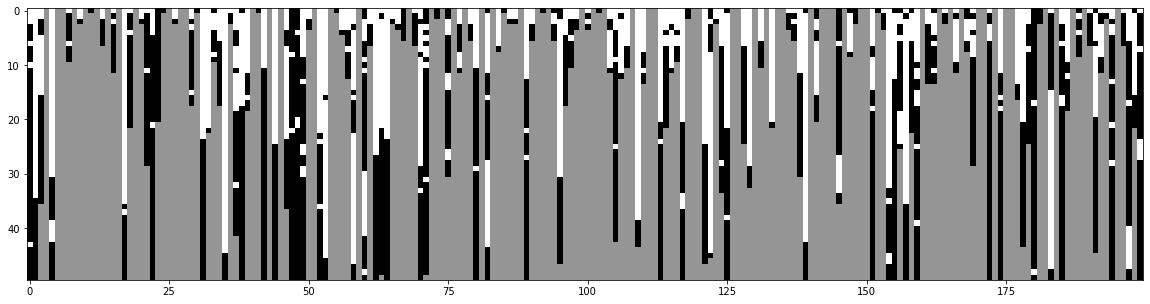

Freq: 7 iterations per update
[20.  5.]


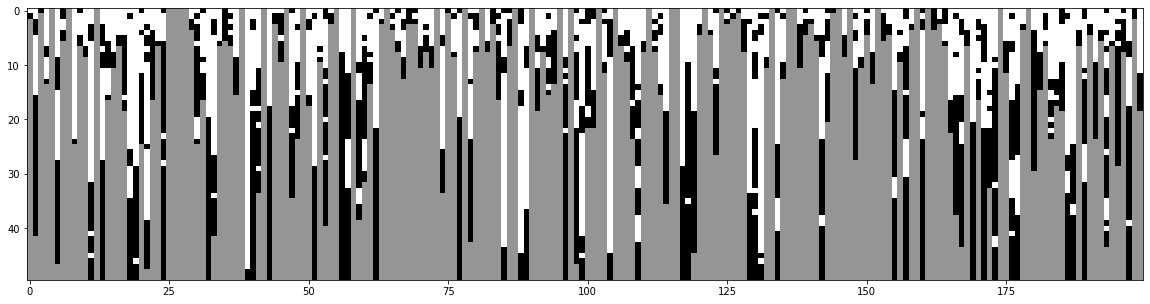

Freq: 50 iterations per update
[20.  5.]


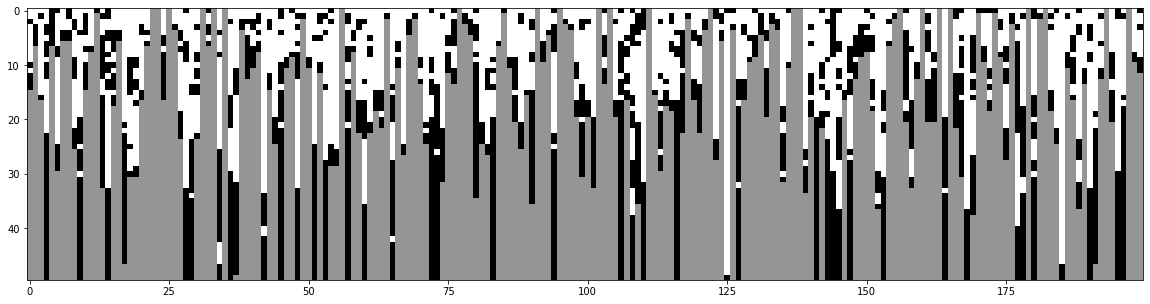

In [13]:
map_types = ["binary", "gradients"]
for i in range(len(drop_idxss)):
    print("Freq: %d iterations per update"%(iter_per_updates[i]))
    idx_heatmap(drop_idxss[i], D, "binary", False, True)
    #idx_heatmap(drop_idxss[i], D, "gradient", True)

# Plot for update rate vs (test) accuracy

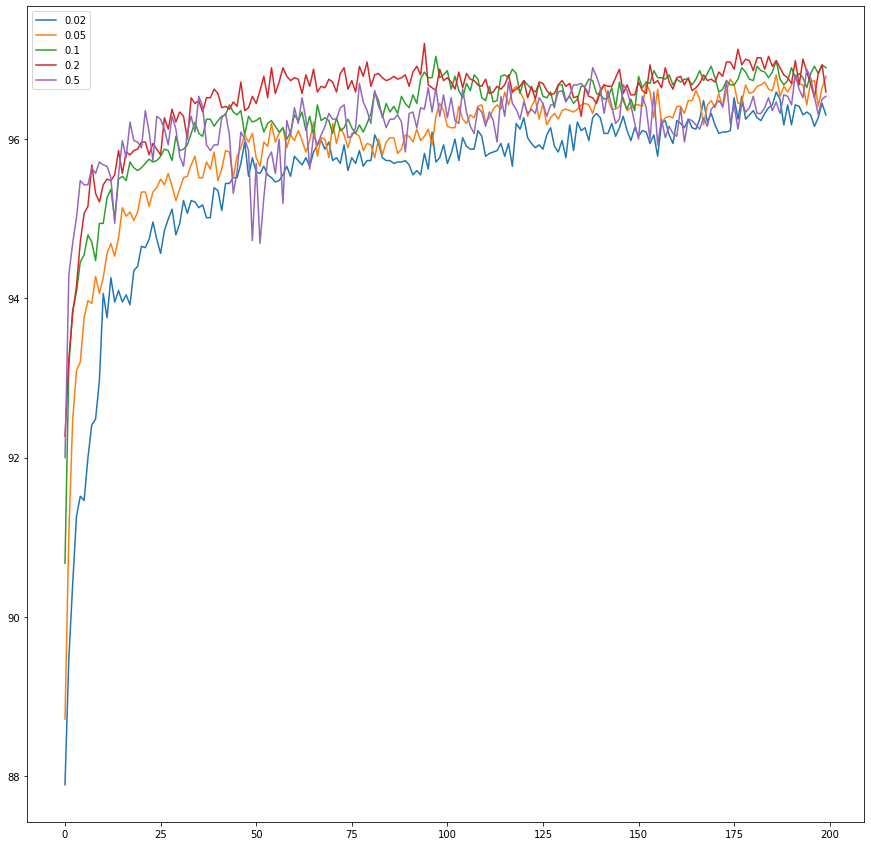

In [39]:
plt.figure(figsize = (15, 15))
sm_deg = 50 # Smoothness of curve, the higher the smoother. 1 = no smooth

for i,drop_accs  in enumerate (drop_accss):
    smoothed = [ np.max(drop_accs[sm_deg*i : sm_deg*(i+1)]) for i in range(len(drop_accs)//sm_deg) ]
    plt.plot( smoothed, label = str(percentDrops[i]))
plt.legend()
plt.show()

In [41]:
import xlsxwriter
workbook = xlsxwriter.Workbook('Dataset.xlsx')
worksheet = workbook.add_worksheet()

In [42]:
for i,drop_accs  in enumerate (drop_accss):
    smoothed = [ np.max(drop_accs[sm_deg*i : sm_deg*(i+1)]) for i in range(len(drop_accs)//sm_deg) ]
    for j, sm in enumerate(smoothed):
        worksheet.write(j, i, sm)
workbook.close()

# Averaged variance increases with accuarcy

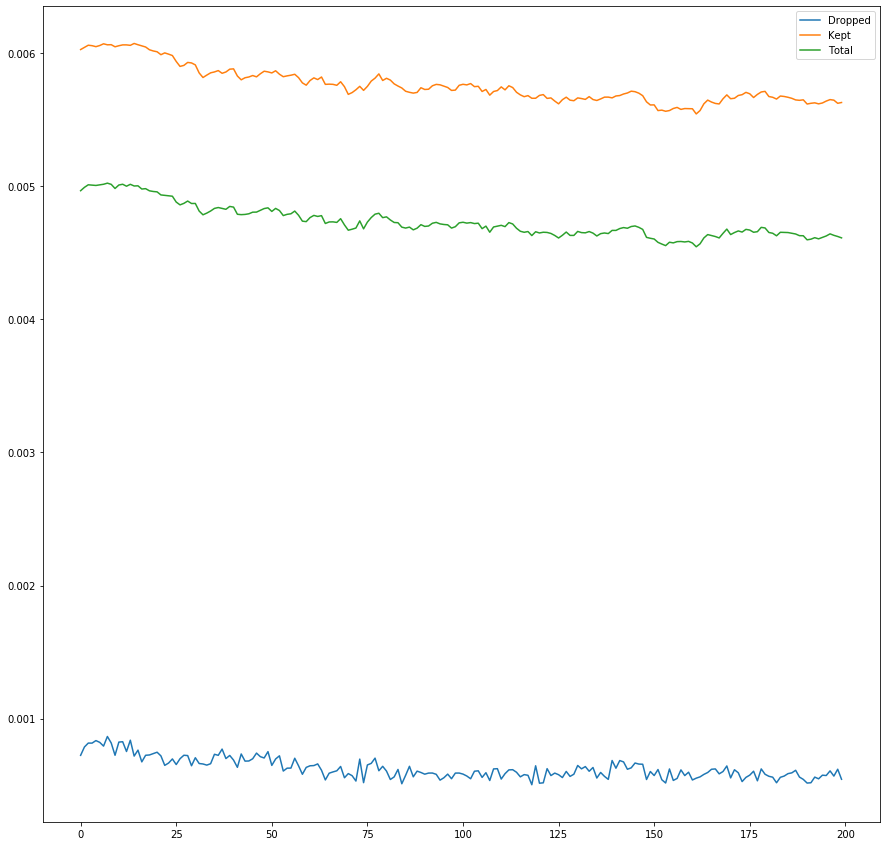

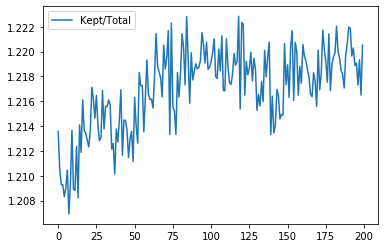

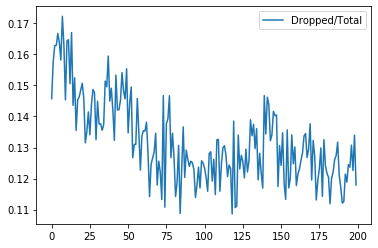

In [122]:
import xlsxwriter
workbook = xlsxwriter.Workbook('Averaged variance.xlsx')
worksheet2 = workbook.add_worksheet()


plt.figure(figsize = (15, 15))
amountDrop = int(percentDrop * D)
sm_deg = 5
crop = 2000
scale = 2000

for i in range(len(kept_means)):
    drop_vars = (np.asarray(drop_varss[i])/amountDrop)
    kept_mean = (np.asarray(kept_means[i])/(D-amountDrop))
    summed = (np.asarray(drop_varss[i]) + np.asarray(kept_means[i]))/D
    

    
    accu = drop_accss[i]
    
    assert len(drop_vars) == len(kept_mean) == len(summed)
    
    sm_sum = [ np.mean(summed[sm_deg*i : sm_deg*(i+1)])    for i in range(len(summed)//sm_deg) ]
    sm_drp = [ np.mean(drop_vars[sm_deg*i : sm_deg*(i+1)]) for i in range(len(drop_vars)//sm_deg) ]
    sm_kpt = [ np.mean(kept_mean[sm_deg*i : sm_deg*(i+1)]) for i in range(len(kept_mean)//sm_deg) ]
    sm_acc = [ np.mean(accu[sm_deg*i * iter_per_update : sm_deg*(i+1)*iter_per_update]) for i in range(len(accu)//sm_deg//iter_per_update) ]
    
    sm_sum = np.asarray(sm_sum[:crop])
    sm_drp = np.asarray(sm_drp[:crop])
    sm_kpt = np.asarray(sm_kpt[:crop])
    sm_acc = np.asarray(sm_acc[:crop])
    
    plt.plot(sm_drp, label = "Dropped")
    plt.plot(sm_kpt , label = "Kept")
    plt.plot(sm_sum , label = "Total")
    #plt.plot( (sm_acc-np.mean(sm_acc))/5000 + np.mean(sm_sum) , label = "Accuracy")
    plt.legend()
    plt.show()
    
    
    plt.plot(sm_kpt/sm_sum, label = "Kept/Total")
    plt.legend()
    plt.show()
    
    plt.plot(sm_drp/sm_sum, label = "Dropped/Total")
    plt.legend()
    plt.show()
    
    offset =  6*i
    worksheet2.write(0, offset + 0 , "Iteration")
    worksheet2.write(0, offset + 1 , "Total mean")
    worksheet2.write(0, offset + 2 , "Kept mean")
    worksheet2.write(0, offset + 3 , "Dropped mean")
    worksheet2.write(0, offset + 4 , "Accuracy")
    for j in range(len(sm_sum)):
        worksheet2.write(j+1, offset + 0 , j+1)
        worksheet2.write(j+1, offset + 1 , sm_sum[j])
        worksheet2.write(j+1, offset + 2 , sm_kpt[j])
        worksheet2.write(j+1, offset + 3 , sm_drp[j])
        worksheet2.write(j+1, offset + 4 , sm_acc[j])
workbook.close()

# Scratch paper: where the old codes are

In [19]:
# Initialize 

hdb = HDB.HD_basis(HDB.Generator.Vanilla, param)
basis = hdb.getBasis()
param = hdb.getParam()
hde = HDE.HD_encoder(basis)
trainencoded = hde.encodeData(traindata)
testencoded = hde.encodeData(testdata)

In [ ]:
train_accs = []
test_accs = []
drop_accs = []


hdc = HDC.HD_classifier(param["D"], param["nClasses"], 0)
train_acc = 100 * hdc.fit(trainencoded, trainlabels, param)
test_acc = 100 * hdc.test(testencoded, testlabels)
train_accs.append(train_acc)
test_accs.append(test_acc)
print("Train: %.2f \t \t Test: %.2f"%(train_acc, test_acc))

In [20]:
#Base line
# hdc_pre = HDC.HD_classifier(param["D"], param["nClasses"], 0)
# train_accs_pre, test_accs_pre = train(hdc_pre, trainencoded, trainlabels, testencoded, testlabels, param)
# print("Train: %f \t \t Test: %f"%(max(train_accs_pre), max(test_accs_pre)))

In [56]:

train_accs = []
test_accs = []
drop_accs = []


hdc = HDC.HD_classifier(param["D"], param["nClasses"], 0)
train_acc = 100 * hdc.fit(trainencoded, trainlabels, param)
test_acc = 100 * hdc.test(testencoded, testlabels)
train_accs.append(train_acc)
test_accs.append(test_acc)
print("Train: %.2f \t \t Test: %.2f"%(train_acc, test_acc))

Fitting with configuration: [('one_shot', 0), ('dropout', 0), ('lr', 0.037)] 


Train: 86.11 	 	 Test: 93.34


In [57]:
percentDrop = 0.20
iter_per_update = 5
amountDrop = int(percentDrop * hdc.D)

param["update_type"] = Config.Update_T.WEIGHTED
#param["masked"] = True

early_stopping_steps = 1000

es_count = 0
max_test = 0
best = None
best_basis = None
best_idx = 0

while int(train_acc) != 100 and len(train_accs) <= 200:
    var, orders = hdc.evaluateBasis()
    toDrop = orders[:amountDrop]
    toMask = orders[-amountDrop:]
    toDropVar = [var[i] for i in toDrop]
    print("Variances stats: max %.2f, min %.2f, mean %.2f"%(max(var),min(var),np.mean(var)))
    print("Dropping first %f percent of ineffective basis, with stats: max %f, min %f, mean %f"\
          %(percentDrop, max(toDropVar),min(toDropVar),np.mean(toDropVar)))
    #print("Dropping indices:", sorted(toDrop))
    #print("Masking  indices:", sorted(toMask))
    hdb.updateBasis(toDrop)
    hde.updateBasis(hdb.basis)
    trainencoded = hde.encodeData(traindata)
    testencoded = hde.encodeData(testdata)
    hdc.updateClasses()
    #hdc.updateClasses(toDrop)
    #hdc.updateWeights(toDrop)
    #hdc.updateMask(toMask)
    
    for i in range(iter_per_update):
        train_acc = 100 * hdc.fit(trainencoded, trainlabels, param)
        test_acc = 100 * hdc.test(testencoded, testlabels)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print("Train: %.2f \t \t Test: %.2f"%(train_acc, test_acc))
        if train_acc == 1:
            break
        
    if test_accs[-1] >= max_test:
        es_count = 0
        best = copy.deepcopy(hdc)
        best_basis = copy.deepcopy(hdb)
        best_idx = len(test_accs)
    else:
        es_count += 1
    if es_count > early_stopping_steps:
        print("Early stopping initiated, best stores the best hdc currently")
        break
        
        
param["update_type"] = Config.Update_T.FULL
param["masked"] = False

Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001592, min 0.000012, mean 0.000852
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 90.58 	 	 Test: 93.49


Time spent: 0 sec


Train: 92.90 	 	 Test: 93.24
Train: 93.25 	 	 Test: 93.94
Train: 94.04 	 	 Test: 92.27
Train: 93.67 	 	 Test: 94.13
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001181, min 0.000017, mean 0.000485
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 90.77 	 	 Test: 92.63


Time spent: 0 sec


Train: 92.91 	 	 Test: 93.13
Train: 93.51 	 	 Test: 81.84
Train: 93.74 	 	 Test: 91.01
Train: 94.26 	 	 Test: 86.04
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001553, min 0.000003, mean 0.000695
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 1 sec
Encoding data of shape (5574, 312)



Train: 91.14 	 	 Test: 89.59


Time spent: 0 sec


Train: 92.59 	 	 Test: 86.63
Train: 93.53 	 	 Test: 94.08
Train: 94.23 	 	 Test: 93.97
Train: 94.37 	 	 Test: 93.49
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001585, min 0.000016, mean 0.000751
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.65 	 	 Test: 93.29


Time spent: 0 sec


Train: 93.67 	 	 Test: 84.50
Train: 93.60 	 	 Test: 92.41
Train: 94.00 	 	 Test: 94.78
Train: 94.60 	 	 Test: 93.58
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001813, min 0.000022, mean 0.000872
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 90.63 	 	 Test: 93.81


Time spent: 0 sec


Train: 92.90 	 	 Test: 95.34
Train: 93.82 	 	 Test: 94.55
Train: 94.04 	 	 Test: 93.56
Train: 94.30 	 	 Test: 94.69
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001787, min 0.000049, mean 0.000991
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.34 	 	 Test: 92.21


Time spent: 0 sec


Train: 92.94 	 	 Test: 92.48
Train: 94.00 	 	 Test: 92.41
Train: 94.32 	 	 Test: 93.15
Train: 94.45 	 	 Test: 94.38
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001856, min 0.000117, mean 0.000926
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.10 	 	 Test: 91.33


Time spent: 0 sec


Train: 93.32 	 	 Test: 91.86
Train: 94.36 	 	 Test: 90.87
Train: 94.47 	 	 Test: 93.76
Train: 94.48 	 	 Test: 90.60
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001887, min 0.000058, mean 0.001084
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.21 	 	 Test: 93.88


Time spent: 0 sec


Train: 93.30 	 	 Test: 87.66
Train: 93.85 	 	 Test: 94.64
Train: 94.42 	 	 Test: 94.35
Train: 94.65 	 	 Test: 93.25
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001782, min 0.000010, mean 0.000913
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 90.98 	 	 Test: 93.54


Time spent: 0 sec


Train: 93.24 	 	 Test: 94.58
Train: 93.68 	 	 Test: 85.58
Train: 94.00 	 	 Test: 94.76
Train: 94.76 	 	 Test: 94.82
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001548, min 0.000011, mean 0.000690
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.04 	 	 Test: 85.76


Time spent: 0 sec


Train: 93.42 	 	 Test: 93.92
Train: 93.73 	 	 Test: 88.12
Train: 94.36 	 	 Test: 94.42
Train: 94.63 	 	 Test: 94.80
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001733, min 0.000006, mean 0.000711
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.17 	 	 Test: 89.40


Time spent: 0 sec


Train: 93.48 	 	 Test: 94.17
Train: 93.96 	 	 Test: 94.01
Train: 94.47 	 	 Test: 95.07
Train: 94.97 	 	 Test: 92.11
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001750, min 0.000020, mean 0.000769
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.68 	 	 Test: 94.38


Time spent: 0 sec


Train: 93.74 	 	 Test: 92.36
Train: 94.47 	 	 Test: 86.31
Train: 94.51 	 	 Test: 93.72
Train: 95.07 	 	 Test: 94.31
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001725, min 0.000000, mean 0.000737
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.61 	 	 Test: 94.31


Time spent: 0 sec


Train: 93.79 	 	 Test: 89.65
Train: 93.88 	 	 Test: 91.62
Train: 94.51 	 	 Test: 88.37
Train: 95.03 	 	 Test: 94.60
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.002153, min 0.000035, mean 0.000737
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.89 	 	 Test: 94.13


Time spent: 0 sec


Train: 93.88 	 	 Test: 93.83
Train: 94.64 	 	 Test: 89.18
Train: 94.44 	 	 Test: 94.21
Train: 94.91 	 	 Test: 93.68
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001913, min 0.000010, mean 0.000871
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.05 	 	 Test: 92.18


Time spent: 0 sec


Train: 93.36 	 	 Test: 94.71
Train: 93.99 	 	 Test: 92.88
Train: 94.61 	 	 Test: 94.55
Train: 95.09 	 	 Test: 94.78
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001719, min 0.000042, mean 0.000551
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.56 	 	 Test: 92.05


Time spent: 0 sec


Train: 93.47 	 	 Test: 91.89
Train: 94.58 	 	 Test: 93.68
Train: 94.74 	 	 Test: 94.71
Train: 95.29 	 	 Test: 90.87
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.002221, min 0.000034, mean 0.000996
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.85 	 	 Test: 94.03


Time spent: 0 sec


Train: 93.24 	 	 Test: 94.13
Train: 94.29 	 	 Test: 89.67
Train: 94.53 	 	 Test: 94.47
Train: 95.09 	 	 Test: 94.22
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.002093, min 0.000016, mean 0.000818
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.87 	 	 Test: 90.15


Time spent: 0 sec


Train: 93.48 	 	 Test: 93.29
Train: 94.38 	 	 Test: 94.47
Train: 94.61 	 	 Test: 92.11
Train: 94.86 	 	 Test: 94.51
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001906, min 0.000023, mean 0.000771
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.67 	 	 Test: 90.83


Time spent: 0 sec


Train: 93.41 	 	 Test: 93.85
Train: 94.00 	 	 Test: 94.42
Train: 94.60 	 	 Test: 93.09
Train: 95.12 	 	 Test: 93.43
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001666, min 0.000029, mean 0.000608
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.67 	 	 Test: 89.79


Time spent: 0 sec


Train: 93.51 	 	 Test: 89.81
Train: 94.12 	 	 Test: 89.76
Train: 94.64 	 	 Test: 94.44
Train: 94.90 	 	 Test: 94.35
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001523, min 0.000026, mean 0.000701
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.90 	 	 Test: 89.13


Time spent: 0 sec


Train: 93.81 	 	 Test: 88.70
Train: 94.09 	 	 Test: 94.06
Train: 94.95 	 	 Test: 94.15
Train: 94.86 	 	 Test: 86.29
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.002070, min 0.000035, mean 0.000818
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.29 	 	 Test: 90.89


Time spent: 0 sec


Train: 93.62 	 	 Test: 90.78
Train: 94.26 	 	 Test: 94.24
Train: 94.66 	 	 Test: 94.96
Train: 94.88 	 	 Test: 89.74
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001808, min 0.000010, mean 0.000721
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.70 	 	 Test: 91.30


Time spent: 0 sec


Train: 93.98 	 	 Test: 93.83
Train: 94.56 	 	 Test: 93.06
Train: 94.97 	 	 Test: 94.31
Train: 95.08 	 	 Test: 94.94
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.002068, min 0.000020, mean 0.000825
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.89 	 	 Test: 93.02


Time spent: 0 sec


Train: 93.80 	 	 Test: 93.06
Train: 94.49 	 	 Test: 91.33
Train: 94.80 	 	 Test: 93.13
Train: 95.02 	 	 Test: 93.72
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001837, min 0.000009, mean 0.000867
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.73 	 	 Test: 93.63


Time spent: 0 sec


Train: 93.67 	 	 Test: 93.83
Train: 94.66 	 	 Test: 94.76
Train: 94.54 	 	 Test: 94.98
Train: 95.13 	 	 Test: 90.56
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001784, min 0.000036, mean 0.000760
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 92.14 	 	 Test: 93.79


Time spent: 0 sec


Train: 93.58 	 	 Test: 94.73
Train: 94.60 	 	 Test: 94.15
Train: 94.69 	 	 Test: 93.74
Train: 95.45 	 	 Test: 94.60
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001906, min 0.000024, mean 0.000944
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.94 	 	 Test: 94.33


Time spent: 0 sec


Train: 94.00 	 	 Test: 93.77
Train: 94.32 	 	 Test: 92.09
Train: 95.02 	 	 Test: 94.22
Train: 95.07 	 	 Test: 94.22
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001655, min 0.000027, mean 0.000804
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.93 	 	 Test: 82.81


Time spent: 0 sec


Train: 93.83 	 	 Test: 91.86
Train: 94.66 	 	 Test: 89.76
Train: 94.79 	 	 Test: 93.86
Train: 94.96 	 	 Test: 91.62
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001561, min 0.000004, mean 0.000701
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 92.10 	 	 Test: 93.22


Time spent: 0 sec


Train: 93.94 	 	 Test: 91.75
Train: 94.57 	 	 Test: 94.37
Train: 95.04 	 	 Test: 95.26
Train: 95.19 	 	 Test: 95.28
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.002066, min 0.000002, mean 0.000862
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 92.27 	 	 Test: 94.12


Time spent: 0 sec


Train: 94.17 	 	 Test: 93.72
Train: 94.65 	 	 Test: 94.74
Train: 95.07 	 	 Test: 93.13
Train: 95.39 	 	 Test: 95.05
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.002360, min 0.000007, mean 0.000995
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.85 	 	 Test: 90.64


Time spent: 0 sec


Train: 93.95 	 	 Test: 83.49
Train: 94.49 	 	 Test: 94.60
Train: 95.06 	 	 Test: 94.89
Train: 95.31 	 	 Test: 94.49
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001458, min 0.000005, mean 0.000755
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 92.23 	 	 Test: 91.55


Time spent: 0 sec


Train: 93.96 	 	 Test: 93.61
Train: 94.45 	 	 Test: 95.44
Train: 94.86 	 	 Test: 92.30
Train: 95.11 	 	 Test: 95.08
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001773, min 0.000020, mean 0.000732
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.92 	 	 Test: 93.60


Time spent: 0 sec


Train: 94.21 	 	 Test: 94.13
Train: 94.57 	 	 Test: 93.76
Train: 94.88 	 	 Test: 93.65
Train: 95.41 	 	 Test: 95.30
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001997, min 0.000091, mean 0.000836
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 91.92 	 	 Test: 94.65


Time spent: 0 sec


Train: 94.07 	 	 Test: 91.94
Train: 94.40 	 	 Test: 91.23
Train: 95.41 	 	 Test: 93.68
Train: 95.65 	 	 Test: 95.66
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001749, min 0.000051, mean 0.000807
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 92.14 	 	 Test: 91.37


Time spent: 0 sec


Train: 94.22 	 	 Test: 95.16
Train: 94.86 	 	 Test: 94.73
Train: 95.00 	 	 Test: 95.35
Train: 95.28 	 	 Test: 95.21
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001812, min 0.000033, mean 0.000874
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 92.12 	 	 Test: 93.07


Time spent: 0 sec


Train: 94.23 	 	 Test: 88.18
Train: 95.21 	 	 Test: 93.04
Train: 95.24 	 	 Test: 95.10
Train: 95.57 	 	 Test: 94.35
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001837, min 0.000022, mean 0.000800
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 92.25 	 	 Test: 93.06


Time spent: 0 sec


Train: 94.62 	 	 Test: 93.27
Train: 94.95 	 	 Test: 95.48
Train: 95.00 	 	 Test: 94.44
Train: 95.63 	 	 Test: 94.42
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001837, min 0.000003, mean 0.000829
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 92.24 	 	 Test: 92.55


Time spent: 0 sec


Train: 93.55 	 	 Test: 95.01
Train: 95.22 	 	 Test: 94.40
Train: 95.52 	 	 Test: 94.47
Train: 95.48 	 	 Test: 95.12
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.002151, min 0.000022, mean 0.000825
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 92.57 	 	 Test: 94.10


Time spent: 0 sec


Train: 94.15 	 	 Test: 91.75
Train: 94.78 	 	 Test: 93.92
Train: 95.32 	 	 Test: 92.32
Train: 95.21 	 	 Test: 94.46
Variances stats: max 0.02, min 0.00, mean 0.00
Dropping first 0.200000 percent of ineffective basis, with stats: max 0.001807, min 0.000012, mean 0.000740
Updating basis......


Encoding data of shape (10000, 312)


Time spent: 0 sec
Encoding data of shape (5574, 312)



Train: 92.37 	 	 Test: 93.60


Time spent: 0 sec


Train: 94.34 	 	 Test: 94.80
Train: 94.67 	 	 Test: 94.44
Train: 95.03 	 	 Test: 95.14
Train: 95.66 	 	 Test: 91.69


In [58]:
for (a,b) in zip(train_accs, test_accs):
    print( "%.2f \t %.2f \t"%(a,b) )

86.11 	 93.34 	
90.58 	 93.49 	
92.90 	 93.24 	
93.25 	 93.94 	
94.04 	 92.27 	
93.67 	 94.13 	
90.77 	 92.63 	
92.91 	 93.13 	
93.51 	 81.84 	
93.74 	 91.01 	
94.26 	 86.04 	
91.14 	 89.59 	
92.59 	 86.63 	
93.53 	 94.08 	
94.23 	 93.97 	
94.37 	 93.49 	
91.65 	 93.29 	
93.67 	 84.50 	
93.60 	 92.41 	
94.00 	 94.78 	
94.60 	 93.58 	
90.63 	 93.81 	
92.90 	 95.34 	
93.82 	 94.55 	
94.04 	 93.56 	
94.30 	 94.69 	
91.34 	 92.21 	
92.94 	 92.48 	
94.00 	 92.41 	
94.32 	 93.15 	
94.45 	 94.38 	
91.10 	 91.33 	
93.32 	 91.86 	
94.36 	 90.87 	
94.47 	 93.76 	
94.48 	 90.60 	
91.21 	 93.88 	
93.30 	 87.66 	
93.85 	 94.64 	
94.42 	 94.35 	
94.65 	 93.25 	
90.98 	 93.54 	
93.24 	 94.58 	
93.68 	 85.58 	
94.00 	 94.76 	
94.76 	 94.82 	
91.04 	 85.76 	
93.42 	 93.92 	
93.73 	 88.12 	
94.36 	 94.42 	
94.63 	 94.80 	
91.17 	 89.40 	
93.48 	 94.17 	
93.96 	 94.01 	
94.47 	 95.07 	
94.97 	 92.11 	
91.68 	 94.38 	
93.74 	 92.36 	
94.47 	 86.31 	
94.51 	 93.72 	
95.07 	 94.31 	
91.61 	 94.31 	
93.79 	 

In [51]:
hdc_post = HDC.HD_classifier(param["D"], param["nClasses"], 0)
train_accs_post, test_accs_post, iter_post = train(hdc_post, trainencoded, trainlabels, testencoded, testlabels, param)


c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Fitting with configuration: [('one_shot', 0), ('dropout', 0), ('lr', 0.037)] 


Train: 0.958200 	 	 Test: 0.950126
Train: 0.963100 	 	 Test: 0.918730
Train: 0.965300 	 	 Test: 0.933979
Train: 0.966100 	 	 Test: 0.949049
Train: 0.967300 	 	 Test: 0.943488
Train: 0.966600 	 	 Test: 0.950484
Train: 0.969400 	 	 Test: 0.949767
Train: 0.968800 	 	 Test: 0.948332
Train: 0.969300 	 	 Test: 0.949587
Train: 0.969700 	 	 Test: 0.950305
Train: 0.970100 	 	 Test: 0.946358
Train: 0.970500 	 	 Test: 0.941335



In [52]:
train_accs_fin, test_accs_fin, iter_fin= train(hdc, trainencoded, trainlabels, testencoded, testlabels, param)

# Rememeber to change back the encoding 
#train_accs_best, test_accs_best, iter_best= train(best, trainencoded, trainlabels, testencoded, testlabels, param)

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Train: 0.961100 	 	 Test: 0.946358
Train: 0.965100 	 	 Test: 0.917833
Train: 0.966300 	 	 Test: 0.940797
Train: 0.968000 	 	 Test: 0.943129
Train: 0.966900 	 	 Test: 0.950843
Train: 0.970400 	 	 Test: 0.949229
Train: 0.970400 	 	 Test: 0.940438
Train: 0.967600 	 	 Test: 0.950305
Train: 0.969400 	 	 Test: 0.942949
Train: 0.969100 	 	 Test: 0.949229
Train: 0.970300 	 	 Test: 0.944564
Train: 0.970800 	 	 Test: 0.947973



Train: 0.961300 	 	 Test: 0.945102
Train: 0.962500 	 	 Test: 0.949946
Train: 0.966100 	 	 Test: 0.947614
Train: 0.967900 	 	 Test: 0.933800
Train: 0.968800 	 	 Test: 0.947973
Train: 0.969200 	 	 Test: 0.946717
Train: 0.967300 	 	 Test: 0.949946
Train: 0.968200 	 	 Test: 0.942411
Train: 0.968400 	 	 Test: 0.950843
Train: 0.968000 	 	 Test: 0.947614
Train: 0.972000 	 	 Test: 0.949408
Train: 0.971600 	 	 Test: 0.944026



In [53]:
#print("Max pre test acc: \t %f \t"%max(100 * test_accs_pre))
print("Max test acc: \t \t %f \t"%max(test_accs))
print("Max post test acc: \t %f \t"%max(100 * test_accs_post))
print("Max fin\t acc: \t \t %f \t"%max(100 * test_accs_fin))
#print("Max best acc: \t \t %f \t"%max(100 * test_accs_best))
#print(max(100 * test_accs_pre))
print(max(test_accs))
print(max(100 * test_accs_post))
print(max(100 * test_accs_fin))
#print(max(100 * test_accs_best))

Max test acc: 	 	 95.227844 	
Max post test acc: 	 95.281665 	
Max fin	 acc: 	 	 95.317546 	
Max best acc: 	 	 95.263724 	
95.22784355938285
95.2816648726229
95.31754574811625
95.26372443487621


In [54]:
print(hdc.idx_weights)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [19]:
print(hdc.update_cnts)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [20]:
print(best_idx)

201
